# running all 14 models for the updated Zinser dataset
 * `m1` through `m14`
 * this is for the _new new_ dataset 
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## global switches and settings

In [1]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'data_exp_zs_20201009_g3_newzinser-25-7.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

## load data from files and plot

In [2]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

# load data
datafiles = {
    #'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2.nc',
    #'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
    'zinser':'data/Zinser_SizeDist_logtransform-25-7.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

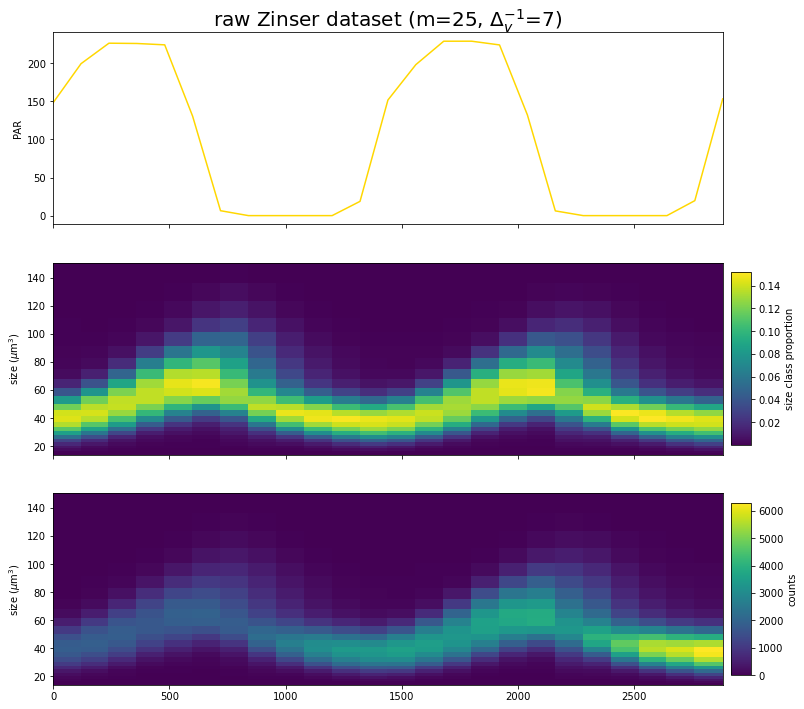

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [4]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


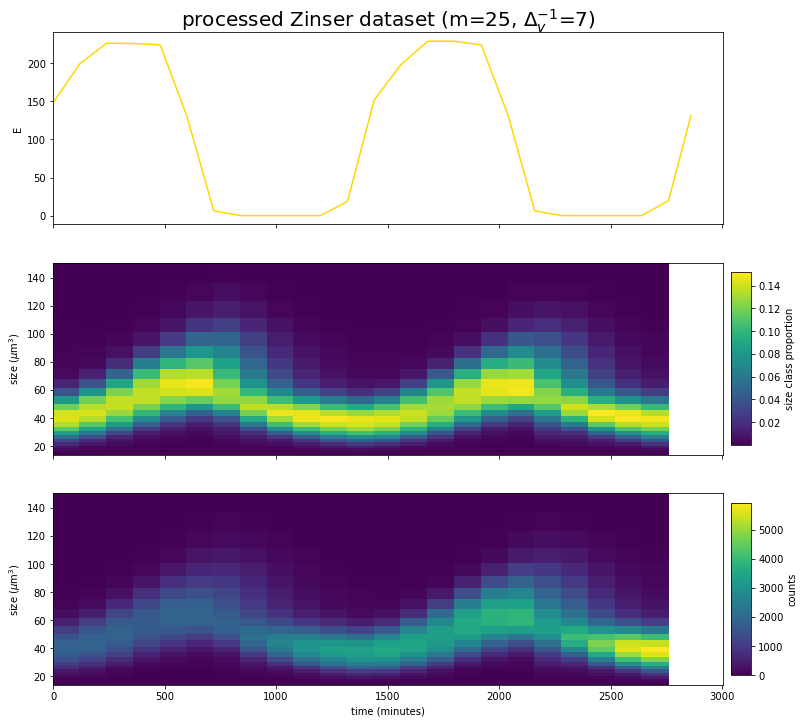

In [5]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs_count'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [6]:
desc_model = {
    'm1':'m1',
    'm2':'m2',
    'm3':'m3',
    'm4':'m4',
    'm5':'m5',
    'm6':'m6',
    'm7':'m7',
    'm8':'m8',
    'm9':'m9',
    'm10':'m10',
    'm11':'m11',
    'm12':'m12',
    'm13':'m13',
    'm14':'m14',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c11',
    'm12':'c12',
    'm13':'c13',
    'm14':'c14',
}
stan_files = {
    'c1':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
    'c3':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
    'c6':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c7':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c8':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c9':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c10':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
    'c11':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c12':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c13':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c14':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
}

In [7]:
import pystan
import re
import time

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    if model not in sampling_time:
        sampling_time[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if dataname not in sampling_time[model]:
            sampling_time[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{}: found existing results:'.format(model))
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    print('{}: not re-running model'.format(model))
                    print()
                    continue
            elif refit_all:
                print('{}: refit_all is active, re-running model'.format(model))
            elif refit_required[model]:
                print('{}: change in model code requires re-running model'.format(model))
        else:
            mcmcs[model] = {}
        for itry in range(num_tries):
            t0 = time.time()
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000, chains=num_chains)
            sampling_time[model][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/{} found Rhat={:.3f}, trying again'.format(model, itry+1, num_tries, rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
        print()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m1 NOW.


m1: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp3en7yygr/stanfit4m1_2292272622260778718.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m2 NOW.


m2: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpbnhq8jhg/stanfit4m2_5802254294975368274.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m3 NOW.


m3: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpvdxnz09e/stanfit4m3_5710187475176394076.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m4 NOW.


m4: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmplh_4l_ge/stanfit4m4_2242815938249138277.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5 NOW.


m5: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmph3jnrzax/stanfit4m5_121158788186306840.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6 NOW.


m6: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpqpmektel/stanfit4m6_5215272868278441710.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m7 NOW.


m7: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpf3kyopn_/stanfit4m7_1413298067438200680.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m8 NOW.


m8: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpkwuna68h/stanfit4m8_7123071221032551200.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m9 NOW.


m9: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2grrlbwu/stanfit4m9_6600199706119092831.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m10 NOW.


m10: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp48uo9eu8/stanfit4m10_6869392216761657017.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m11 NOW.


m11: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpb3vt3pe1/stanfit4m11_3509406182682143166.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12 NOW.


m12: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmptzpix14h/stanfit4m12_2626291863488551449.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m13 NOW.


m13: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpe5jl07x4/stanfit4m13_1707178436797255071.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m14 NOW.


m14: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmposp7s6oq/stanfit4m14_3113920913915587879.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


m1 (m1)
Inference for Stan model: m1.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu               3.86    0.01   0.92   2.04   3.24   3.86   4.48   5.67   7916    1.0
delta_sigma            9.51    0.03   1.84   6.42    8.2   9.34  10.58  13.64   4270    1.0
gamma_max              6.88  6.1e-3   0.52   5.57   6.61   7.02   7.29   7.47   7455    1.0
rho_max                3.75    0.02   2.16   0.22    1.9   3.74   5.62    7.3  11104    1.0
E_star               492.58    0.63  53.81 370.96 460.45 498.52 530.68 582.17   7307    1.0
sigma                161.29    0.12   9.31 143.41 154.89 161.16  167.4 180.11   6139    1.0
divrate                1.05  6.2e-4   0.05   0.96   1.02   1.05   1.08   1.15   6188    1.0
lp__                 -1.4e6    0.41  17.96 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   1891    1.0

Samples were dr

m2 (m2)
Inference for Stan model: m2.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             40.05    0.18   9.52  25.48  33.13  38.57  45.53  62.79   2689    1.0
gamma_max               6.9  7.5e-3   0.51    5.6   6.62   7.05    7.3   7.48   4629    1.0
rho_max                3.68    0.02   2.14   0.19   1.82   3.64   5.48   7.29  14191    1.0
E_star               479.89    0.74  51.77 360.32 449.37 486.47 515.36 566.96   4866    1.0
sigma                162.93    0.08   9.52 144.67  156.4 162.73 169.29  182.4  12665    1.0
divrate                1.08  6.2e-4   0.05   0.98   1.04   1.07   1.11   1.17   6315    1.0
lp__                 -1.4e6    0.39  18.23 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2219    1.0

Samples were drawn using NUTS at Fri Oct  9 16:09:22 2020.
For each parameter, n_eff is a crude measure of 

m3 (m3)
Inference for Stan model: m3.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             36.54     0.2   9.43  22.31   29.7  34.99  41.85   59.3   2284    1.0
gamma_max              6.92  7.7e-3    0.5   5.67   6.66   7.06   7.31   7.48   4251    1.0
E_star               457.75    0.71  49.65 347.09 428.66 462.87 492.39 542.11   4905    1.0
sigma                 166.5    0.09   9.74 148.19 159.74 166.29 173.01  186.2  10870    1.0
xi                    -0.26  9.4e-4    0.1  -0.46  -0.32  -0.26  -0.19  -0.07  11061    1.0
divrate                1.04  6.0e-4   0.05   0.95   1.01   1.04   1.07   1.14   6402    1.0
lp__                 -1.4e6    0.41  18.08 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   1925    1.0

Samples were drawn using NUTS at Fri Oct  9 16:19:44 2020.
For each parameter, n_eff is a crude measure of 

m4 (m4)
Inference for Stan model: m4.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             59.58     0.1   7.62  43.95  54.09   60.2  65.86  71.32   6309    1.0
gamma_max              7.02  6.6e-3   0.41    6.0   6.82   7.13   7.34   7.48   3802    1.0
rho_max                0.79  4.2e-4   0.03   0.73   0.77   0.79   0.81   0.85   5377    1.0
E_star               326.55    0.49  29.02 256.48 311.07 331.32 346.99 370.91   3518    1.0
sigma                303.17     0.2   17.4 270.98 291.27 302.74 314.61 338.24   7748    1.0
divrate                0.68  3.2e-4   0.03   0.63   0.66   0.68    0.7   0.73   6102    1.0
lp__                 -1.4e6    0.38  17.51 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2110    1.0

Samples were drawn using NUTS at Fri Oct  9 16:44:30 2020.
For each parameter, n_eff is a crude measure of 

m5 (m5)
Inference for Stan model: m5.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             38.07    0.21  10.06  23.22  30.89  36.27  43.65  63.47   2314    1.0
gamma_max              4.77    0.02   1.07   3.36   3.89   4.53   5.46    7.2   2654    1.0
rho_max                1.01  5.2e-4   0.04   0.95   0.99   1.01   1.04   1.09   4480    1.0
E_star               219.62     1.6  83.56 104.92 151.28 202.71 274.37 404.46   2710    1.0
sigma                465.62    0.32  26.01 416.16 447.45 464.98 483.13 518.41   6477    1.0
divrate                0.46  2.5e-4   0.02   0.42   0.45   0.46   0.47    0.5   6054    1.0
lp__                 -1.4e6    0.39  18.42 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2237    1.0

Samples were drawn using NUTS at Fri Oct  9 17:32:38 2020.
For each parameter, n_eff is a crude measure of 

m6: in try 1/3 found Rhat=7.074, trying again


m6 (m6)
Inference for Stan model: m6.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              5.35    0.01   0.96   3.93    4.7   5.18   5.82   7.68   6374    1.0
gamma_max              4.03    0.01   0.53   3.43   3.66   3.86   4.26   5.41   2820    1.0
rho_max                2.31  1.9e-3   0.15   2.03   2.21   2.31   2.42   2.62   6517    1.0
E_star               134.05    0.75   40.6  86.82 105.15 121.08 153.44 236.79   2896    1.0
sigma                662.44    0.46  37.45 591.55  636.8 661.85 687.42 736.15   6563    1.0
xi                    -0.31  7.5e-4   0.06  -0.44  -0.36  -0.31  -0.27  -0.19   7051    1.0
xir                    0.86  8.6e-4   0.07   0.71   0.81   0.85    0.9    1.0   7008    1.0
divrate                0.29  2.4e-4   0.02   0.25   0.27   0.29    0.3   0.32   5596    1.0
lp__            

m7 (m7)
Inference for Stan model: m7.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              4.35    0.01   0.87   3.01   3.73   4.21   4.84   6.36   5270    1.0
gamma_max              7.16  3.7e-3   0.29   6.44   7.01   7.24   7.39   7.48   6010    1.0
rho_max                3.24  3.0e-3   0.22   2.82   3.09   3.24   3.38   3.69   5337    1.0
E_star               212.56    0.21  16.48 174.98 203.19 214.77 224.16 239.21   5972    1.0
sigma                609.24    0.47  37.53 535.77 583.77 608.54 633.55 683.98   6380    1.0
xi                    -1.13  9.2e-4   0.07  -1.27  -1.18  -1.13  -1.08  -0.98   6235    1.0
xir                    1.31  1.1e-3   0.07   1.16   1.26   1.32   1.36   1.46   4992    1.0
divrate                0.22  2.6e-4   0.02   0.18    0.2   0.22   0.23   0.26   5562    1.0
lp__            

m8: in try 1/3 found Rhat=8.823, trying again


m8 (m8)
Inference for Stan model: m8.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             10.41    0.03   1.51   8.21   9.33  10.17  11.21  14.13   3301    1.0
gamma_max              4.43    0.02   1.13    3.1   3.57   4.06   5.02   7.16   2076    1.0
rho_max                0.95  1.8e-3   0.11   0.74   0.87   0.94   1.02   1.16   3447    1.0
E_star               266.31    2.28 105.12 135.29 185.91  233.6 325.15 515.48   2129    1.0
sigma                881.79    0.63  50.58 785.14 847.14 880.53 914.59 985.33   6478    1.0
xi                    -0.64  8.6e-4   0.06  -0.75  -0.68  -0.64   -0.6  -0.52   4506    1.0
xir                    0.46  1.2e-3   0.09   0.29    0.4   0.46   0.52   0.63   4862    1.0
delta_lightthresh     27.01    0.05   4.16  19.24  24.09   26.9  29.78   35.4   6530    1.0
delta_lightsigma

m9 (m9)
Inference for Stan model: m9.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             18.11     0.1   3.39  13.31  15.71   17.5  19.84  26.35   1236    1.0
gamma_max              6.74    0.02   0.62   5.21   6.39    6.9   7.24   7.47    822   1.01
rho_max                0.01  1.3e-4   0.01 3.2e-4 3.4e-3 7.8e-3   0.02   0.04   7178    1.0
E_star                739.1    2.87  81.67 541.07 691.86 756.56 800.86 851.45    811   1.01
sigma                736.22    0.55  43.77 652.85 706.69 735.08 764.88 824.13   6337    1.0
xi                    -0.99  9.4e-4   0.06  -1.11  -1.03  -0.99  -0.95  -0.87   4298    1.0
xir                    0.01  2.3e-3    0.1   -0.2  -0.06   0.01   0.08   0.21   2021    1.0
delta_lightthresh     18.39    0.03   2.78  13.32   16.5  18.23   20.1  24.25   7211    1.0
delta_lightsigma

m10 (m10)
Inference for Stan model: m10.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             30.15    0.46   13.6  15.61   20.7  25.49  35.05  67.39    862   1.01
delta_lightthresh     18.18    0.08   4.15  10.44  15.37   18.0   20.9  26.77   2929    1.0
delta_lightsigma        0.2  2.5e-4   0.02   0.16   0.19    0.2   0.21   0.24   6345    1.0
gamma_max              6.17    0.02   0.98   3.93   5.52   6.36   6.98   7.45   4166    1.0
rho_max                0.36  6.9e-4   0.05   0.26   0.33   0.36   0.39   0.46   5378    1.0
E_star               689.35    2.12 134.33 389.25 602.22 713.05 793.38 889.01   4004    1.0
sigma                512.24    0.39  29.37 454.87 492.16 511.97 531.55 570.98   5689    1.0
divrate                0.45  2.7e-4   0.02   0.41   0.44   0.45   0.46   0.49   5545    1.0
lp__         

m11 (m11)
Inference for Stan model: m11.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              9.55    0.04   2.49   6.24   7.84   9.07  10.73  15.58   5049    1.0
gamma_max              4.67    0.02   0.66    3.9   4.23   4.49   4.91   6.62   1140    1.0
rho_max                1.07  5.3e-4   0.03   1.01   1.05   1.07   1.09   1.14   3832    1.0
E_star               160.62    1.32  45.81 105.64 129.38 147.78 178.65 291.87   1205    1.0
sigma                546.83    0.41  30.39 488.66 525.85 546.53 566.78 607.37   5457    1.0
xi                    -0.67  7.3e-4   0.06  -0.79  -0.71  -0.67  -0.63  -0.56   6624    1.0
divrate                0.38  2.4e-4   0.02   0.34   0.36   0.38   0.39   0.41   6220    1.0
lp__                 -1.4e6    0.38   18.3 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2297    1.0

Samples were

m12: in try 1/3 found Rhat=14.168, trying again


m12: in try 2/3 found Rhat=7.781, trying again


m12 (m12)
Inference for Stan model: m12.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             38.37    0.21  10.19  22.02  30.78  37.05  44.59  61.98   2354    1.0
gamma_max              7.12  5.8e-3   0.33   6.27   6.95    7.2   7.37   7.48   3220    1.0
rho_max                0.85  4.7e-4   0.03   0.79   0.83   0.85   0.87   0.91   4474    1.0
E_star               269.02    0.42   23.1 216.05 255.76 271.02 284.78 307.64   3001    1.0
sigma                348.83    0.31  21.25 308.81 333.93 348.41 362.94 390.74   4836    1.0
xi                    -0.74  1.9e-3   0.12  -0.97  -0.82  -0.74  -0.66  -0.52   3553    1.0
divrate                0.55  4.6e-4   0.03   0.49   0.53   0.55   0.57   0.61   4076    1.0
lp__                 -1.4e6    0.37  18.44 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2444    1.0

Samples were

m13 (m13)
Inference for Stan model: m13.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max             11.78    0.03    1.9   9.04  10.47  11.45  12.75   16.4   3793    1.0
gamma_max              5.59    0.02   1.07   3.73   4.72   5.56    6.5   7.41   4135    1.0
rho_max                0.59  6.4e-4   0.04   0.51   0.56   0.59   0.62   0.67   4640    1.0
E_star               368.51    1.57  99.65 192.29 288.07 366.94 451.11 537.86   4050    1.0
sigma                866.75     0.6  50.52 771.29 831.57 866.57 900.55 967.97   7003    1.0
xi                    -0.83  5.0e-4   0.04  -0.91  -0.86  -0.83  -0.81  -0.76   6702    1.0
delta_lightthresh     24.82    0.05    3.9  17.47  22.14  24.65  27.43  32.77   7459    1.0
delta_lightsigma        0.2  2.2e-4   0.02   0.17   0.19    0.2   0.22   0.24   8023    1.0
divrate      

m14 (m14)
Inference for Stan model: m14.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              18.1     0.1   3.41  13.26  15.77  17.45  19.76   26.6   1251    1.0
gamma_max              6.76    0.02    0.6   5.35   6.41   6.91   7.24   7.47    974   1.01
rho_max                0.01  1.2e-4   0.01 3.2e-4 3.2e-3 7.3e-3   0.01   0.04   7192    1.0
E_star               740.92    2.52  78.27 559.07 696.64 757.36 800.02 850.55    966   1.01
sigma                736.86    0.51  44.44 655.07 706.12 735.57 765.62  828.0   7641    1.0
xi                    -0.99  7.3e-4   0.06  -1.11  -1.04  -0.99  -0.95  -0.87   7350    1.0
delta_lightthresh     18.44    0.03   2.81  13.29   16.5  18.35  20.18  24.34   6674    1.0
delta_lightsigma        0.2  2.1e-4   0.02   0.16   0.19    0.2   0.22   0.24   8627    1.0
divrate      

## plot the results

In [8]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [9]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

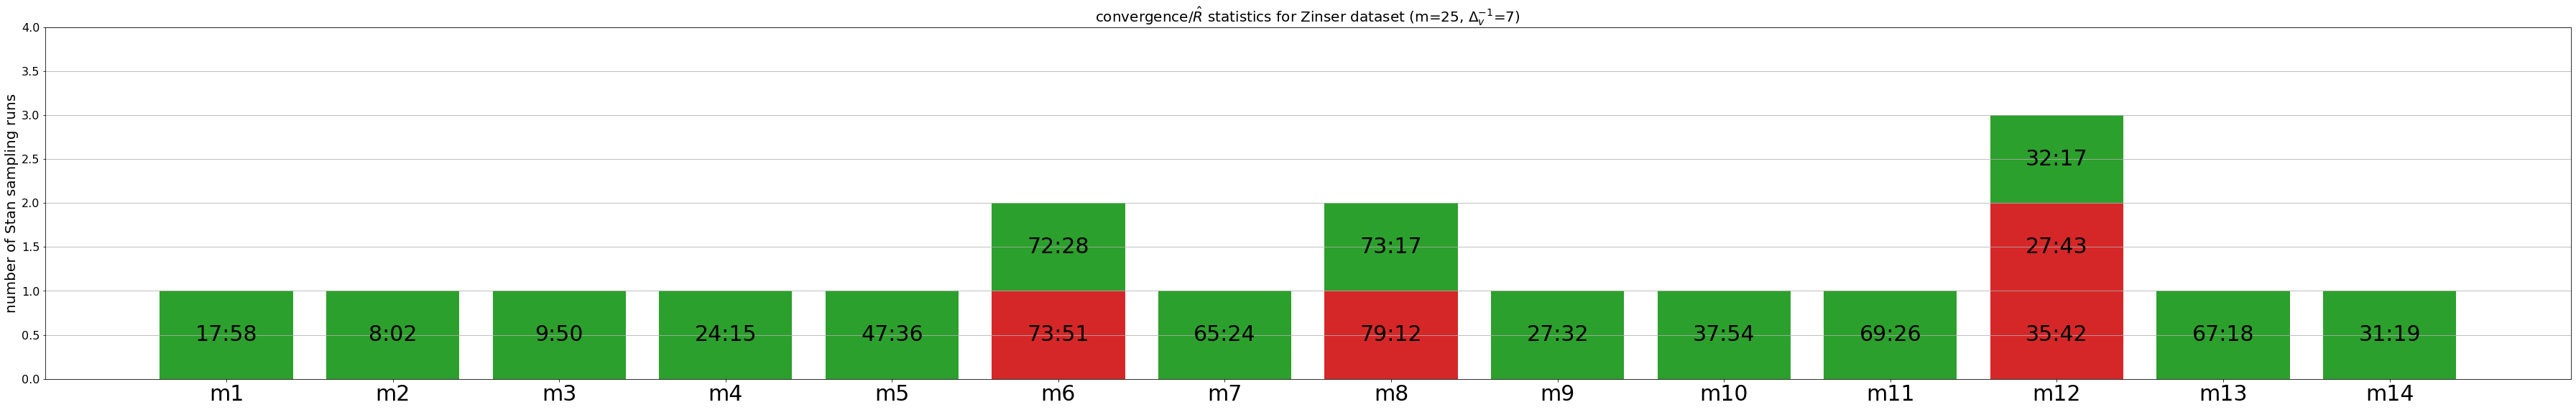

In [10]:
ylim_top = 0
for dataname in data:
    for model in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[model][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(20,len(mcmcs)*4.5),len(data)*9), squeeze=False, sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[model][dataname])
        height_good = len(maxrhats[model][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        
        if len(sampling_time[model][dataname]) != height_bad+height_good:
            print('{}, {}: Timing information inconsistent.'.format(dataname, desc_model[model]))
        else:
            for it, t in enumerate(sampling_time[model][dataname]):
                ax.text(x, it+0.5, '{:.0f}:{:02.0f}'.format(t//60, t%60), ha='center', va='center', size=30)
            
        xticks.append(x)
        xticklabels.append(desc_model[model].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels, size=30)#, rotation=8)
    ax.grid(axis='y')
    
    #fig.savefig('convergence_exp_zs_20201008_g2_newzinser-25-7.png', bbox_inches='tight')

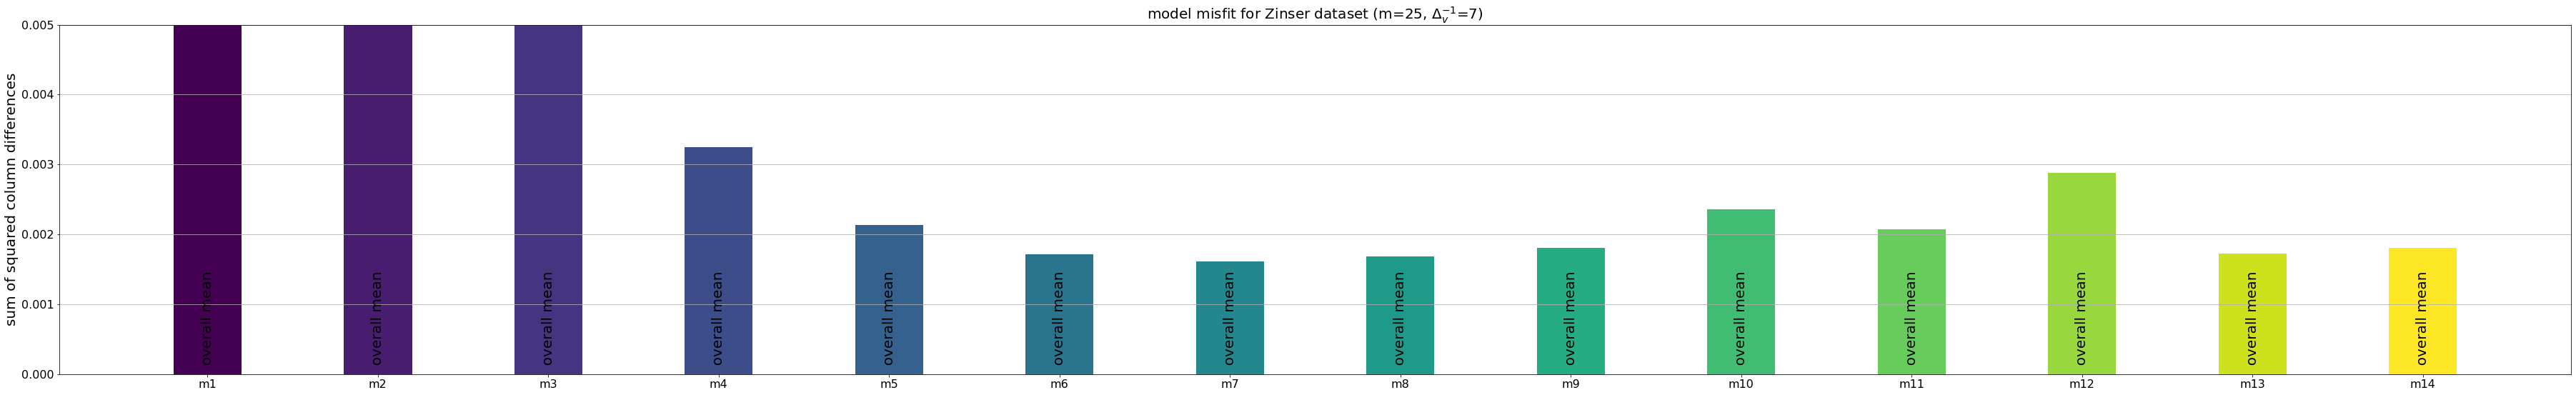

In [11]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[model],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[model])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[model].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

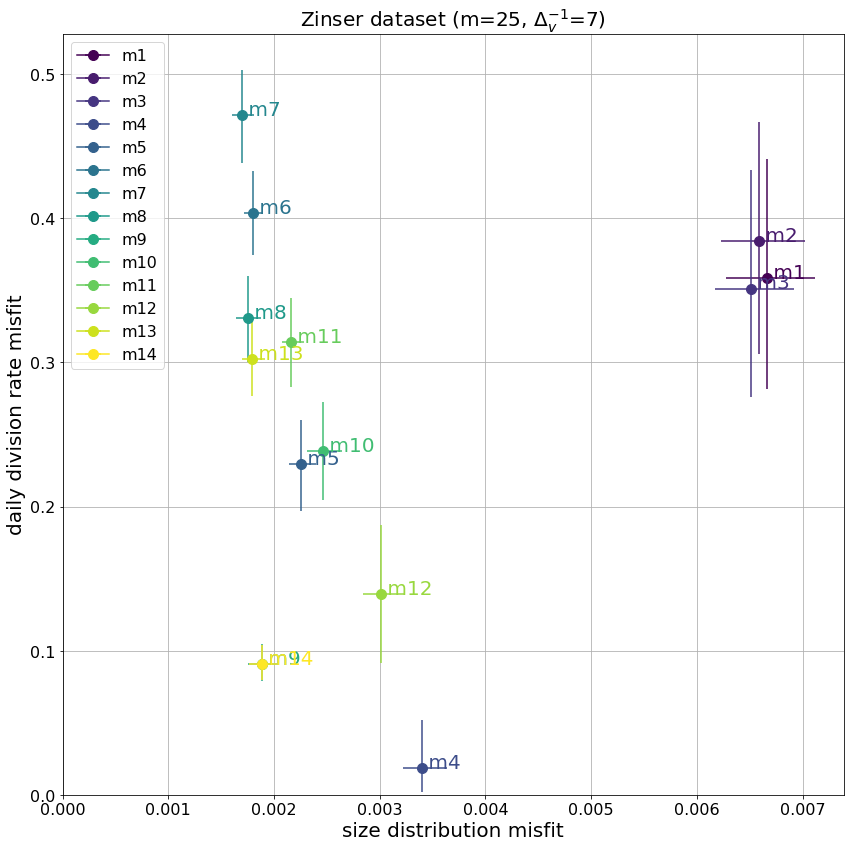

In [12]:
add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

In [13]:
datanames = tuple(data.keys())
if len(datanames) > 1:
    fig, ax = plt.subplots(figsize=(14,14))

    for model in mcmcs:
        qq = {}
        # misfit to data
        for dataname in datanames:
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2

            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

            qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))

        q0 = qq[datanames[0]]
        q1 = qq[datanames[1]]

        eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
        ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
        if maxrhats_final[model][dataname] > 1.1:
            ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)

    ax.grid(True)
    ax.legend()
    ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
           ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
    ax.set_xlim(left=0.0)
    ax.set_ylim(bottom=0.0)
None

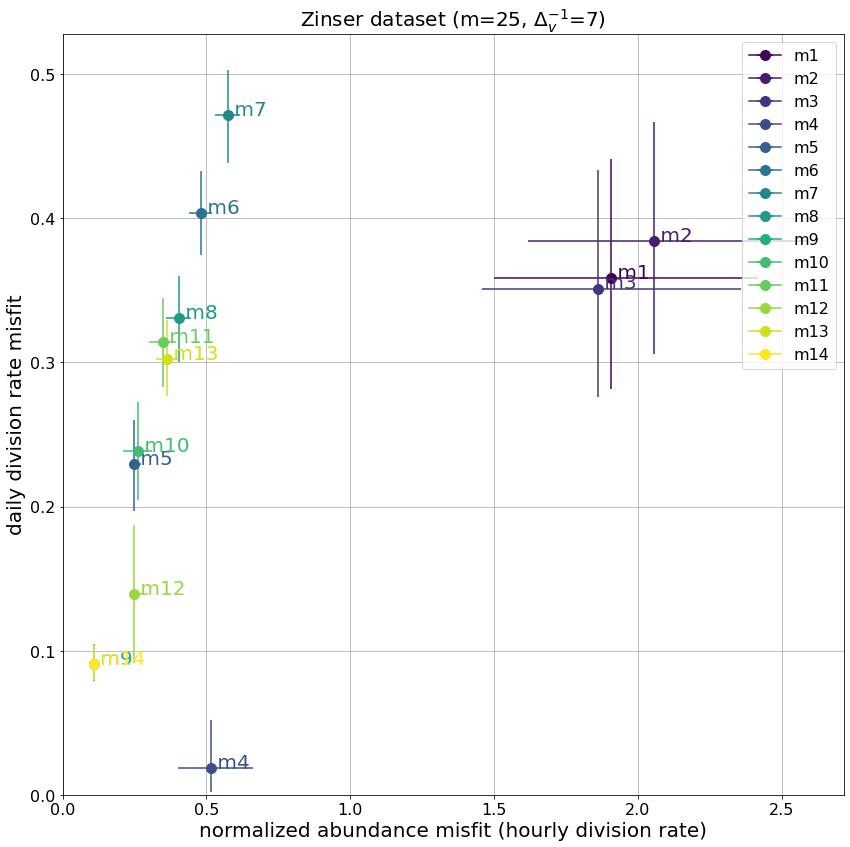

In [14]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')
t_zinser = data_fig2a['exper time'] * 60
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # make sure the time is right, if not implement something fancier
            assert all(t_zinser.values[:-1] == data[dataname]['t_obs'])
            
            # misfit to normalized abundance
            
            e0 = np.mean(np.abs(np.sum(mcmcs[model][dataname]['mod_obspos'], axis=1)[:,1:]-ab_mean_norm[1:-1]), axis=1)
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='normalized abundance misfit (hourly division rate)', ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

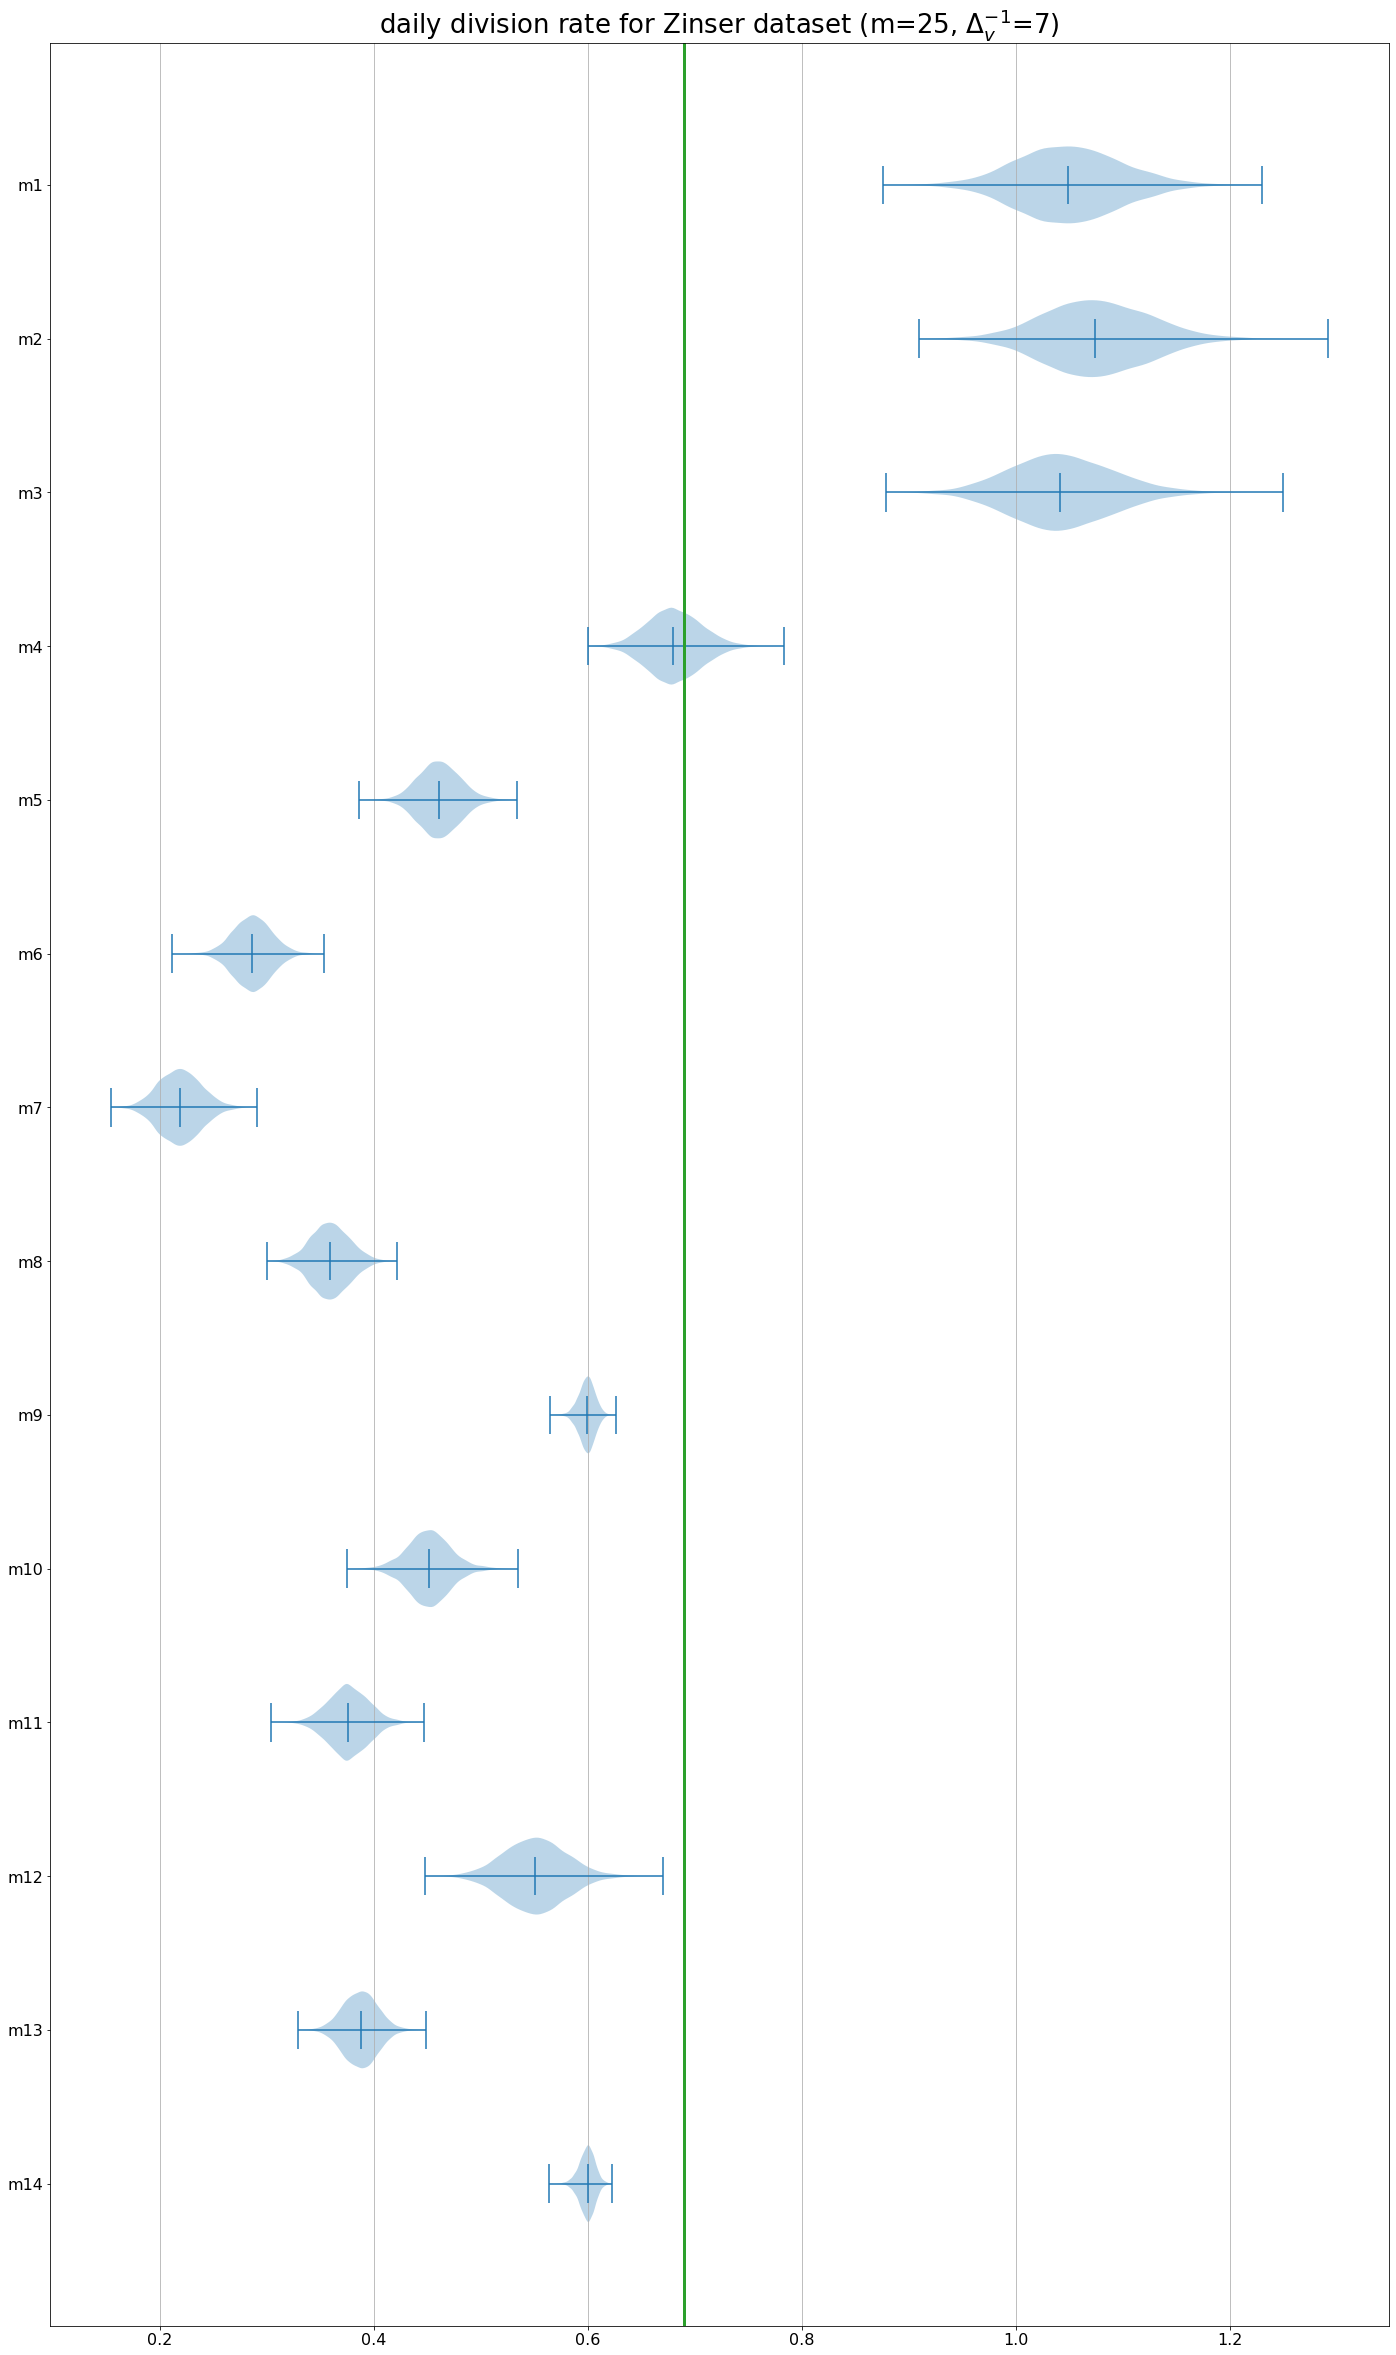

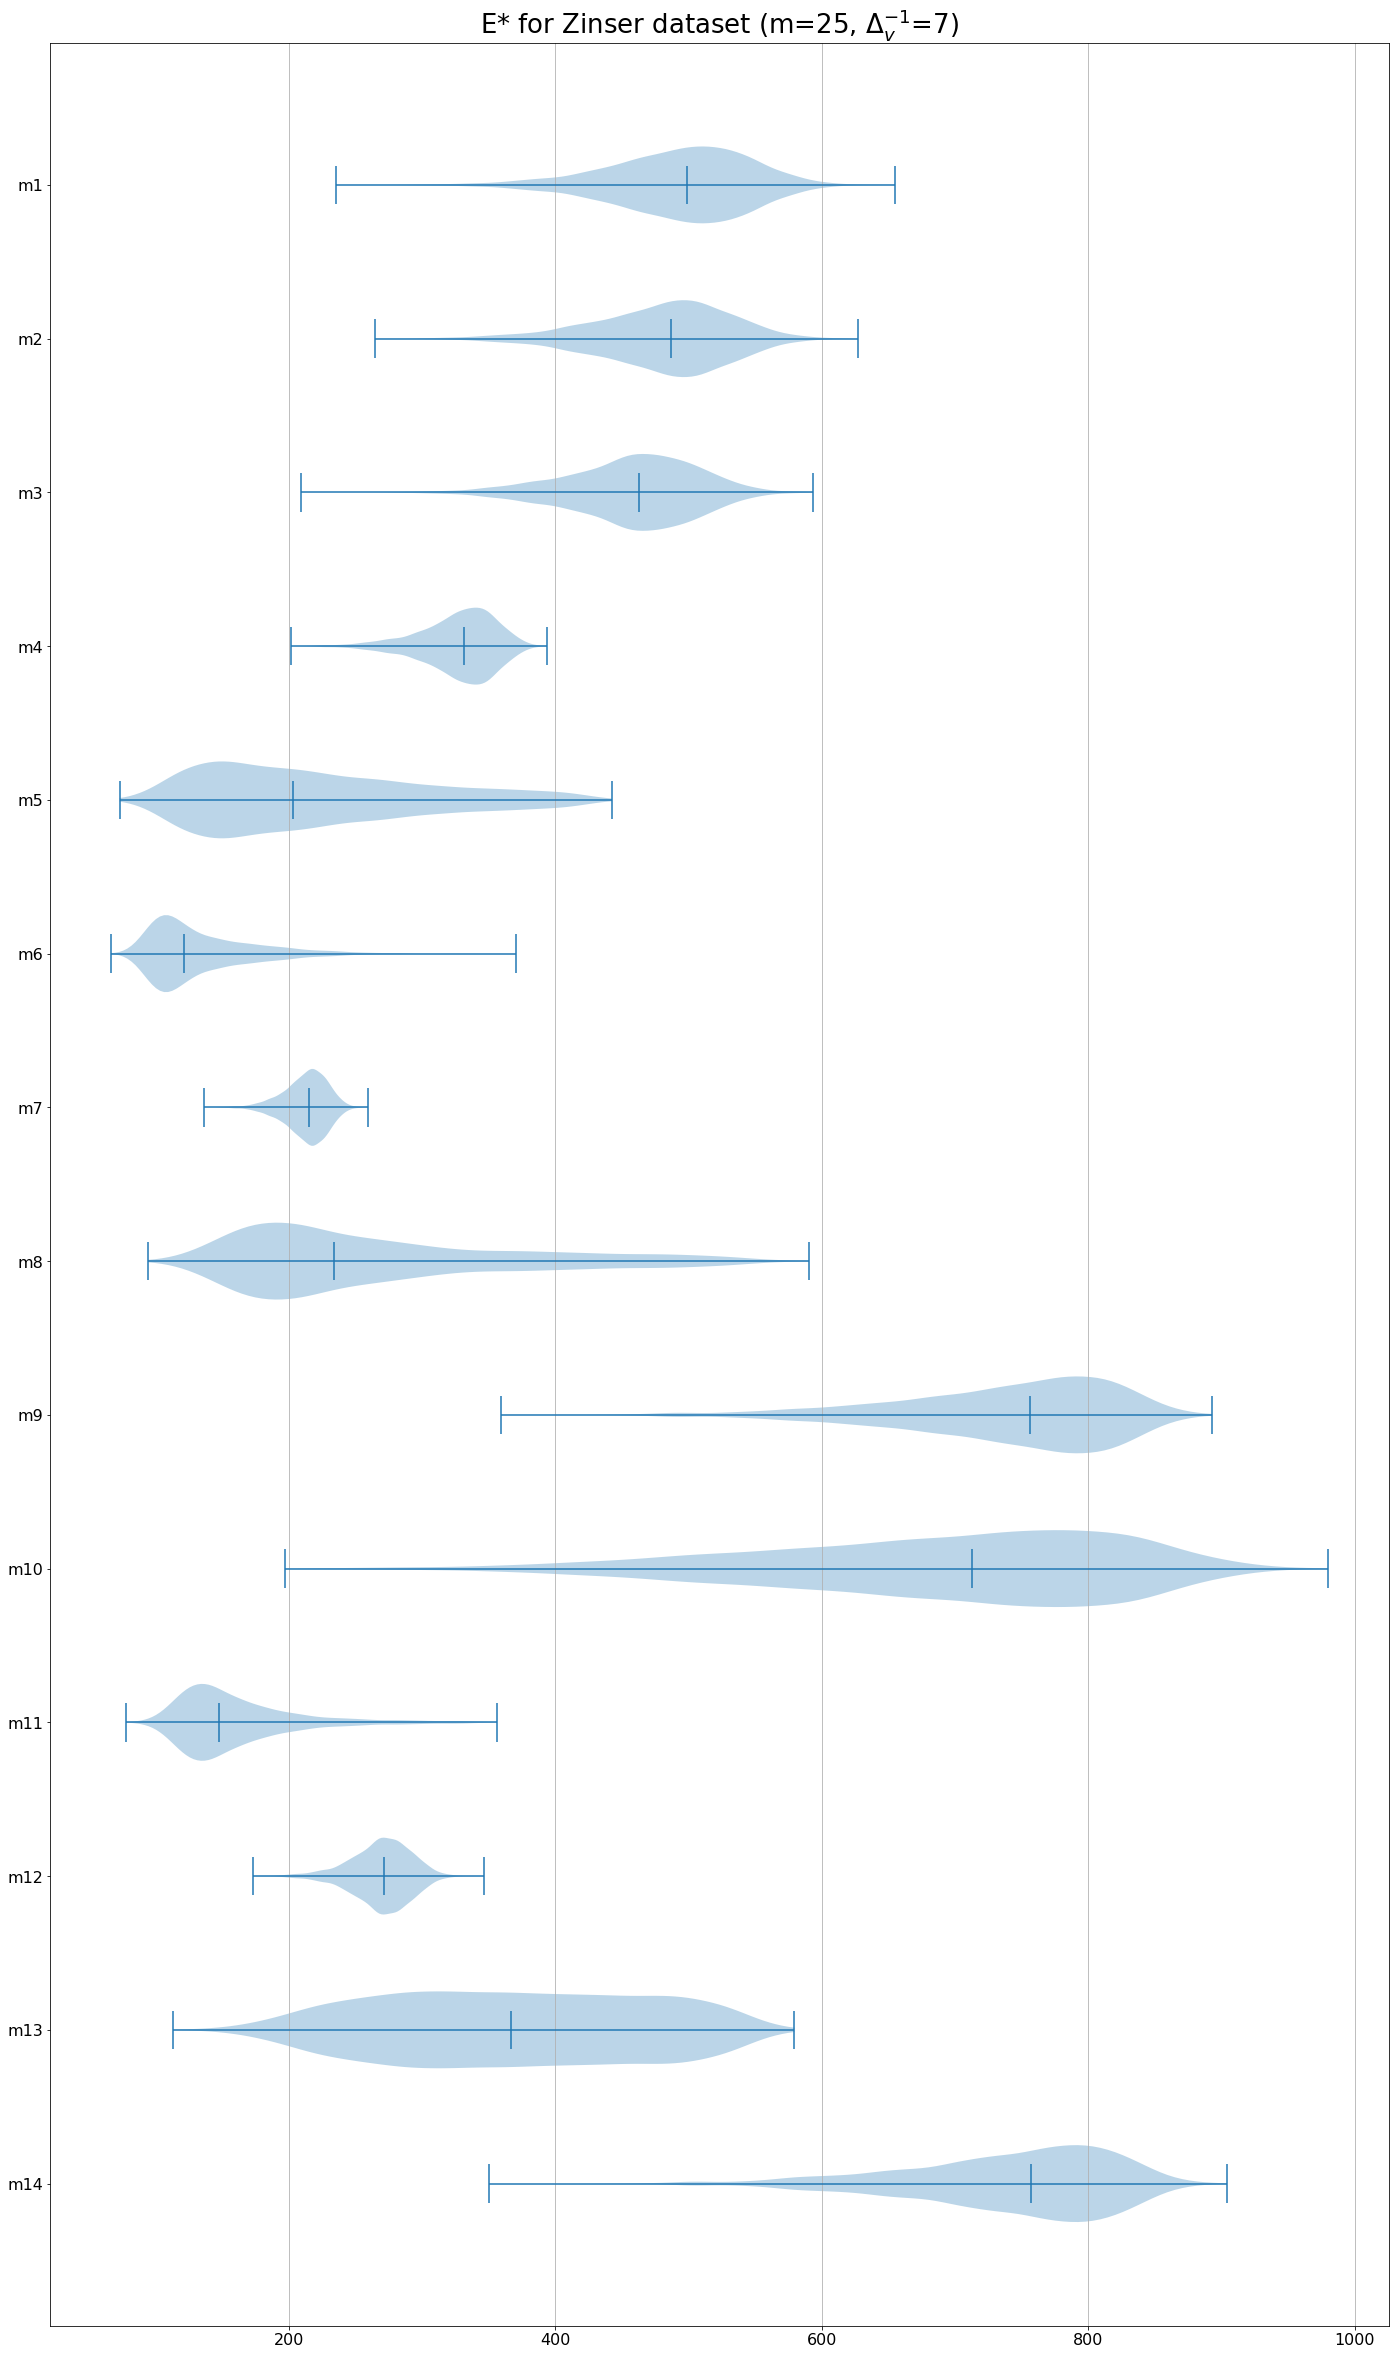

In [15]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[model][dataname][param] for model in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[model].replace(',',',\n') for model in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,model in enumerate(mcmcs):
            if maxrhats_final[model][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

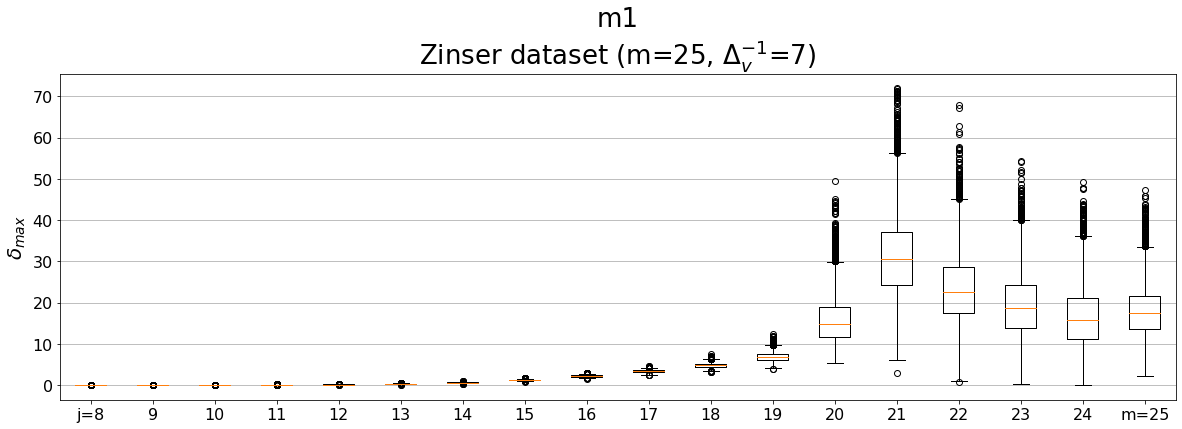

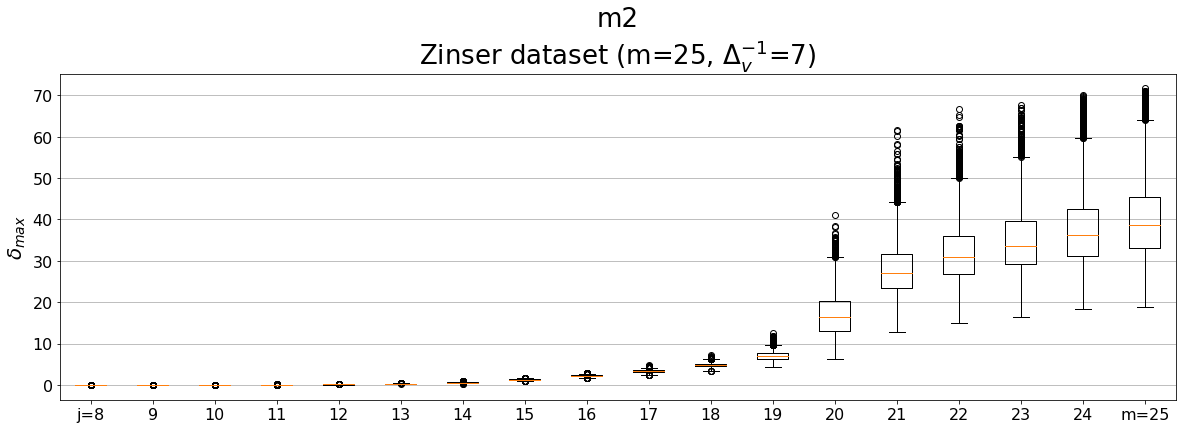

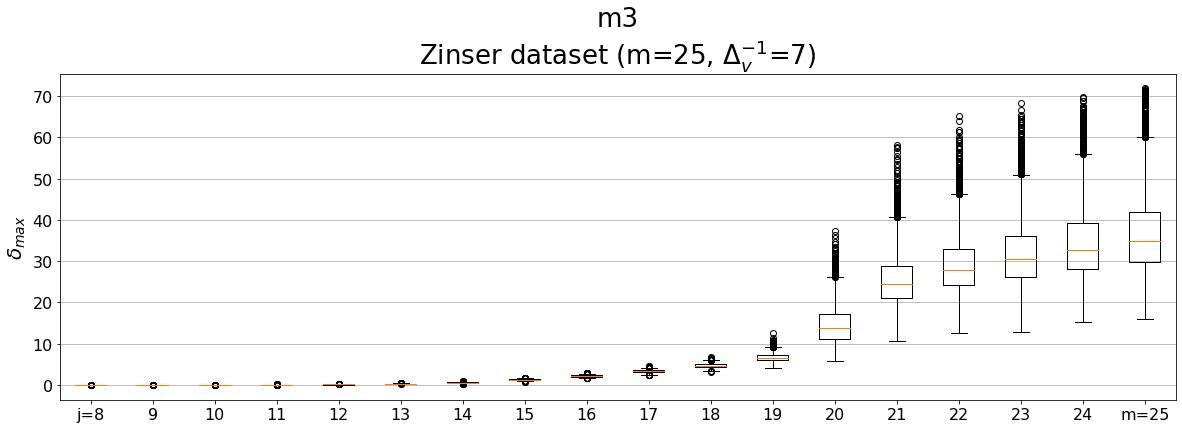

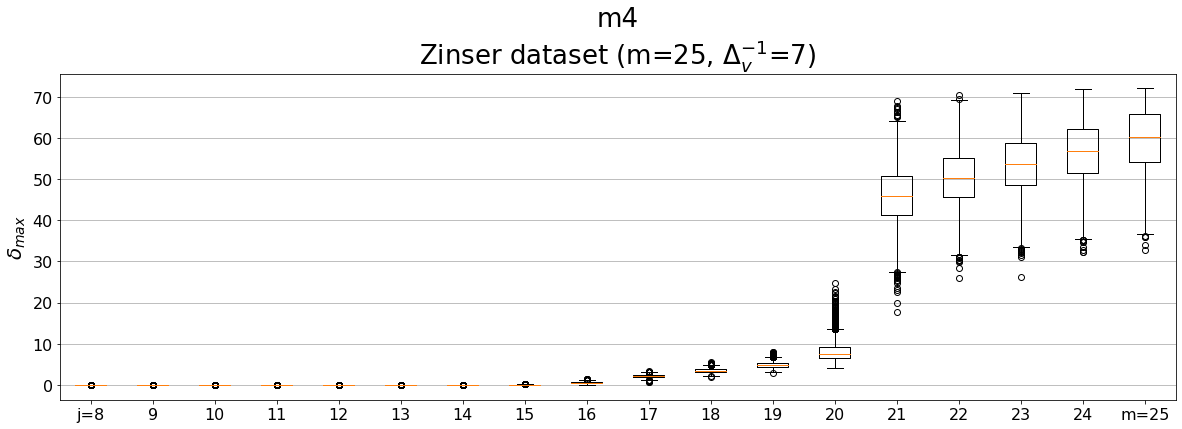

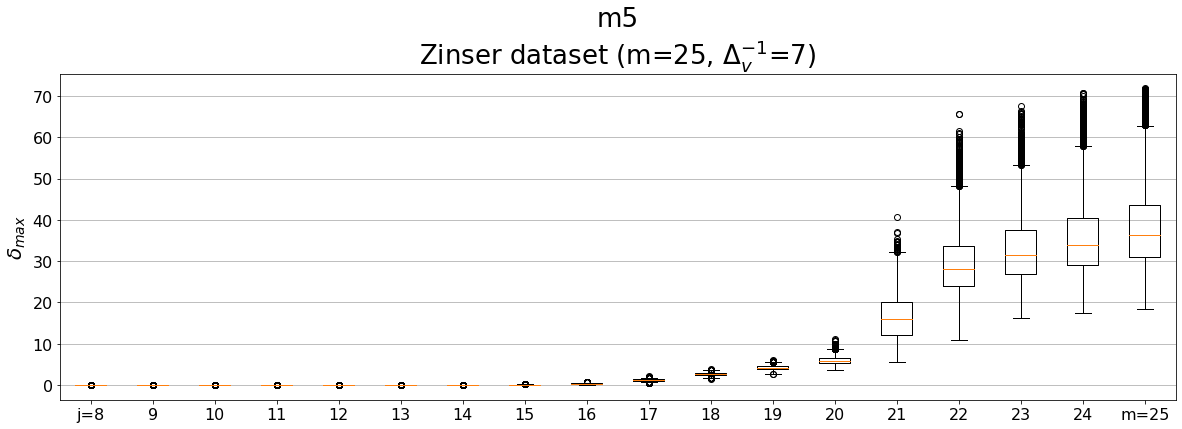

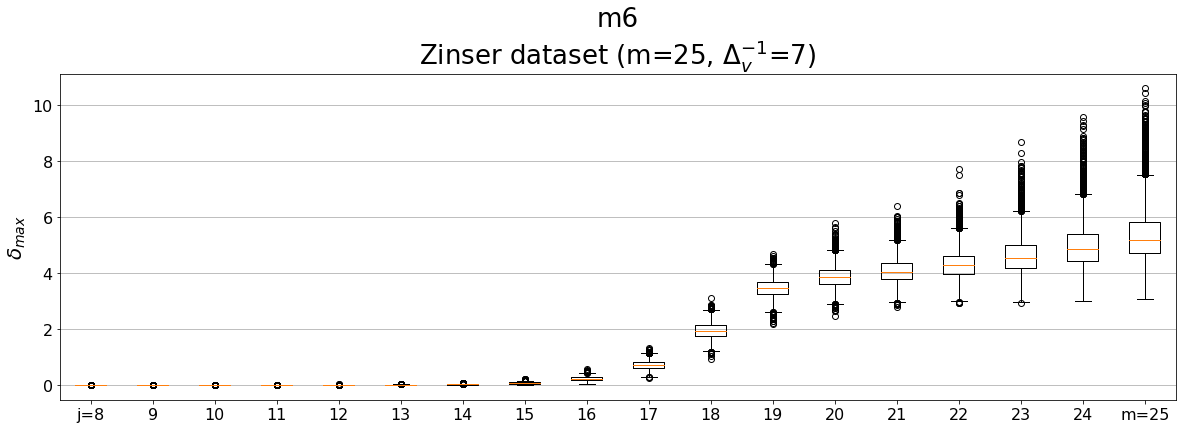

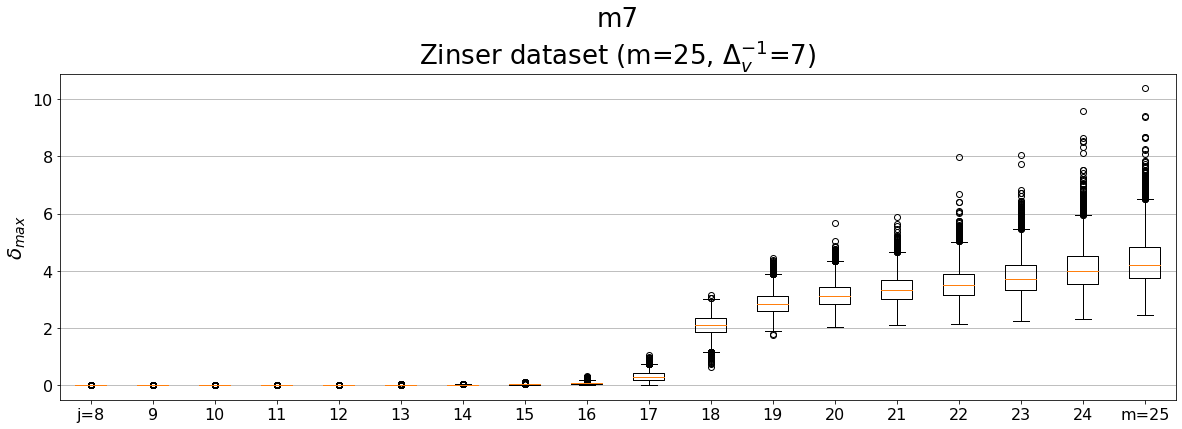

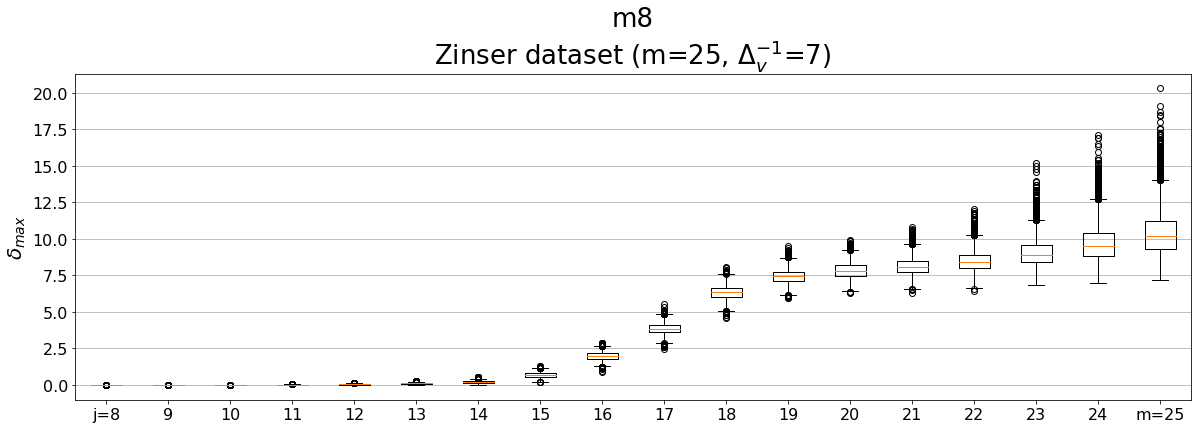

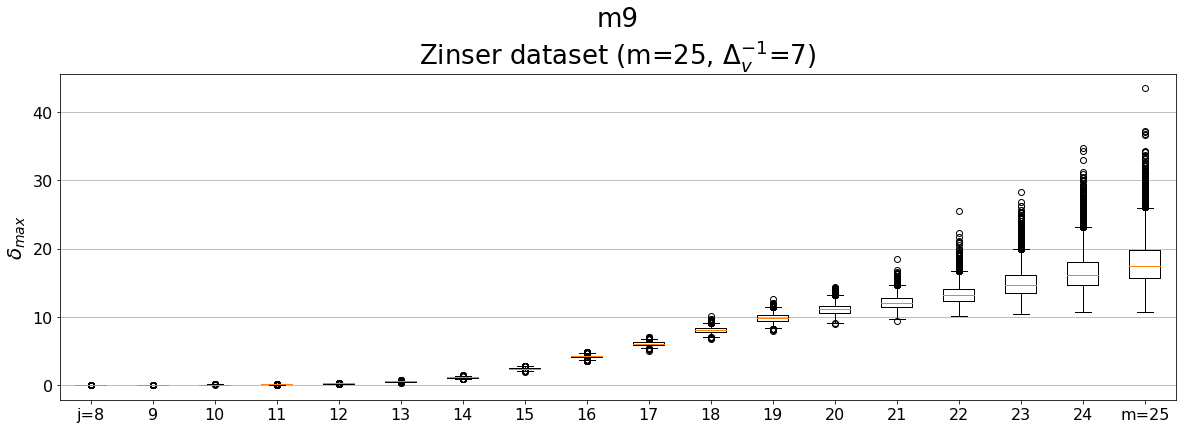

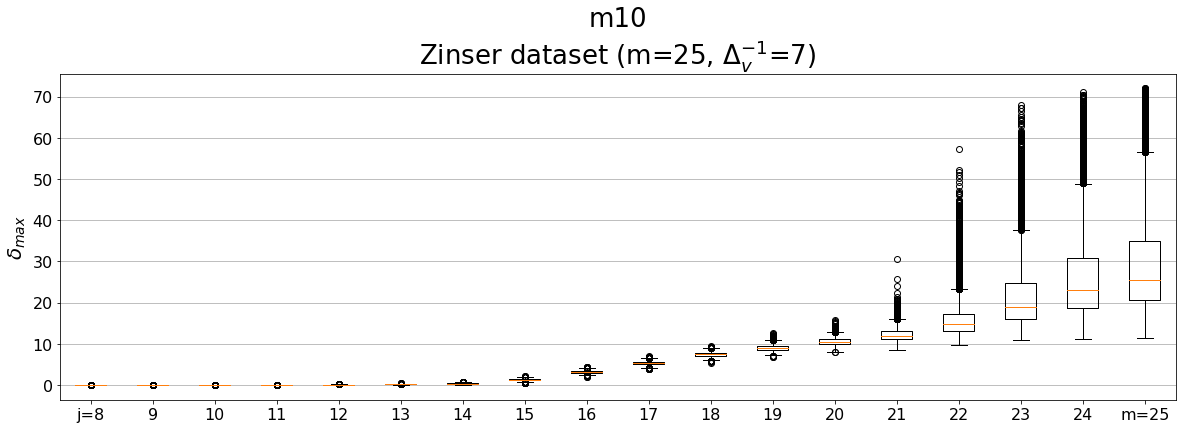

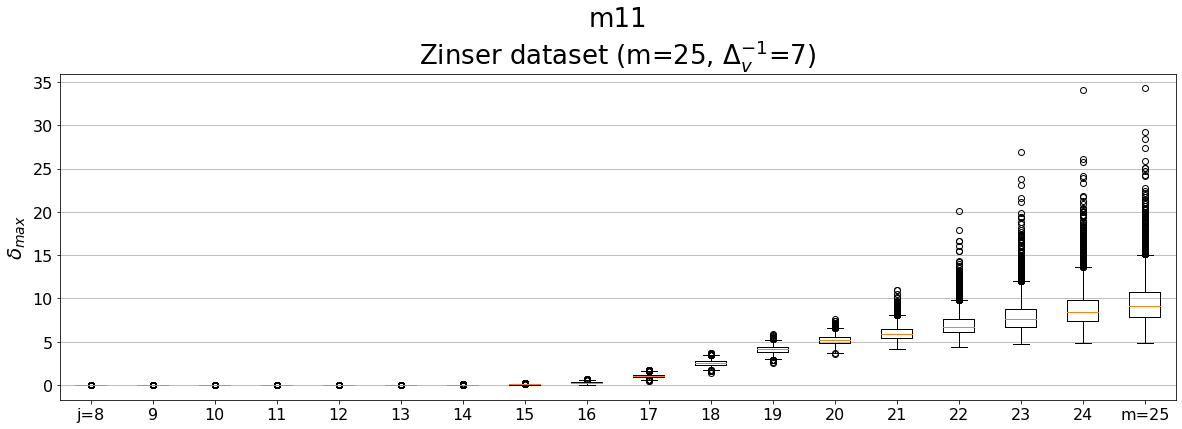

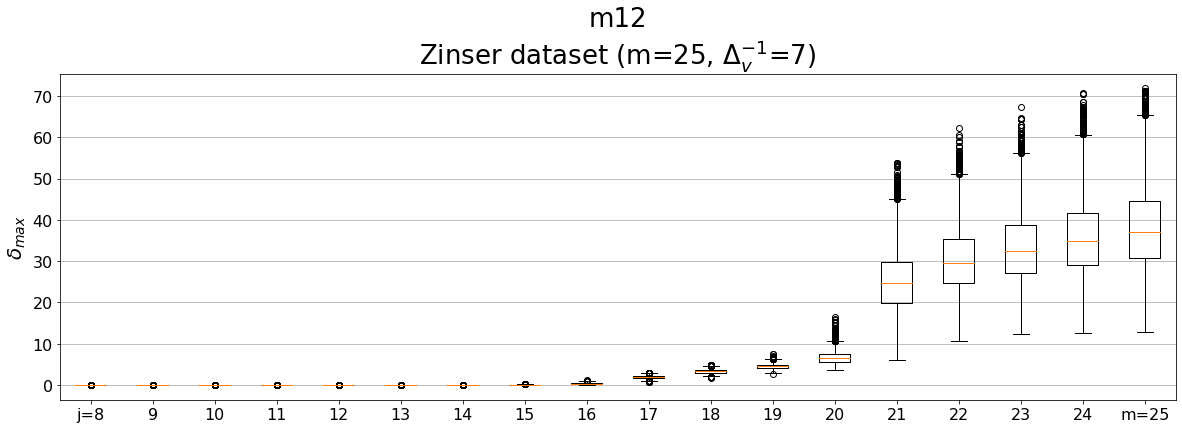

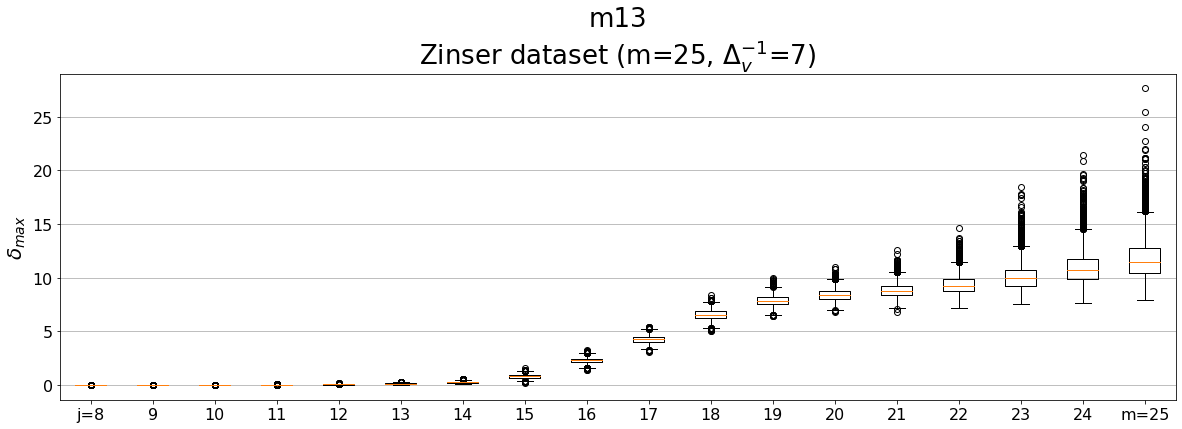

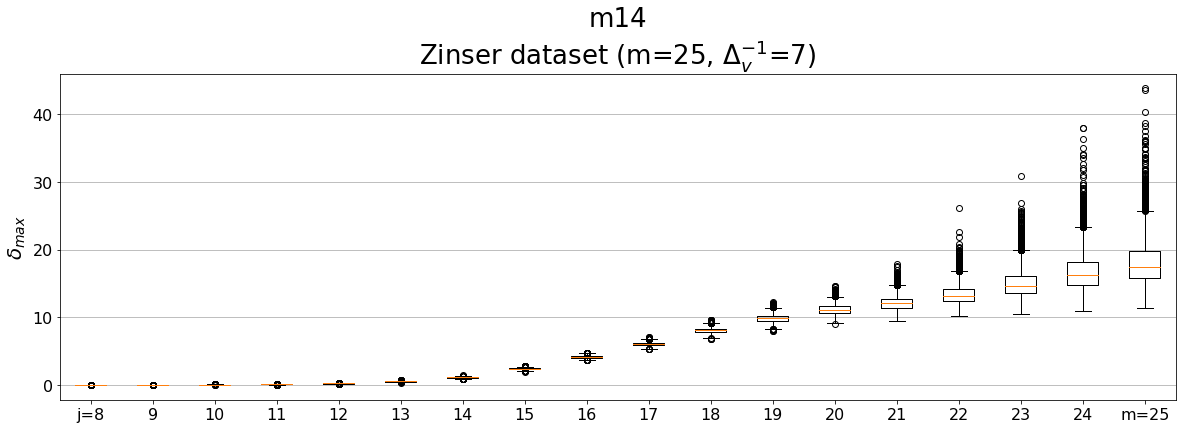

In [16]:
for dataname in data:
    for model,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[model] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

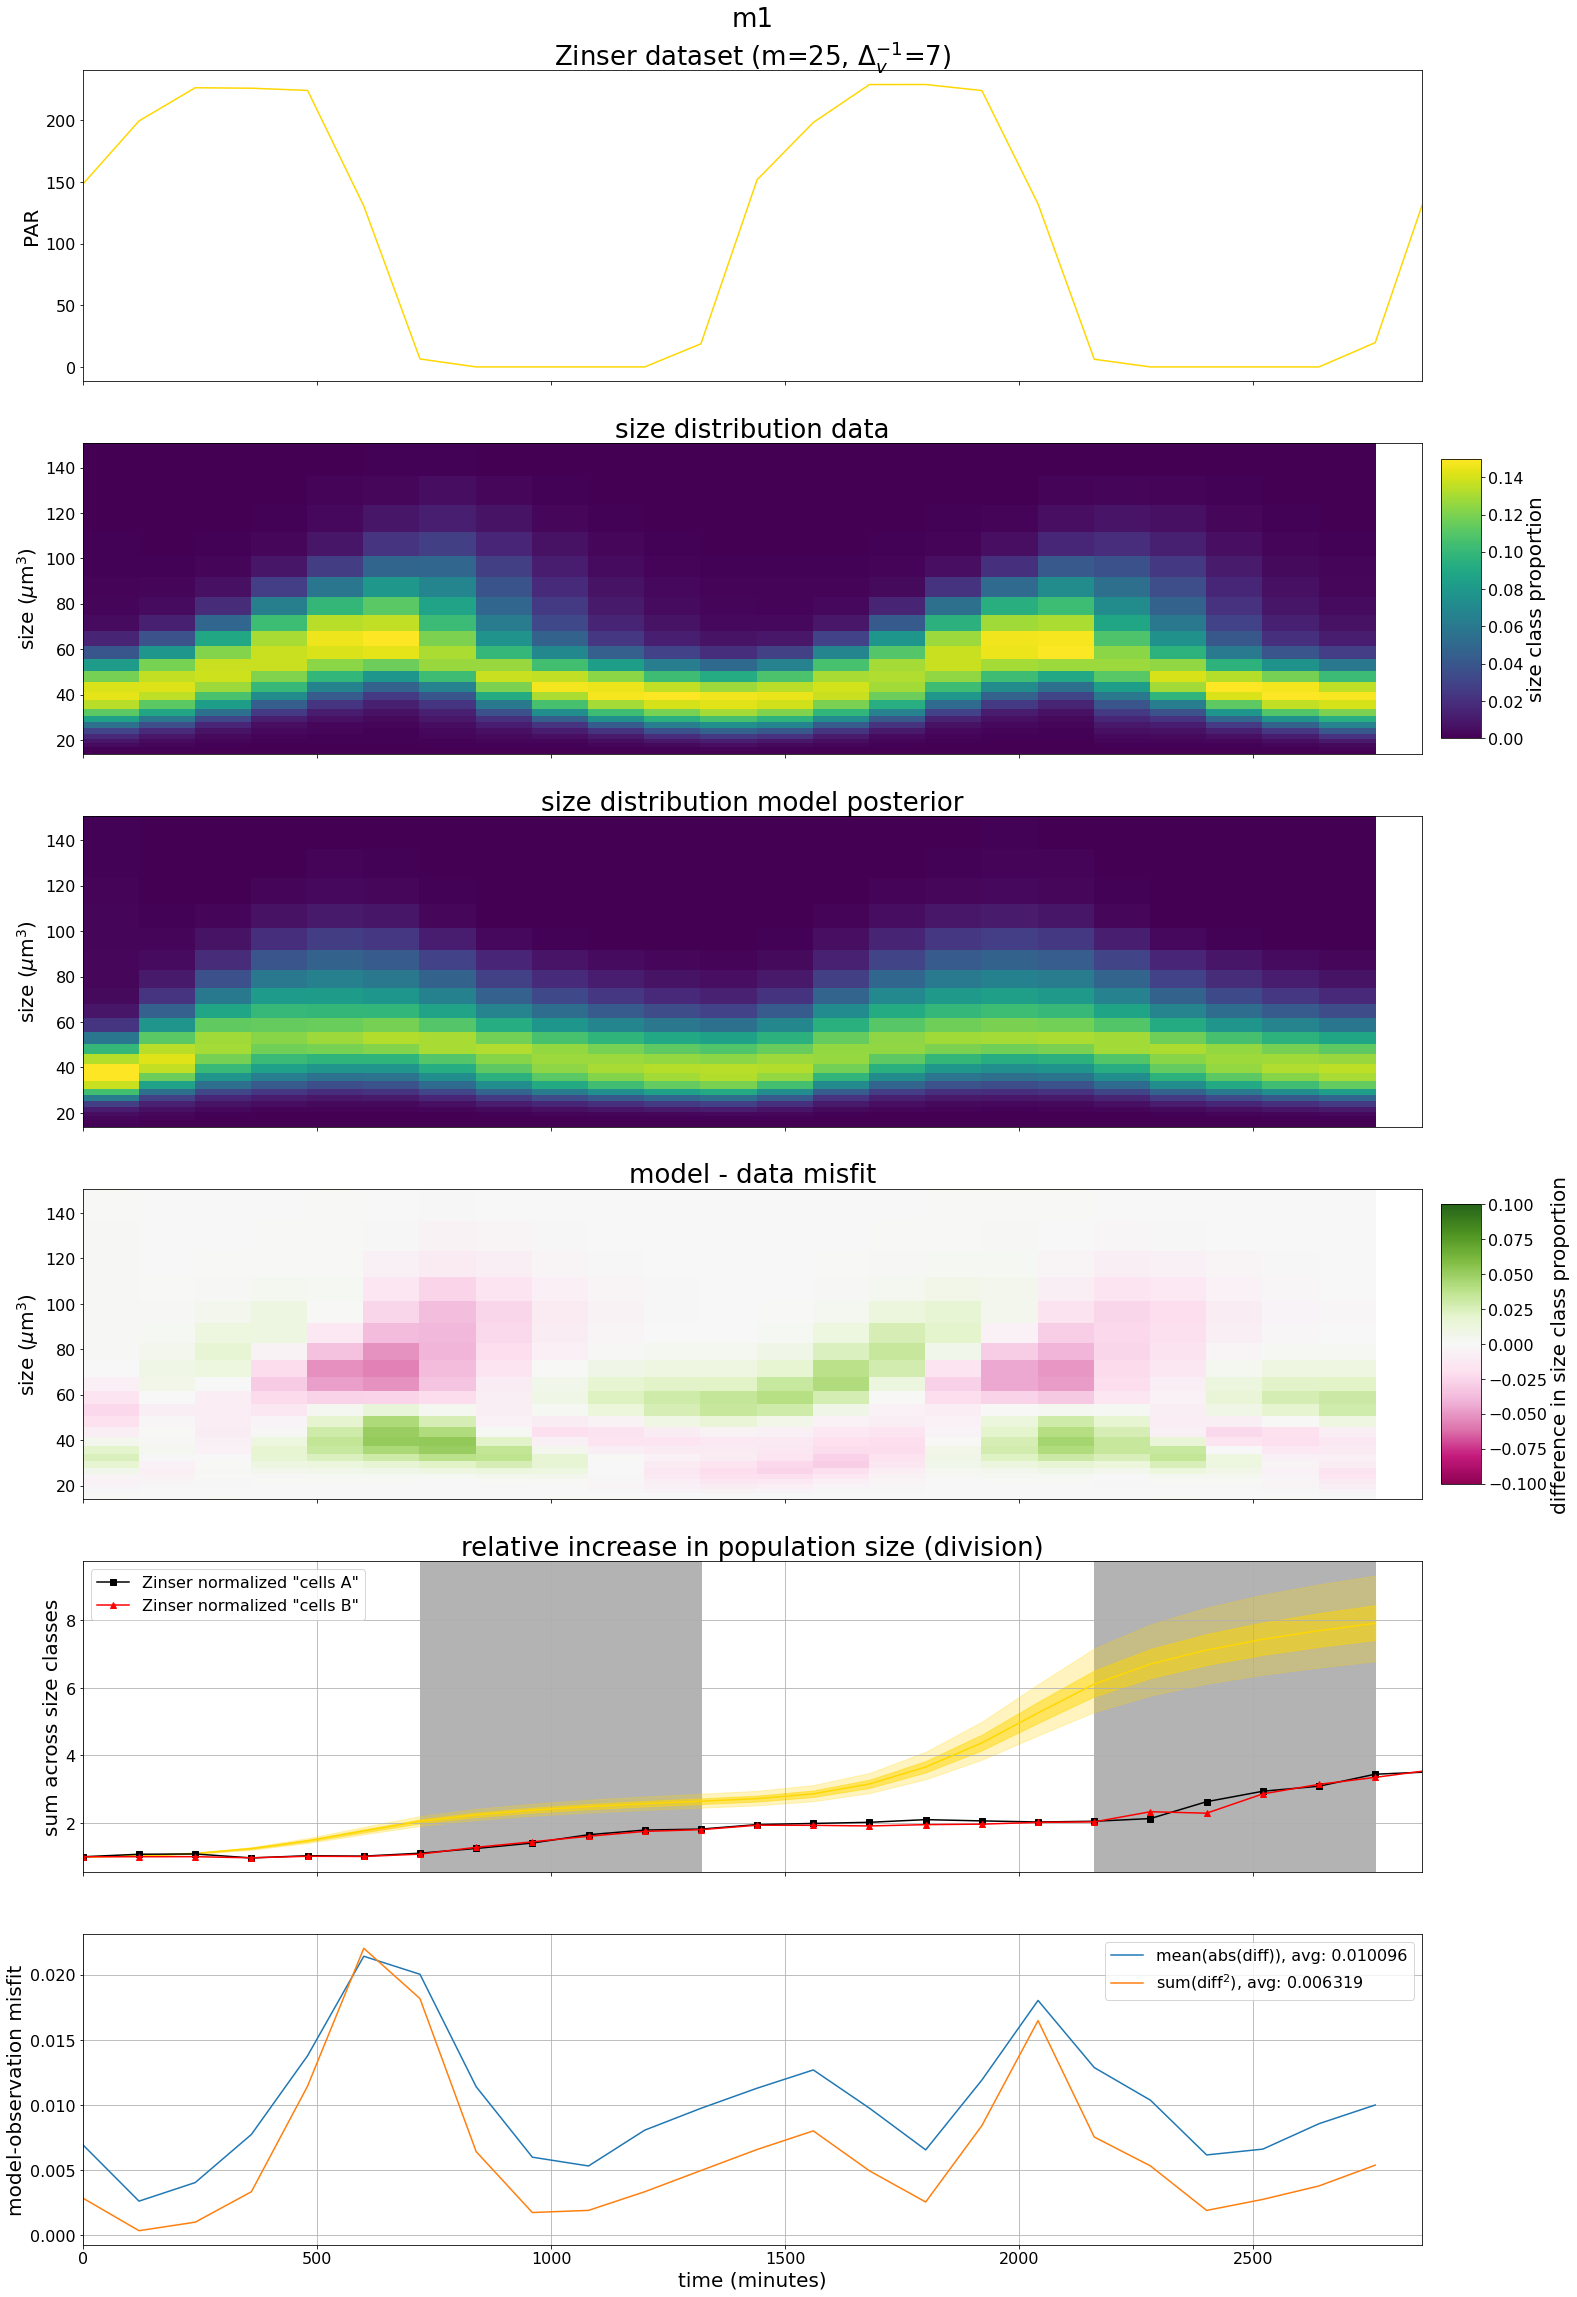

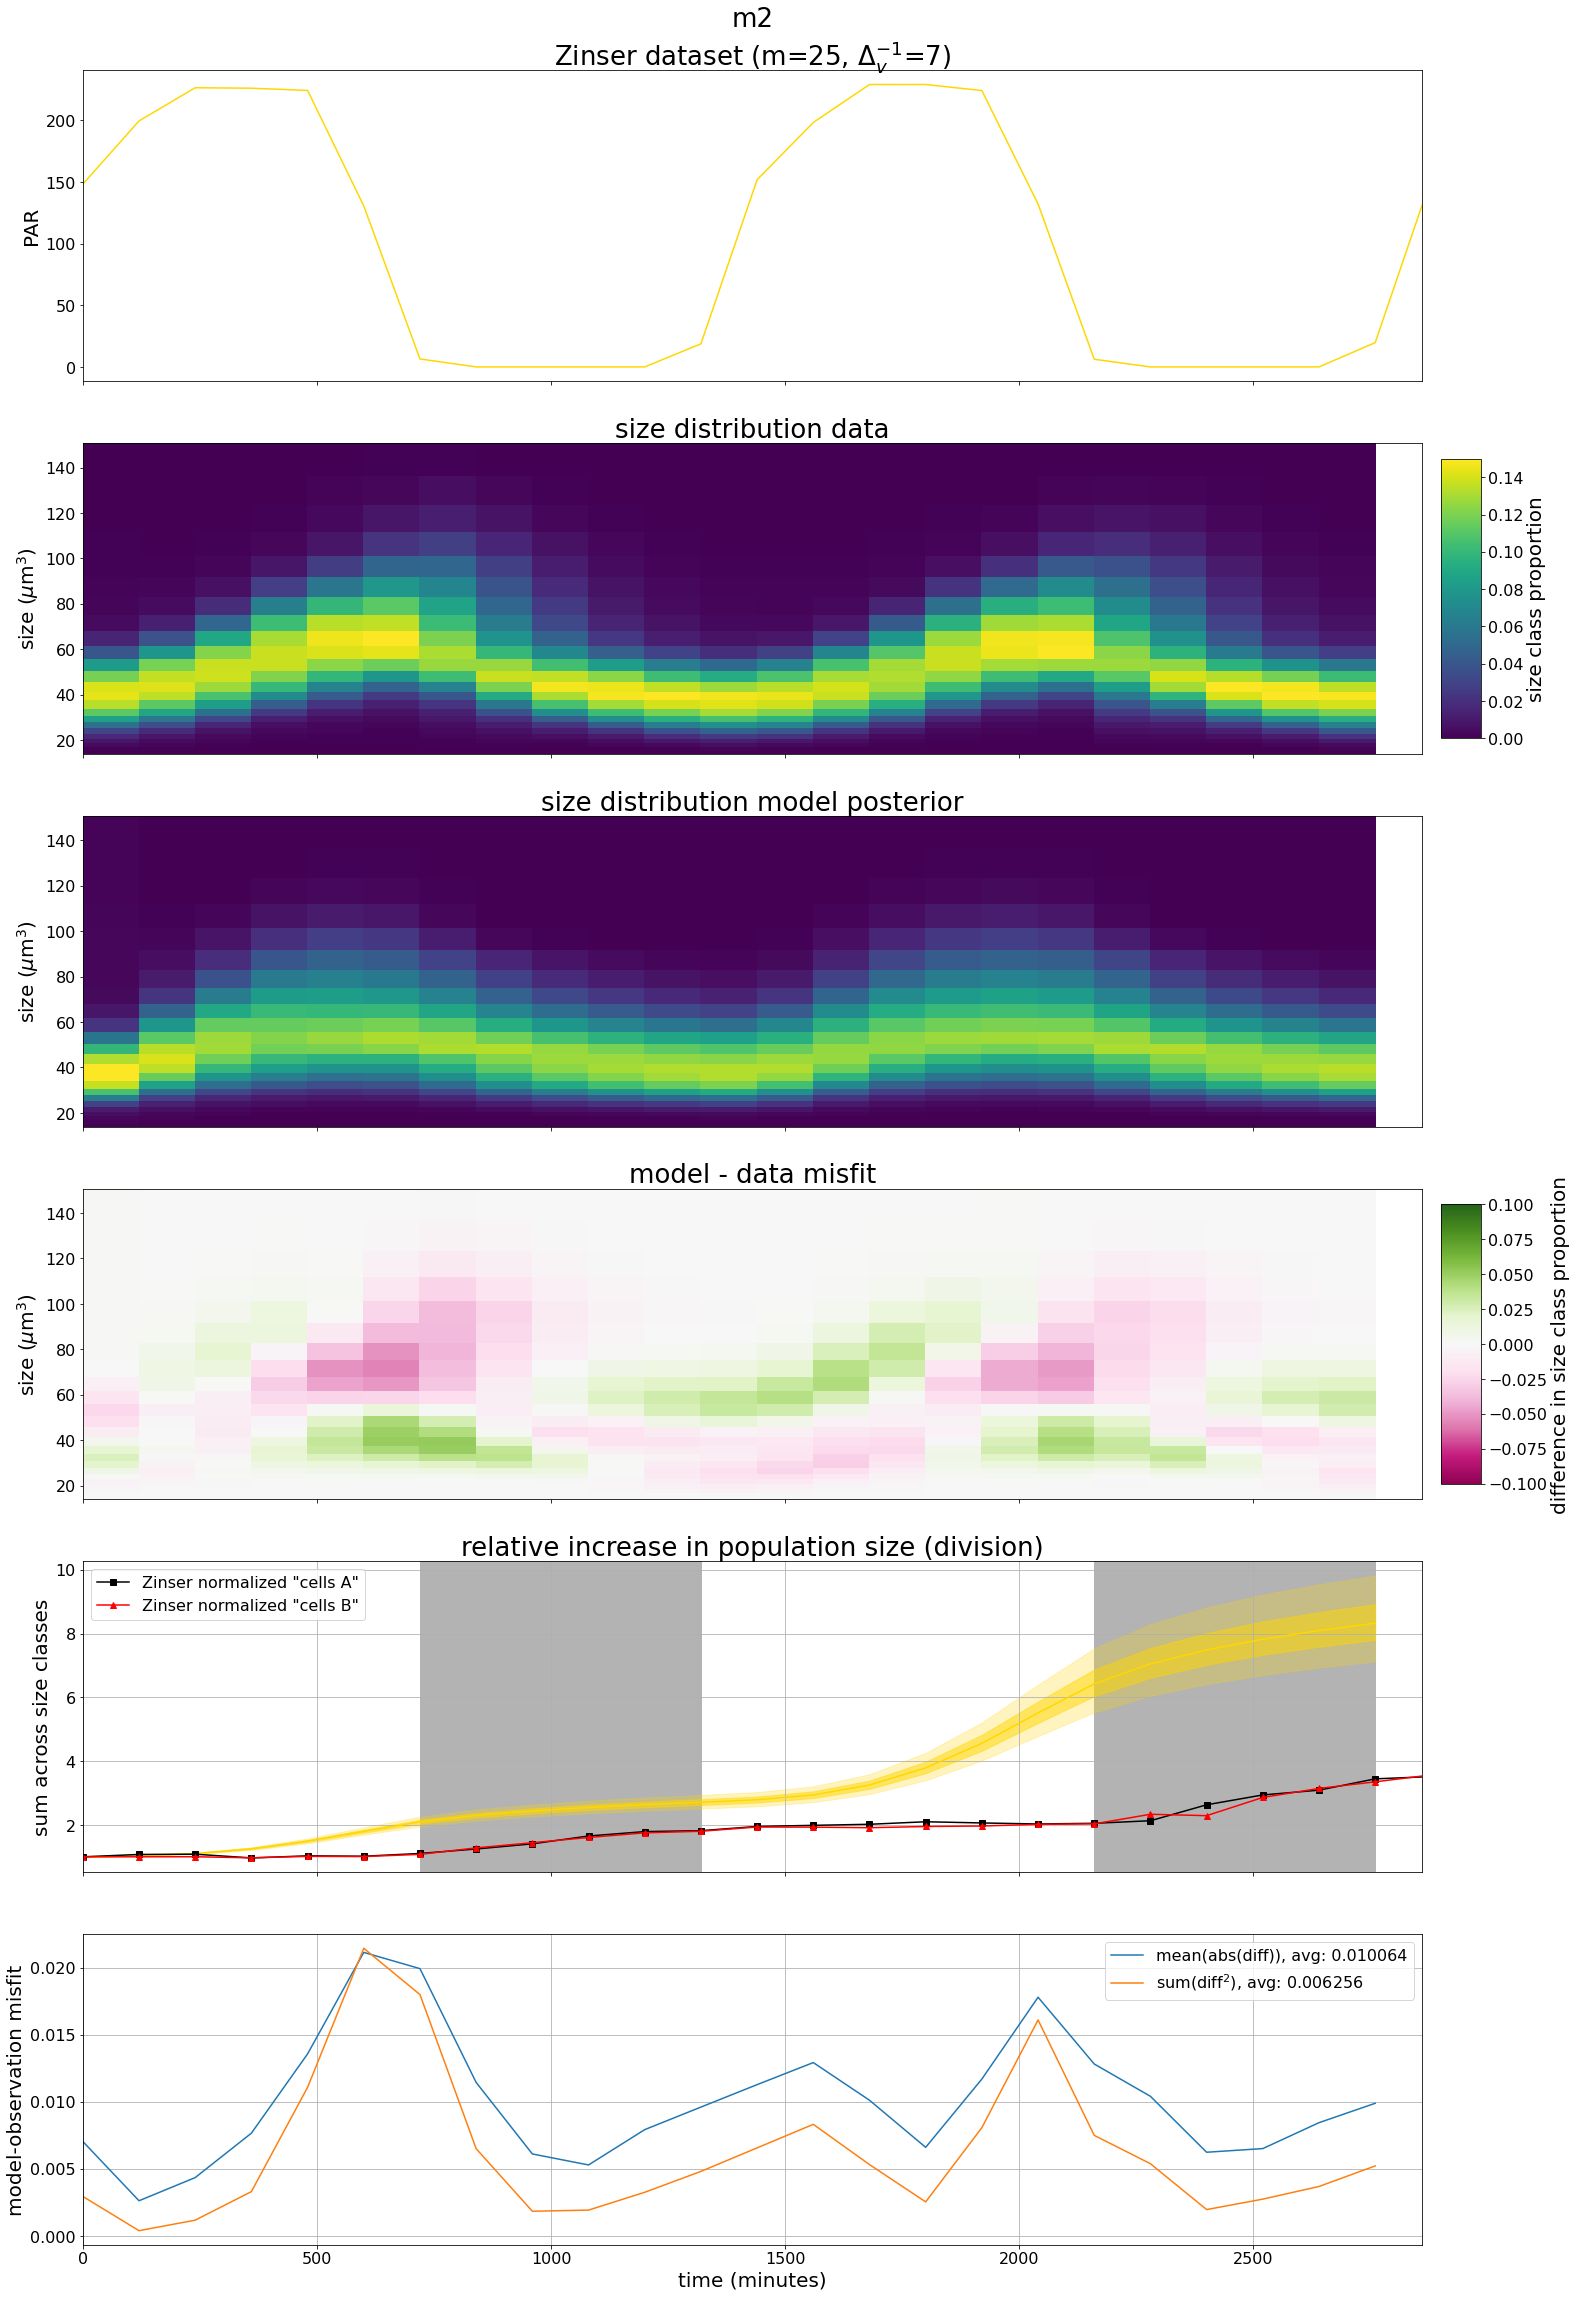

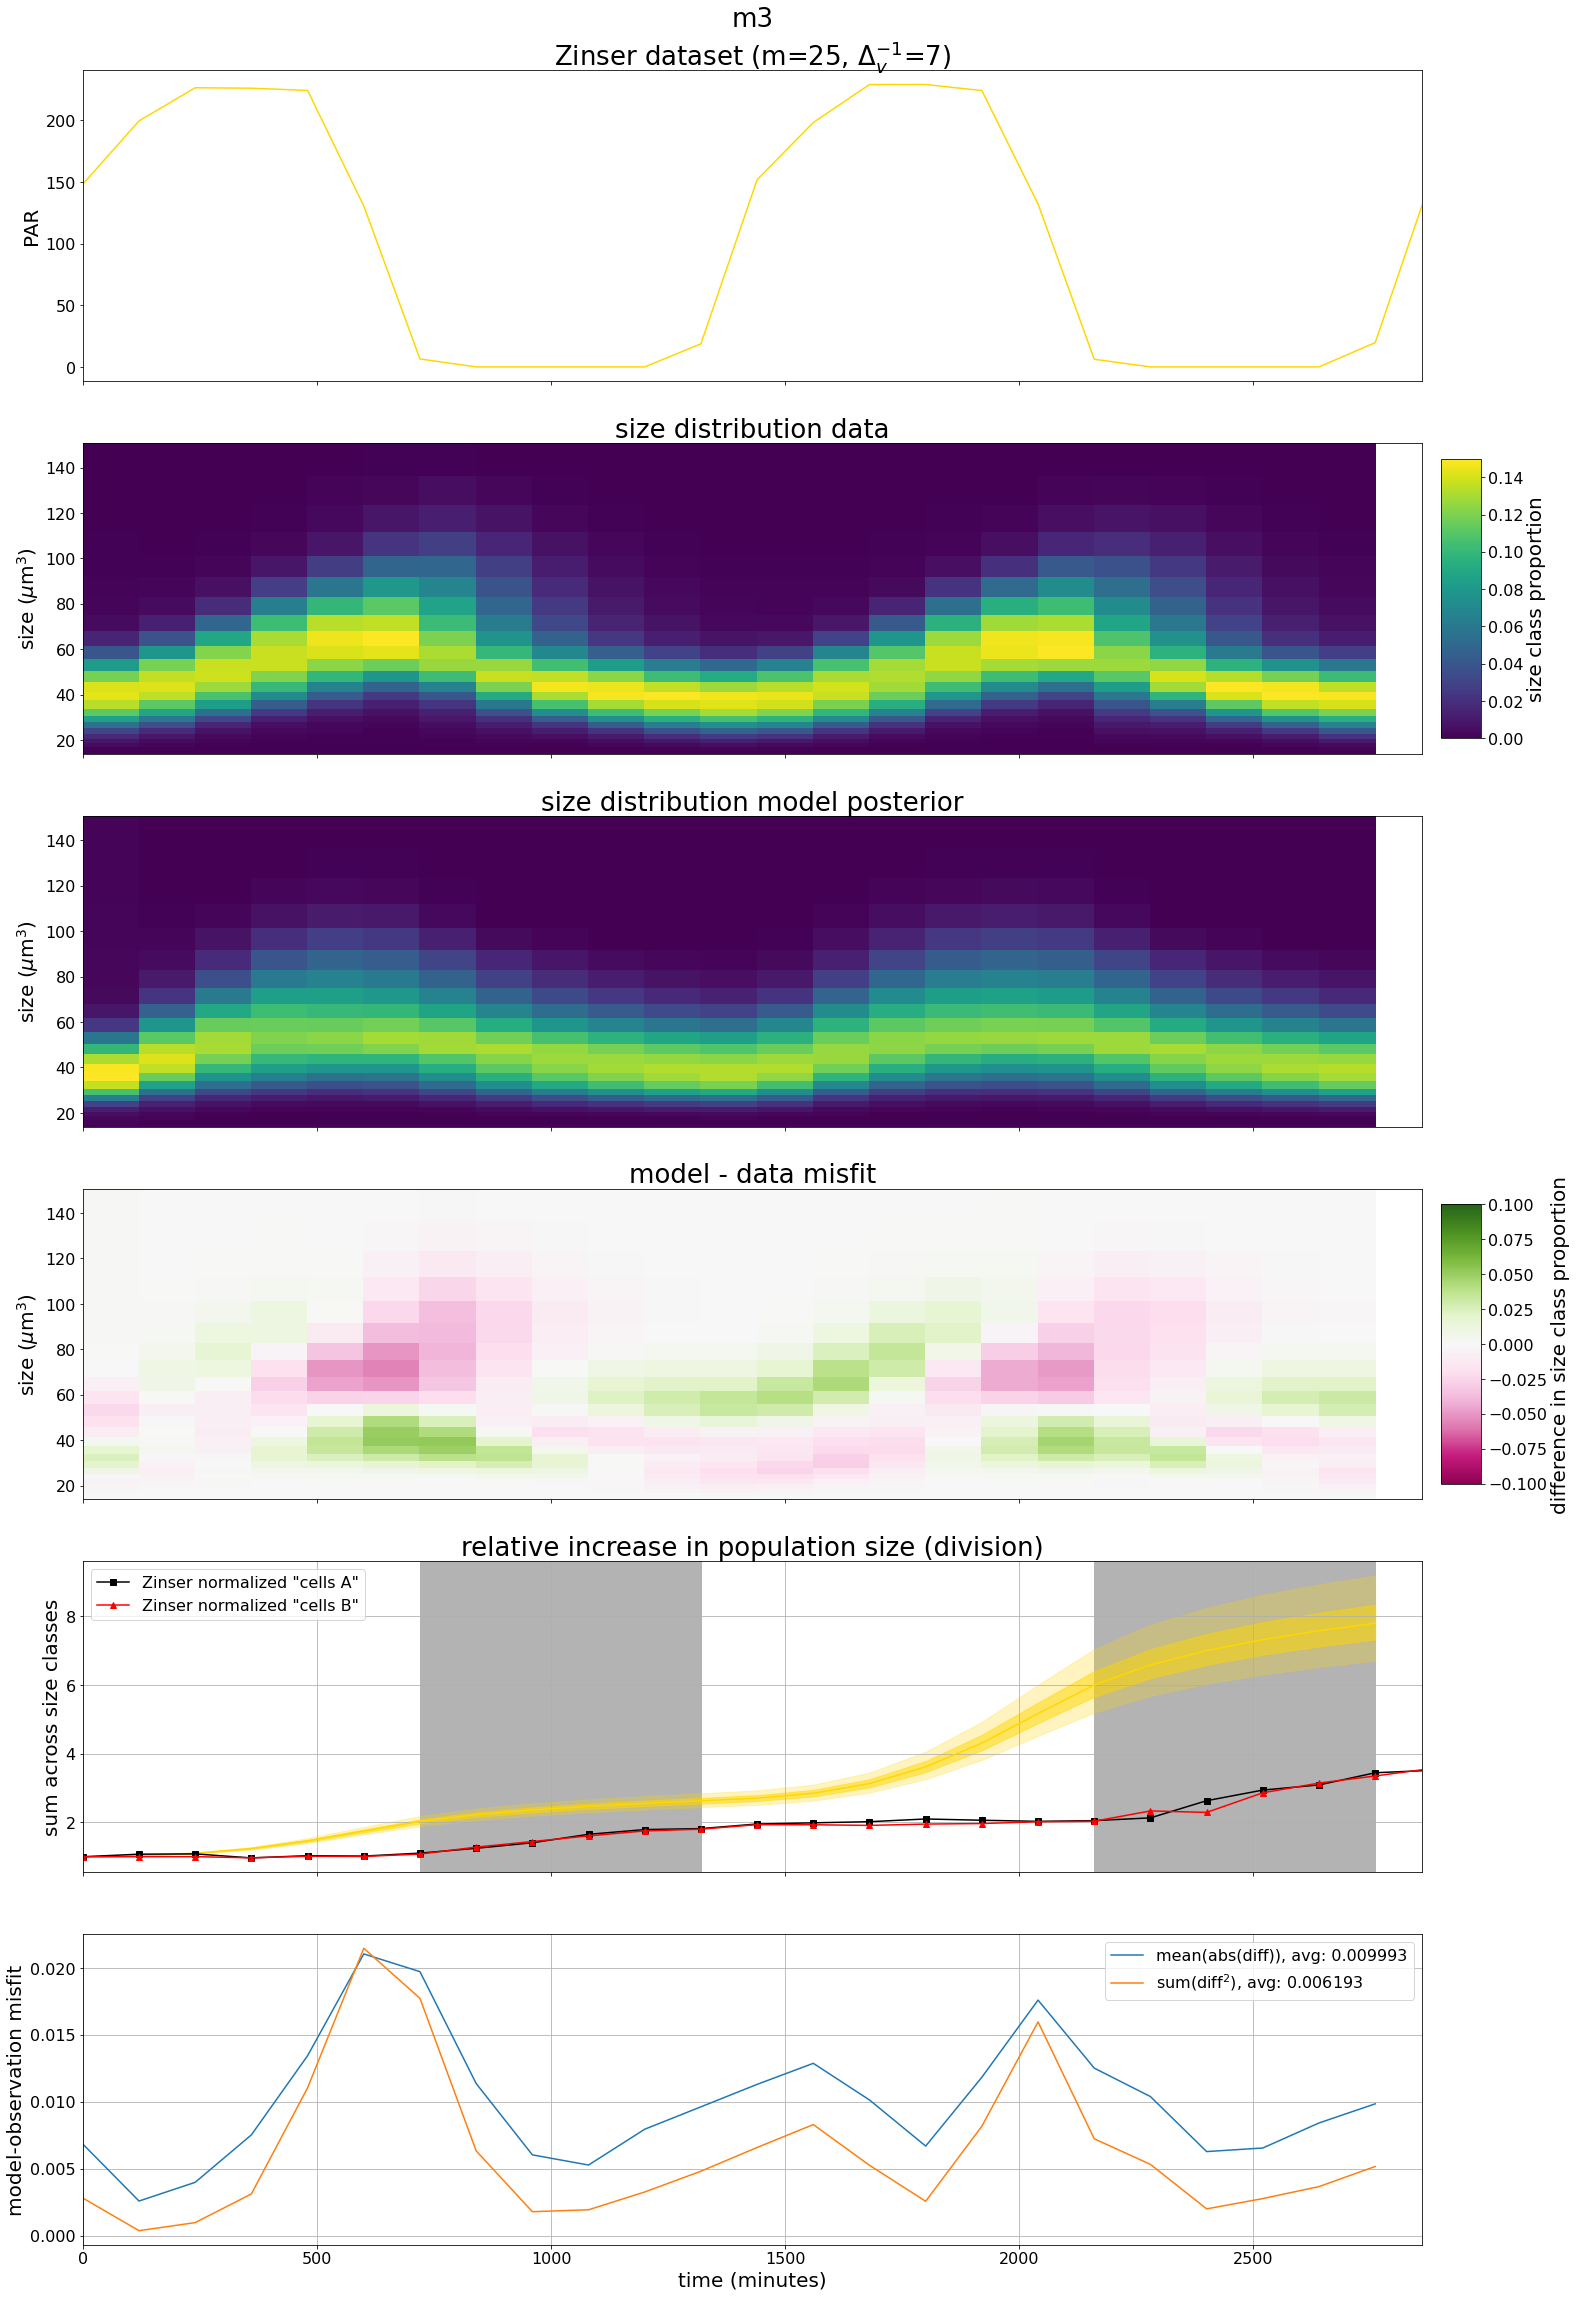

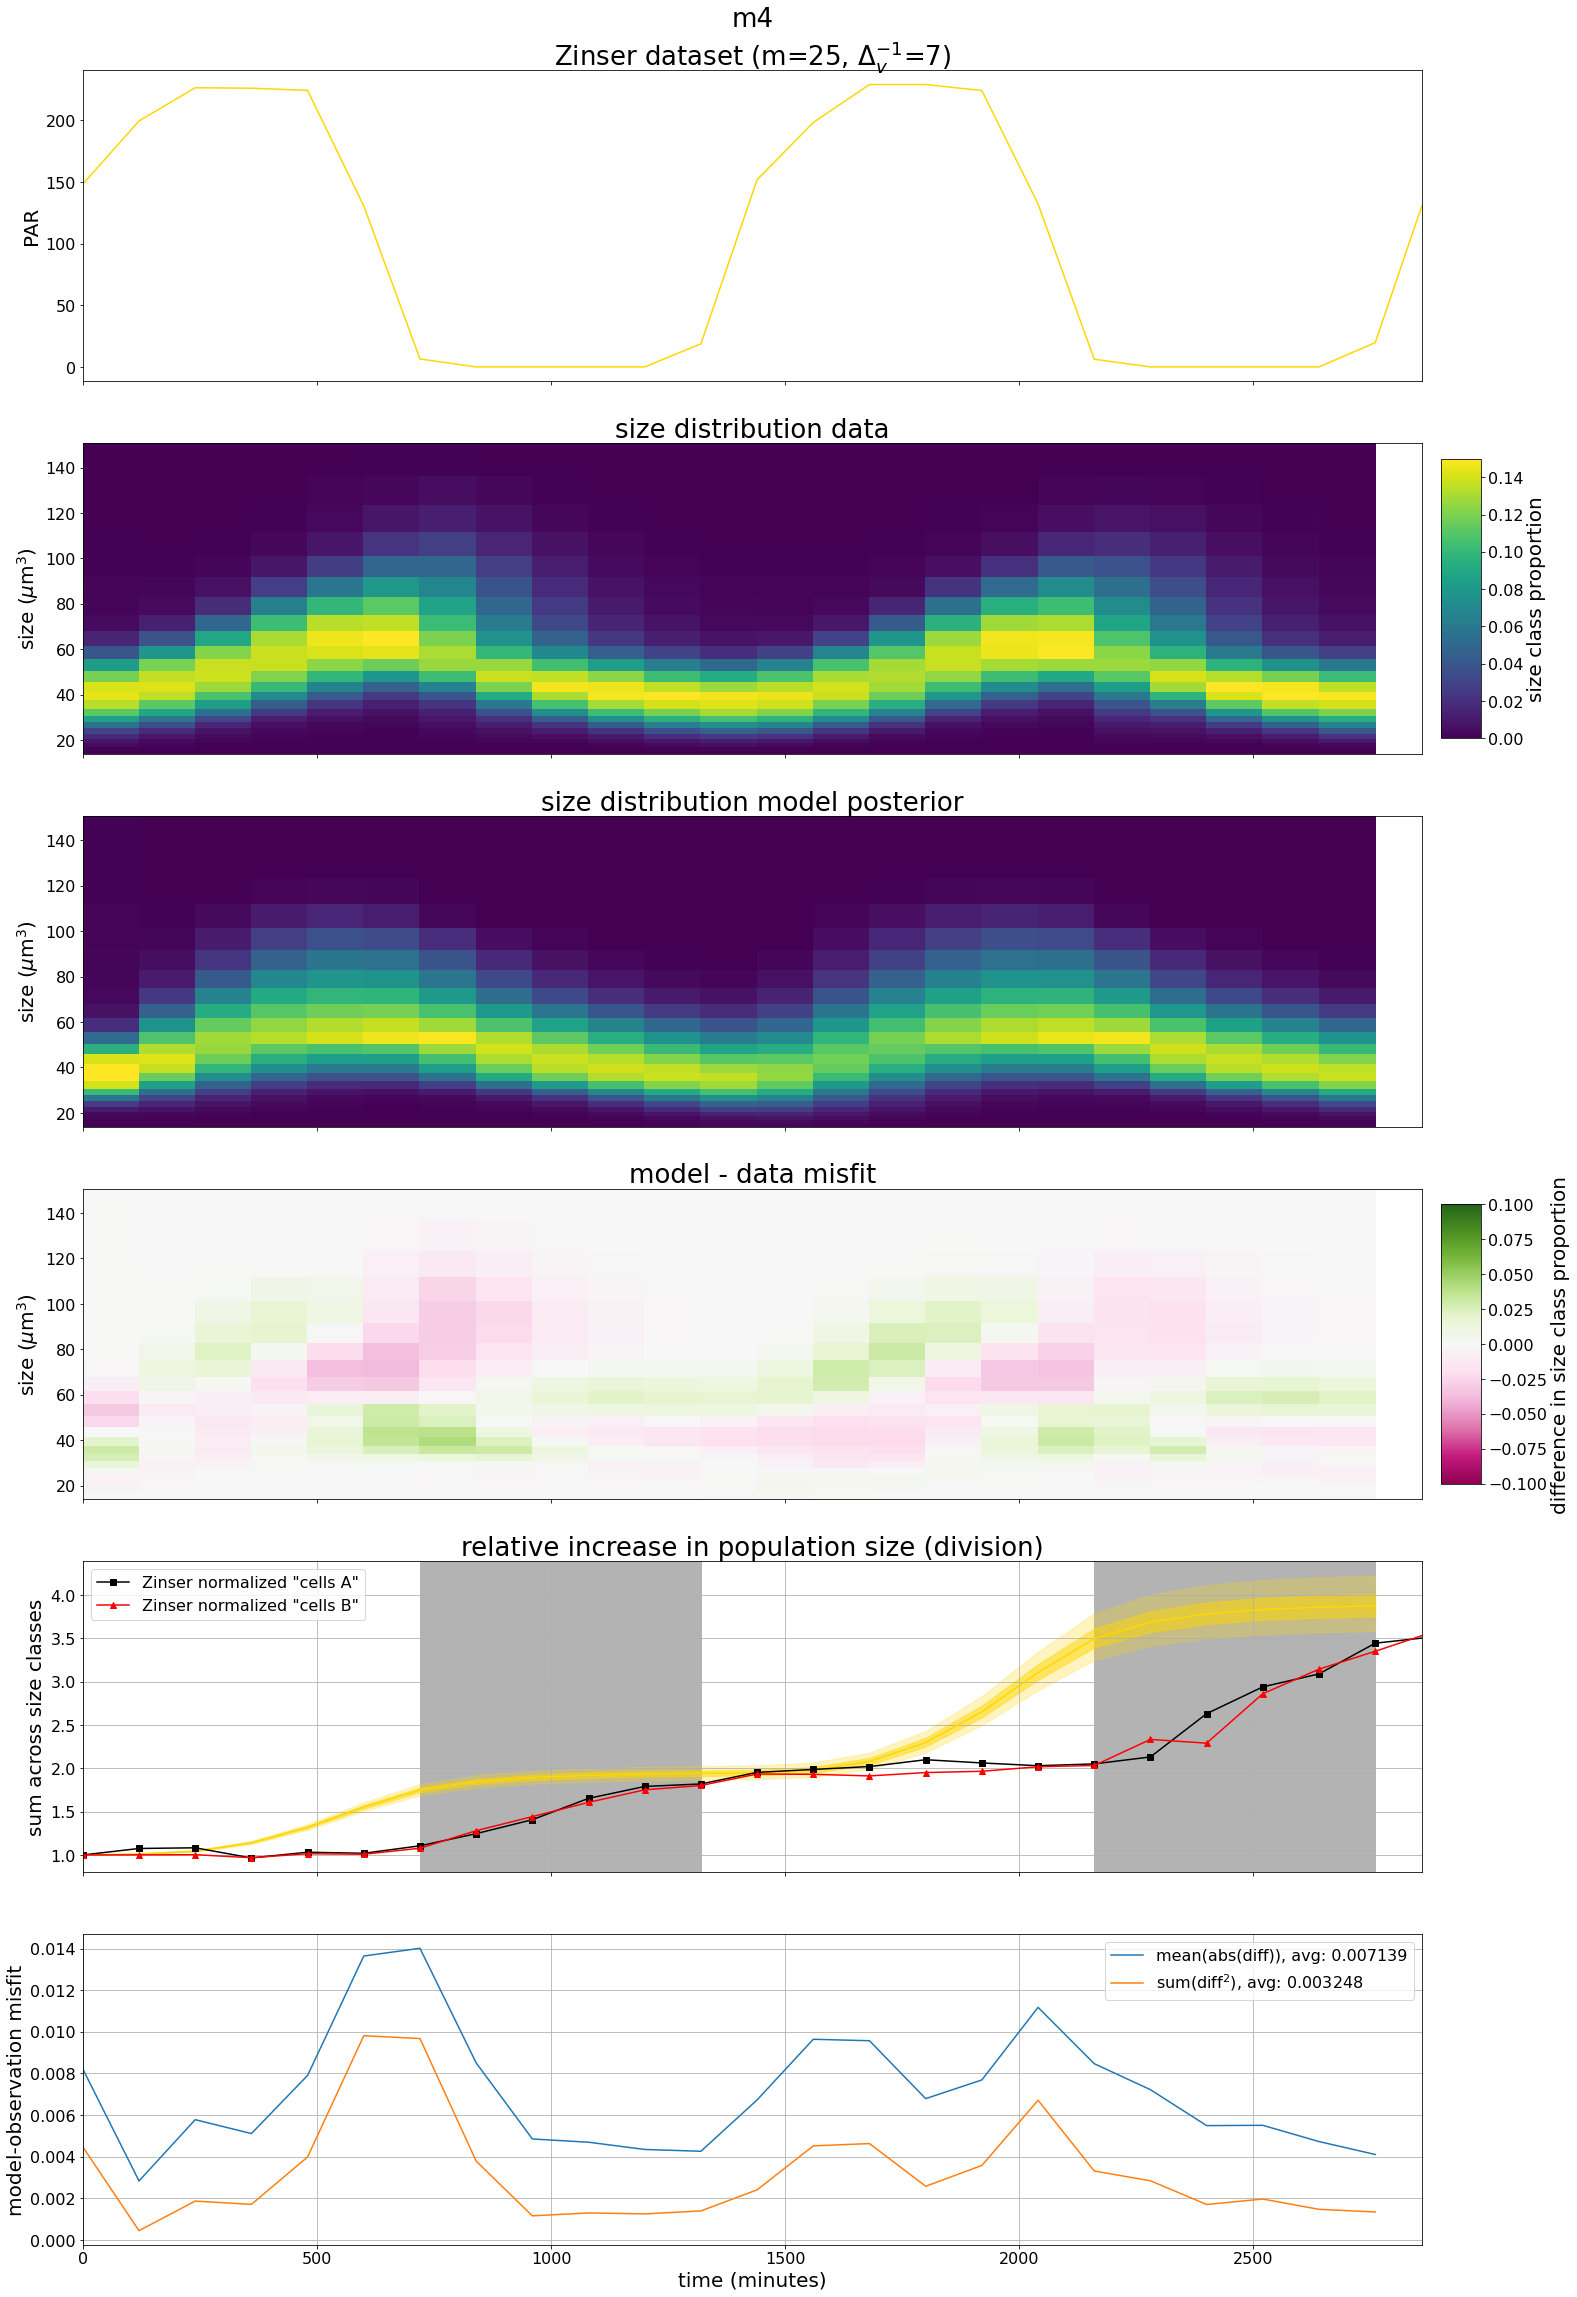

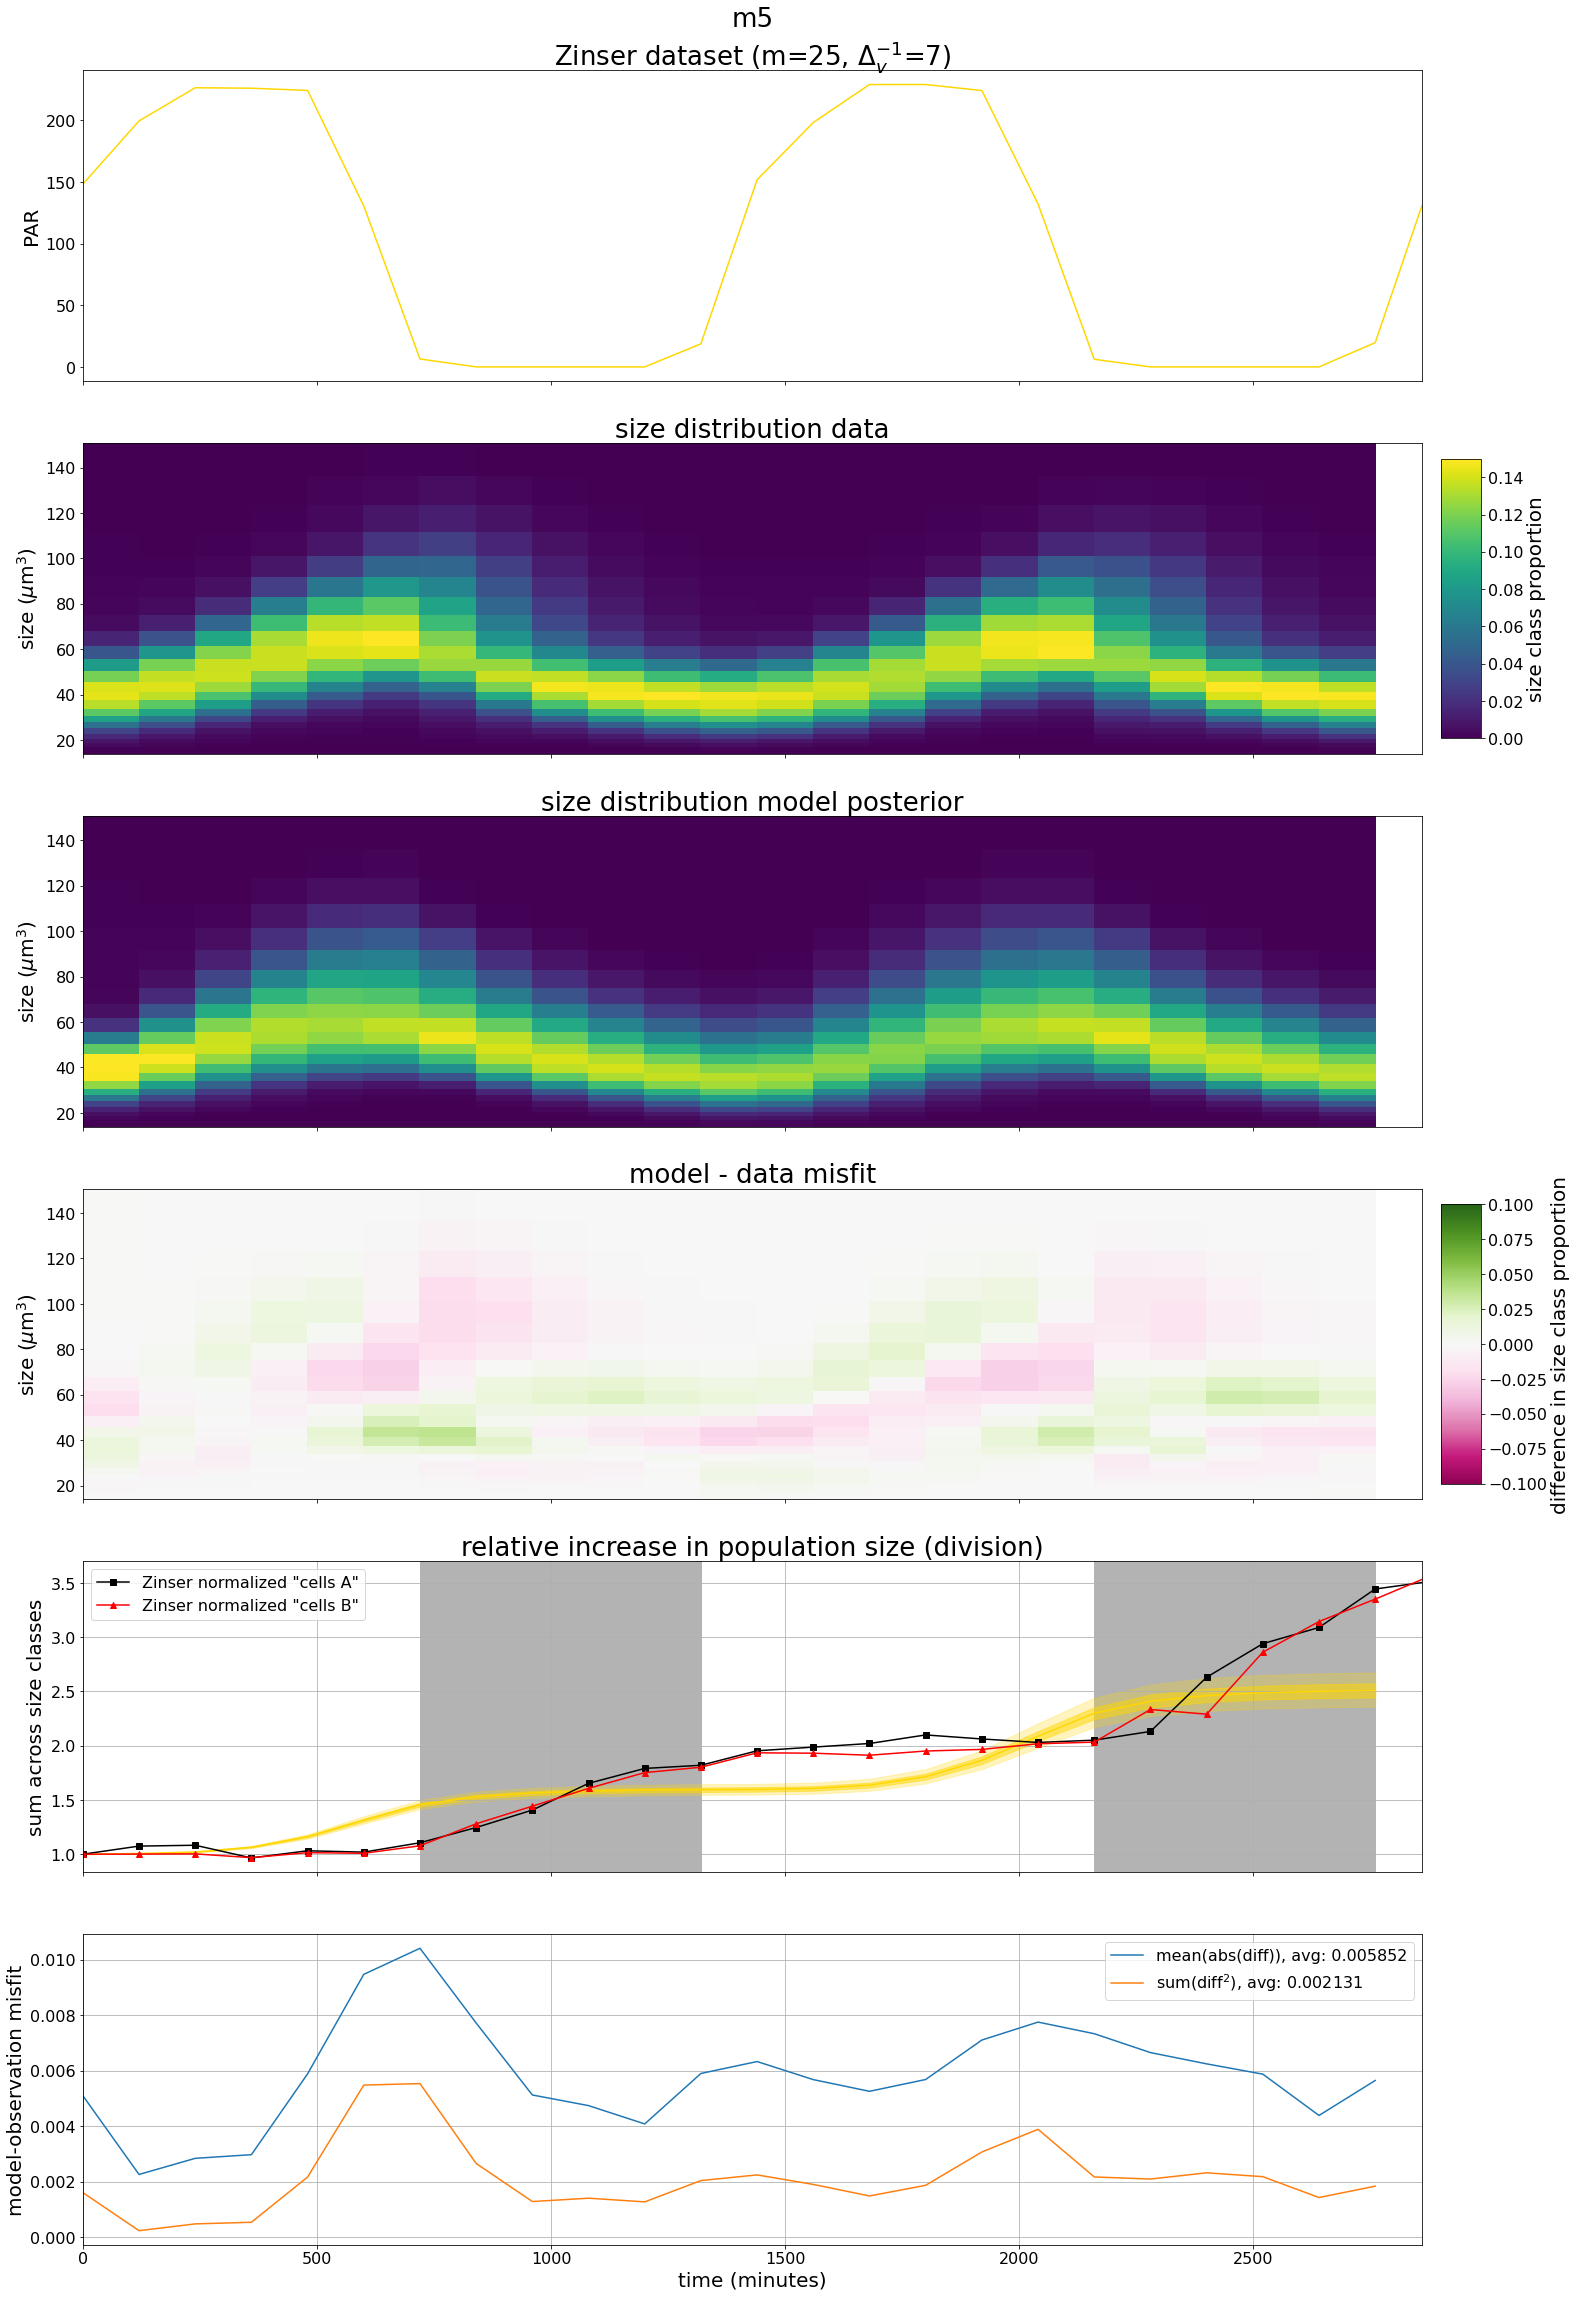

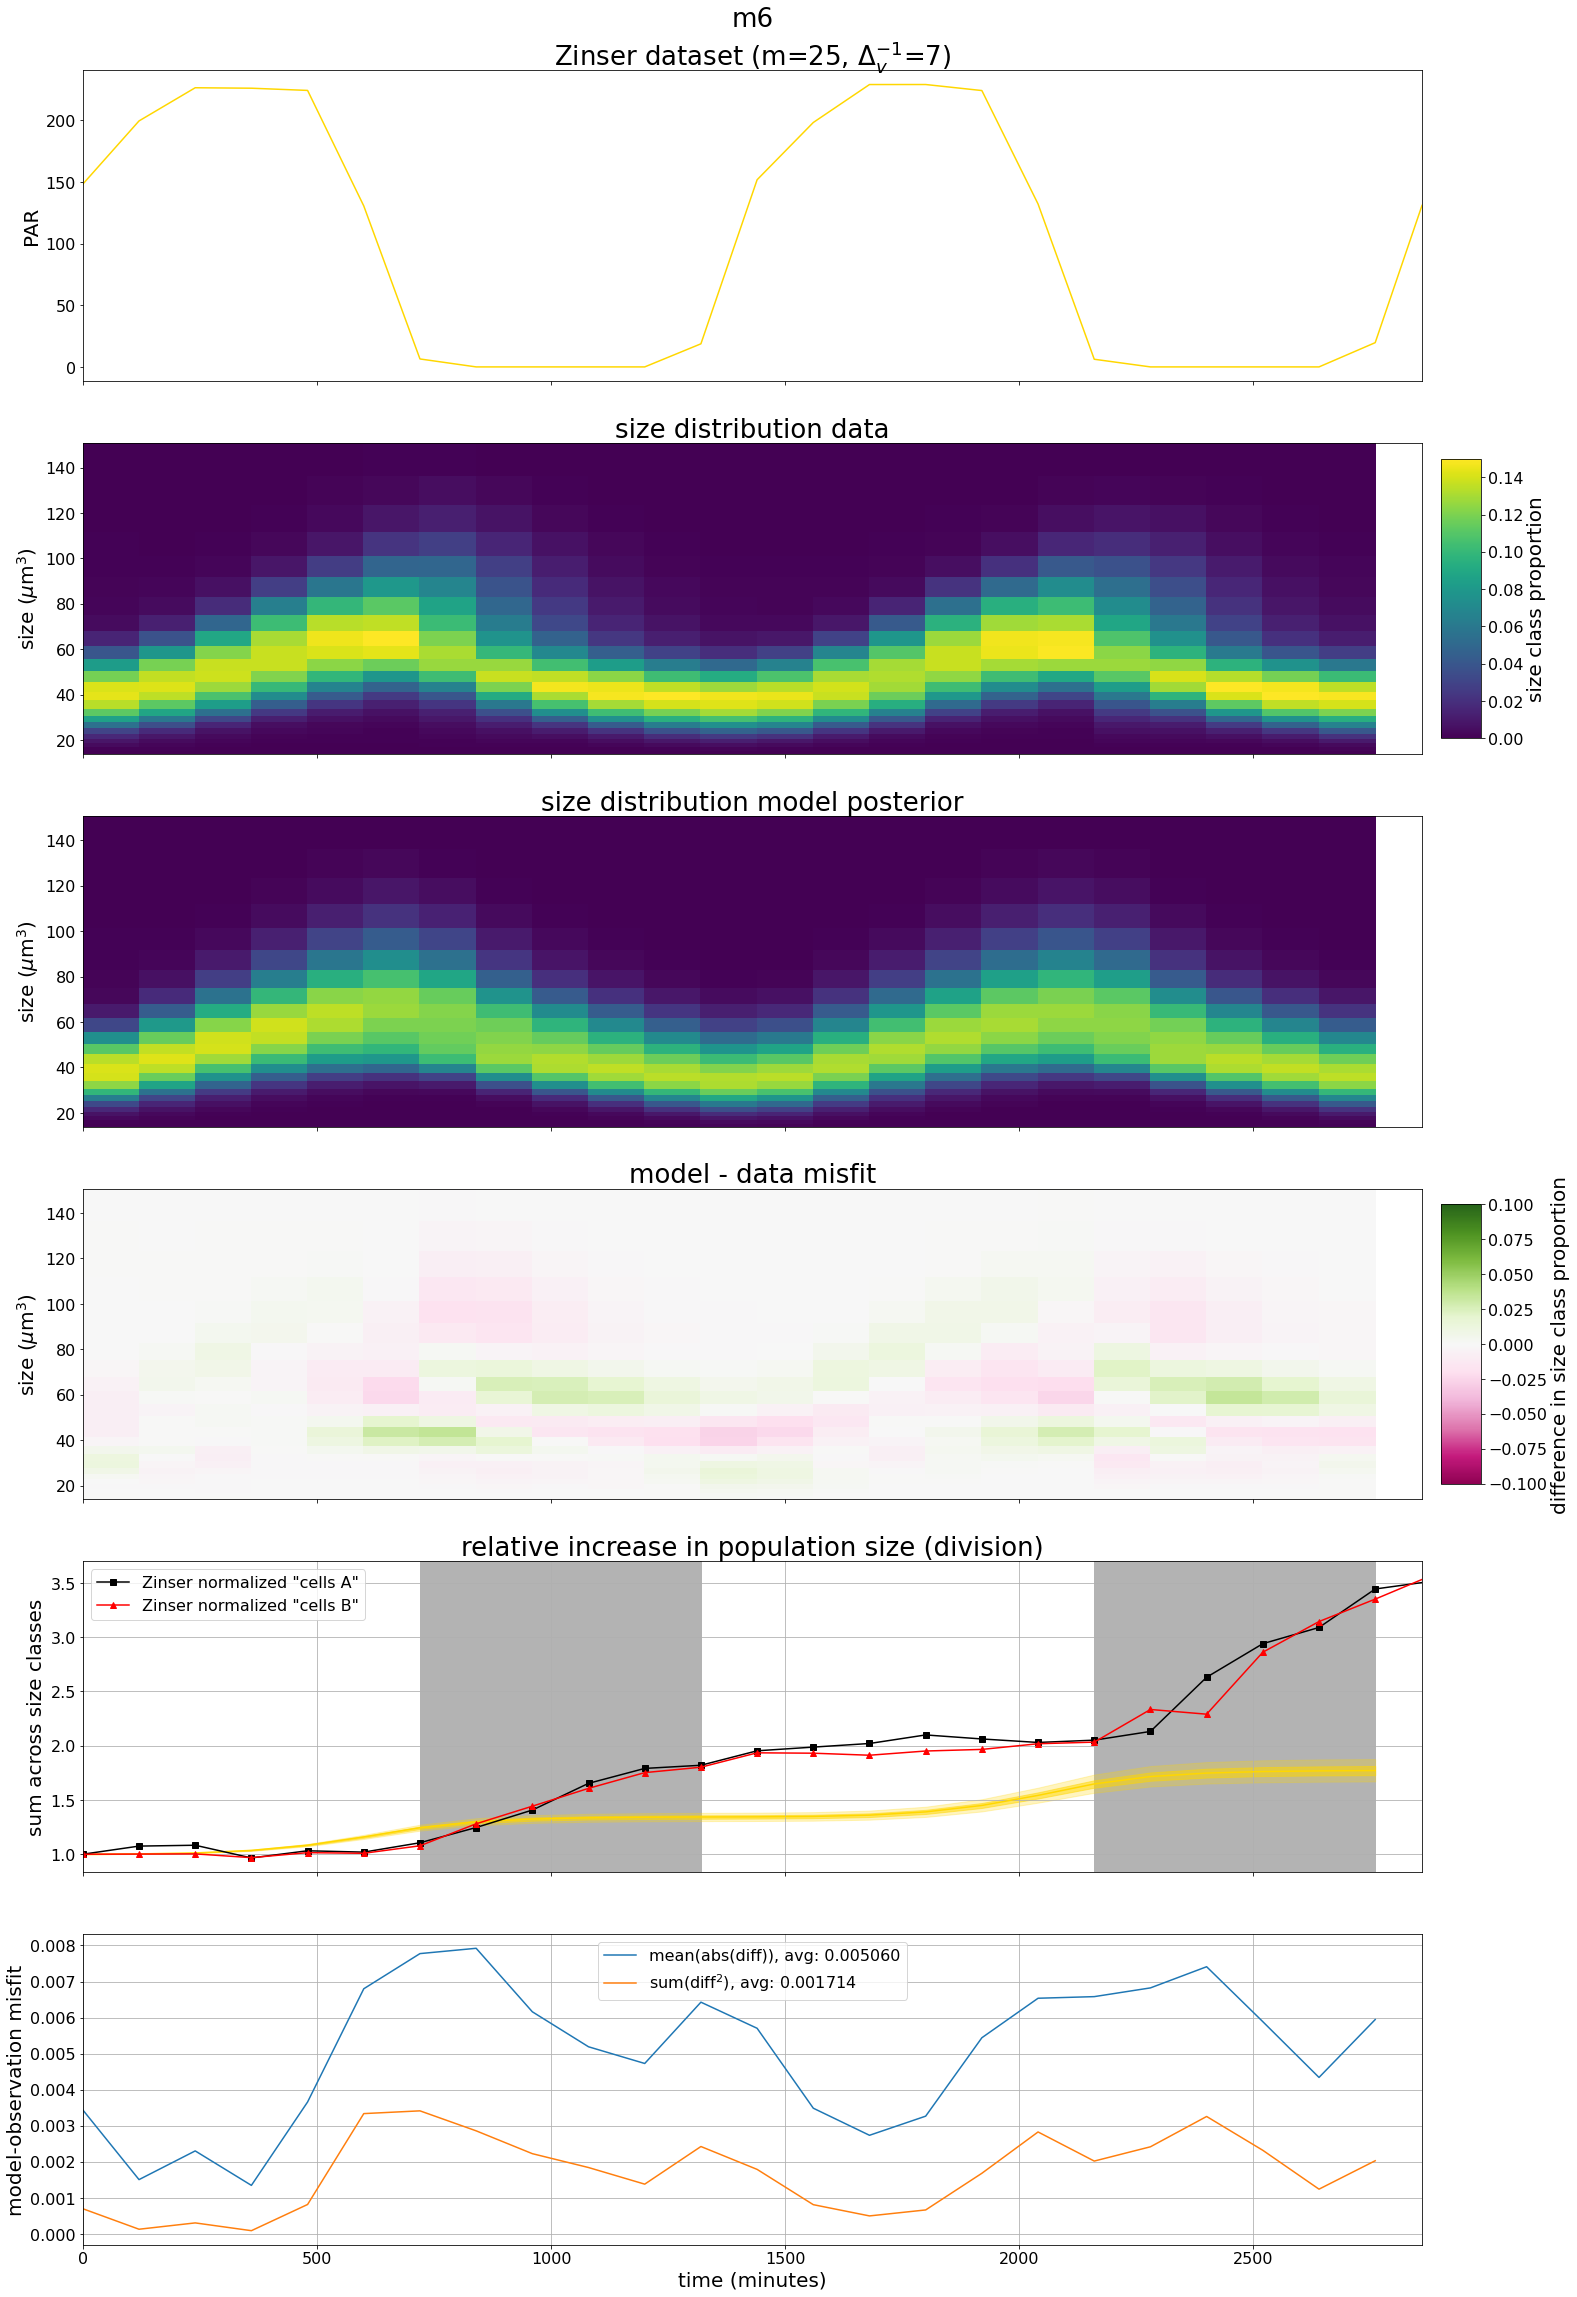

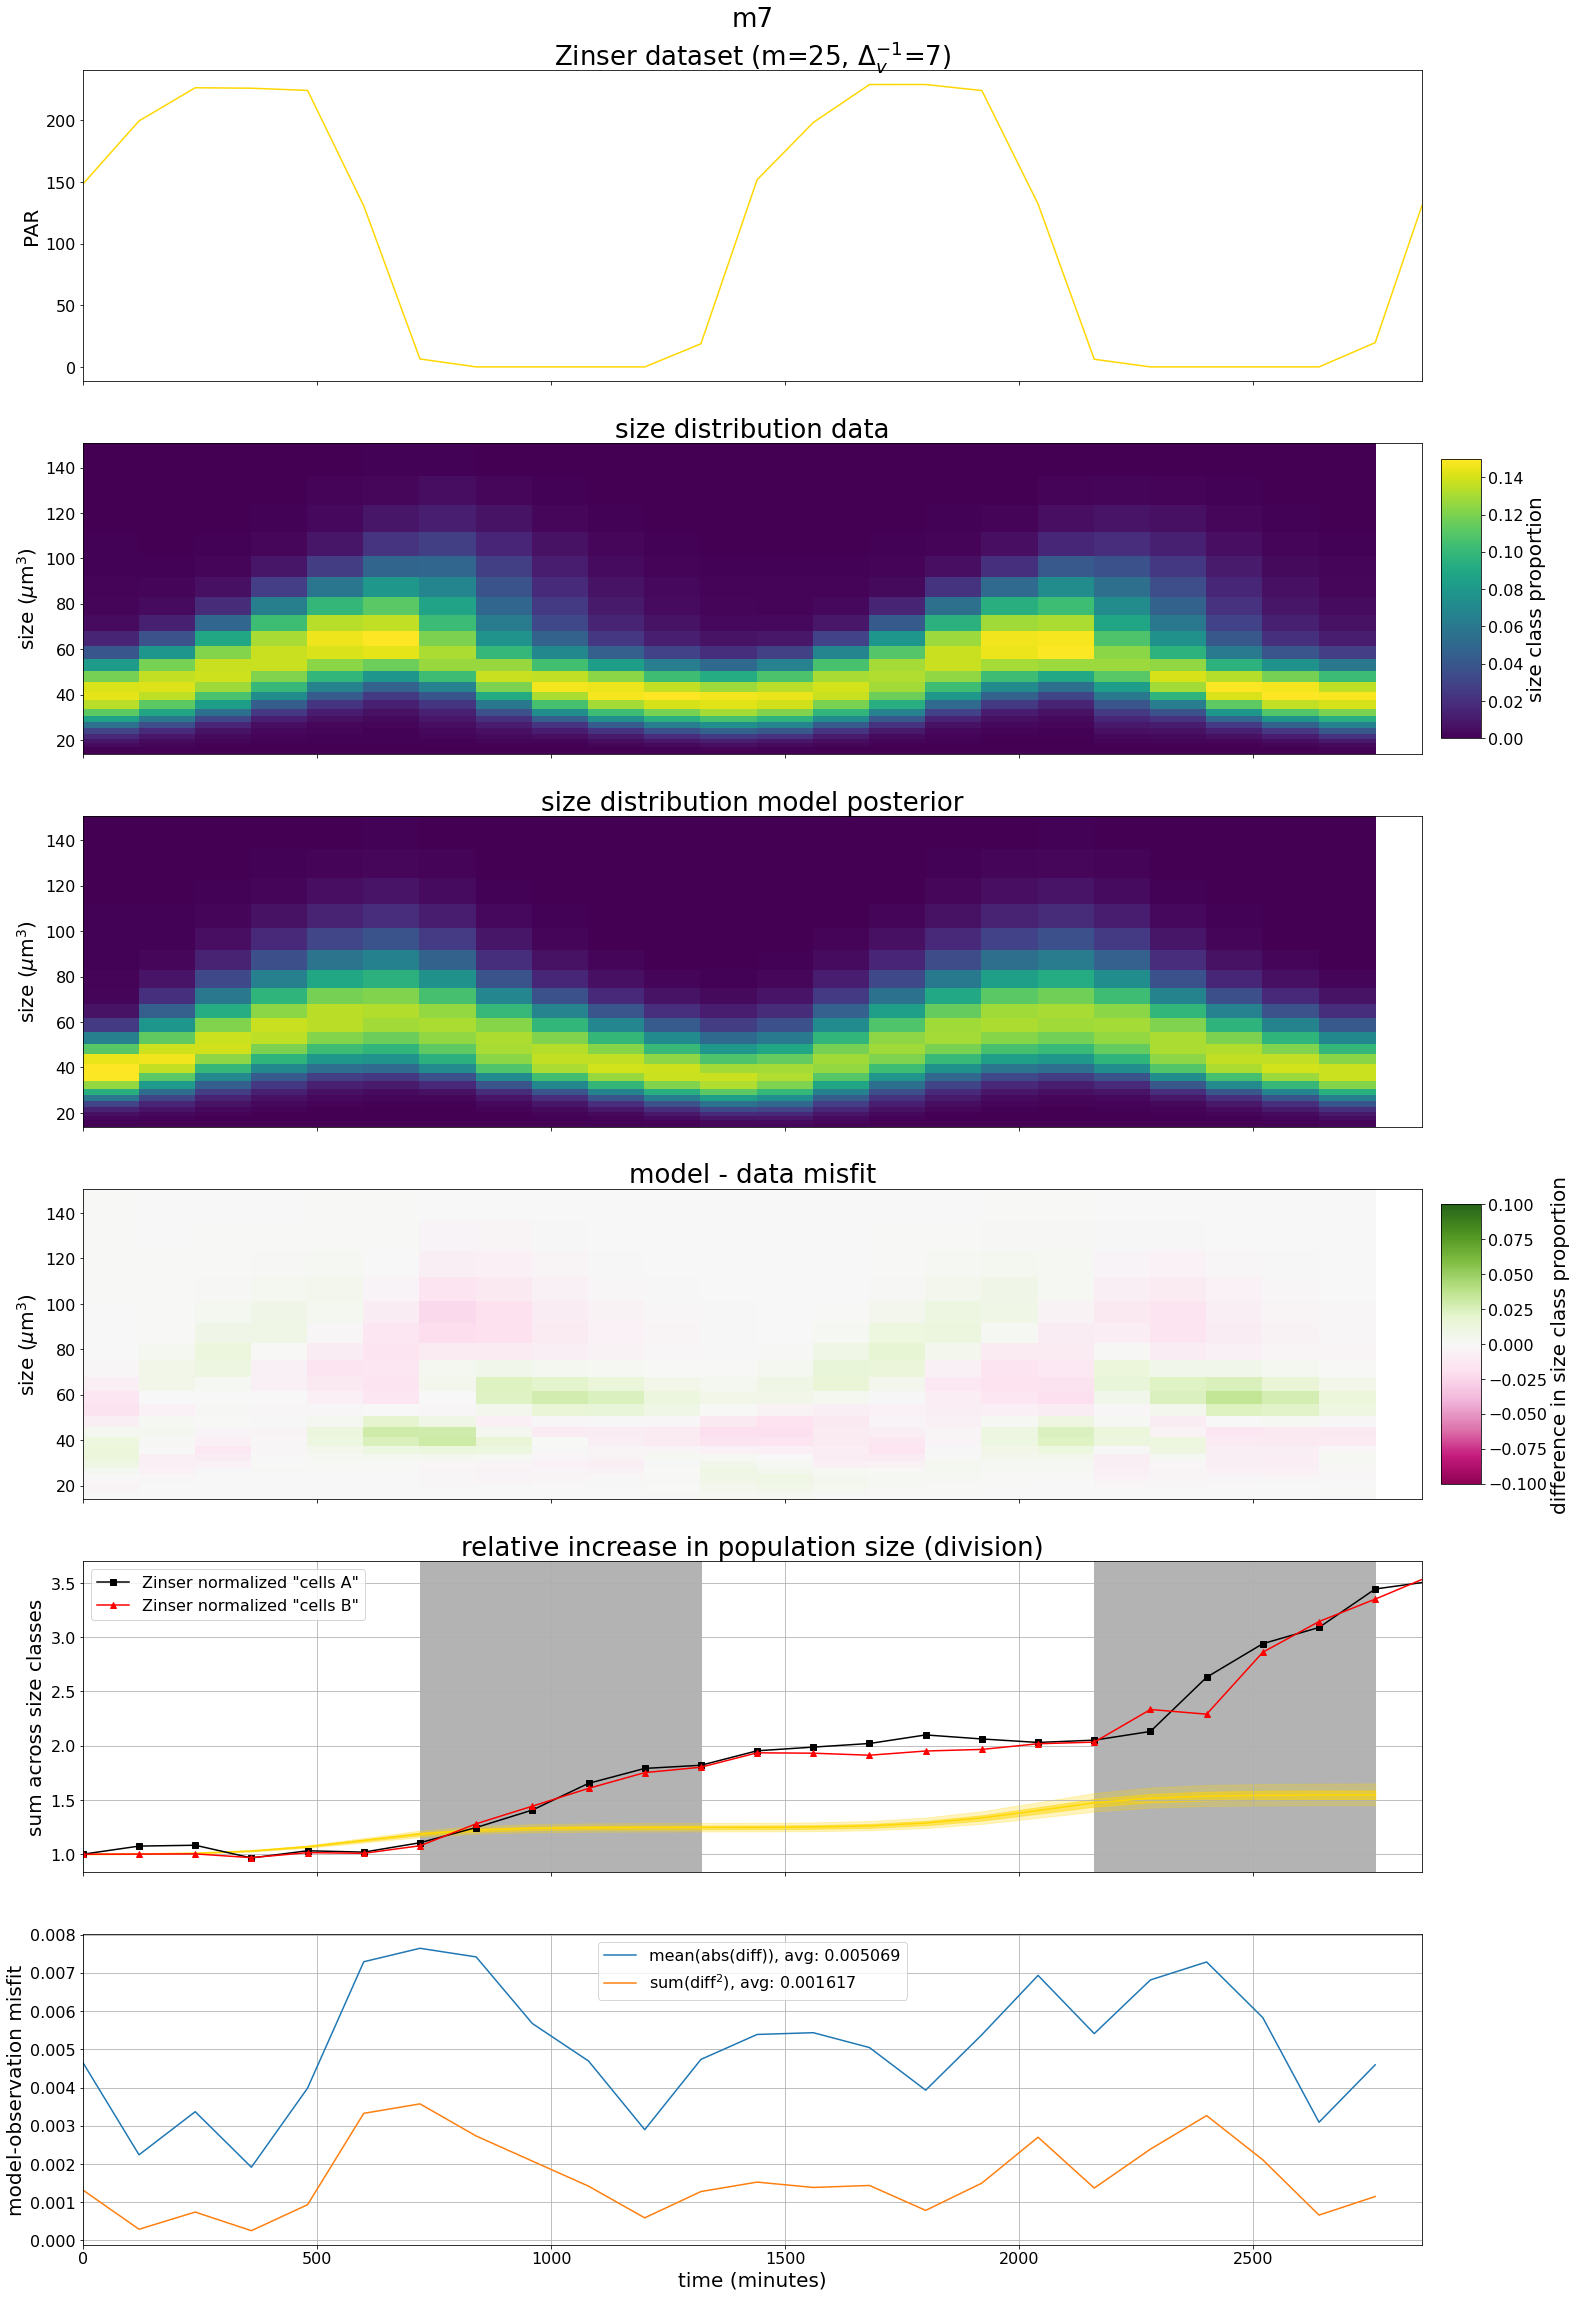

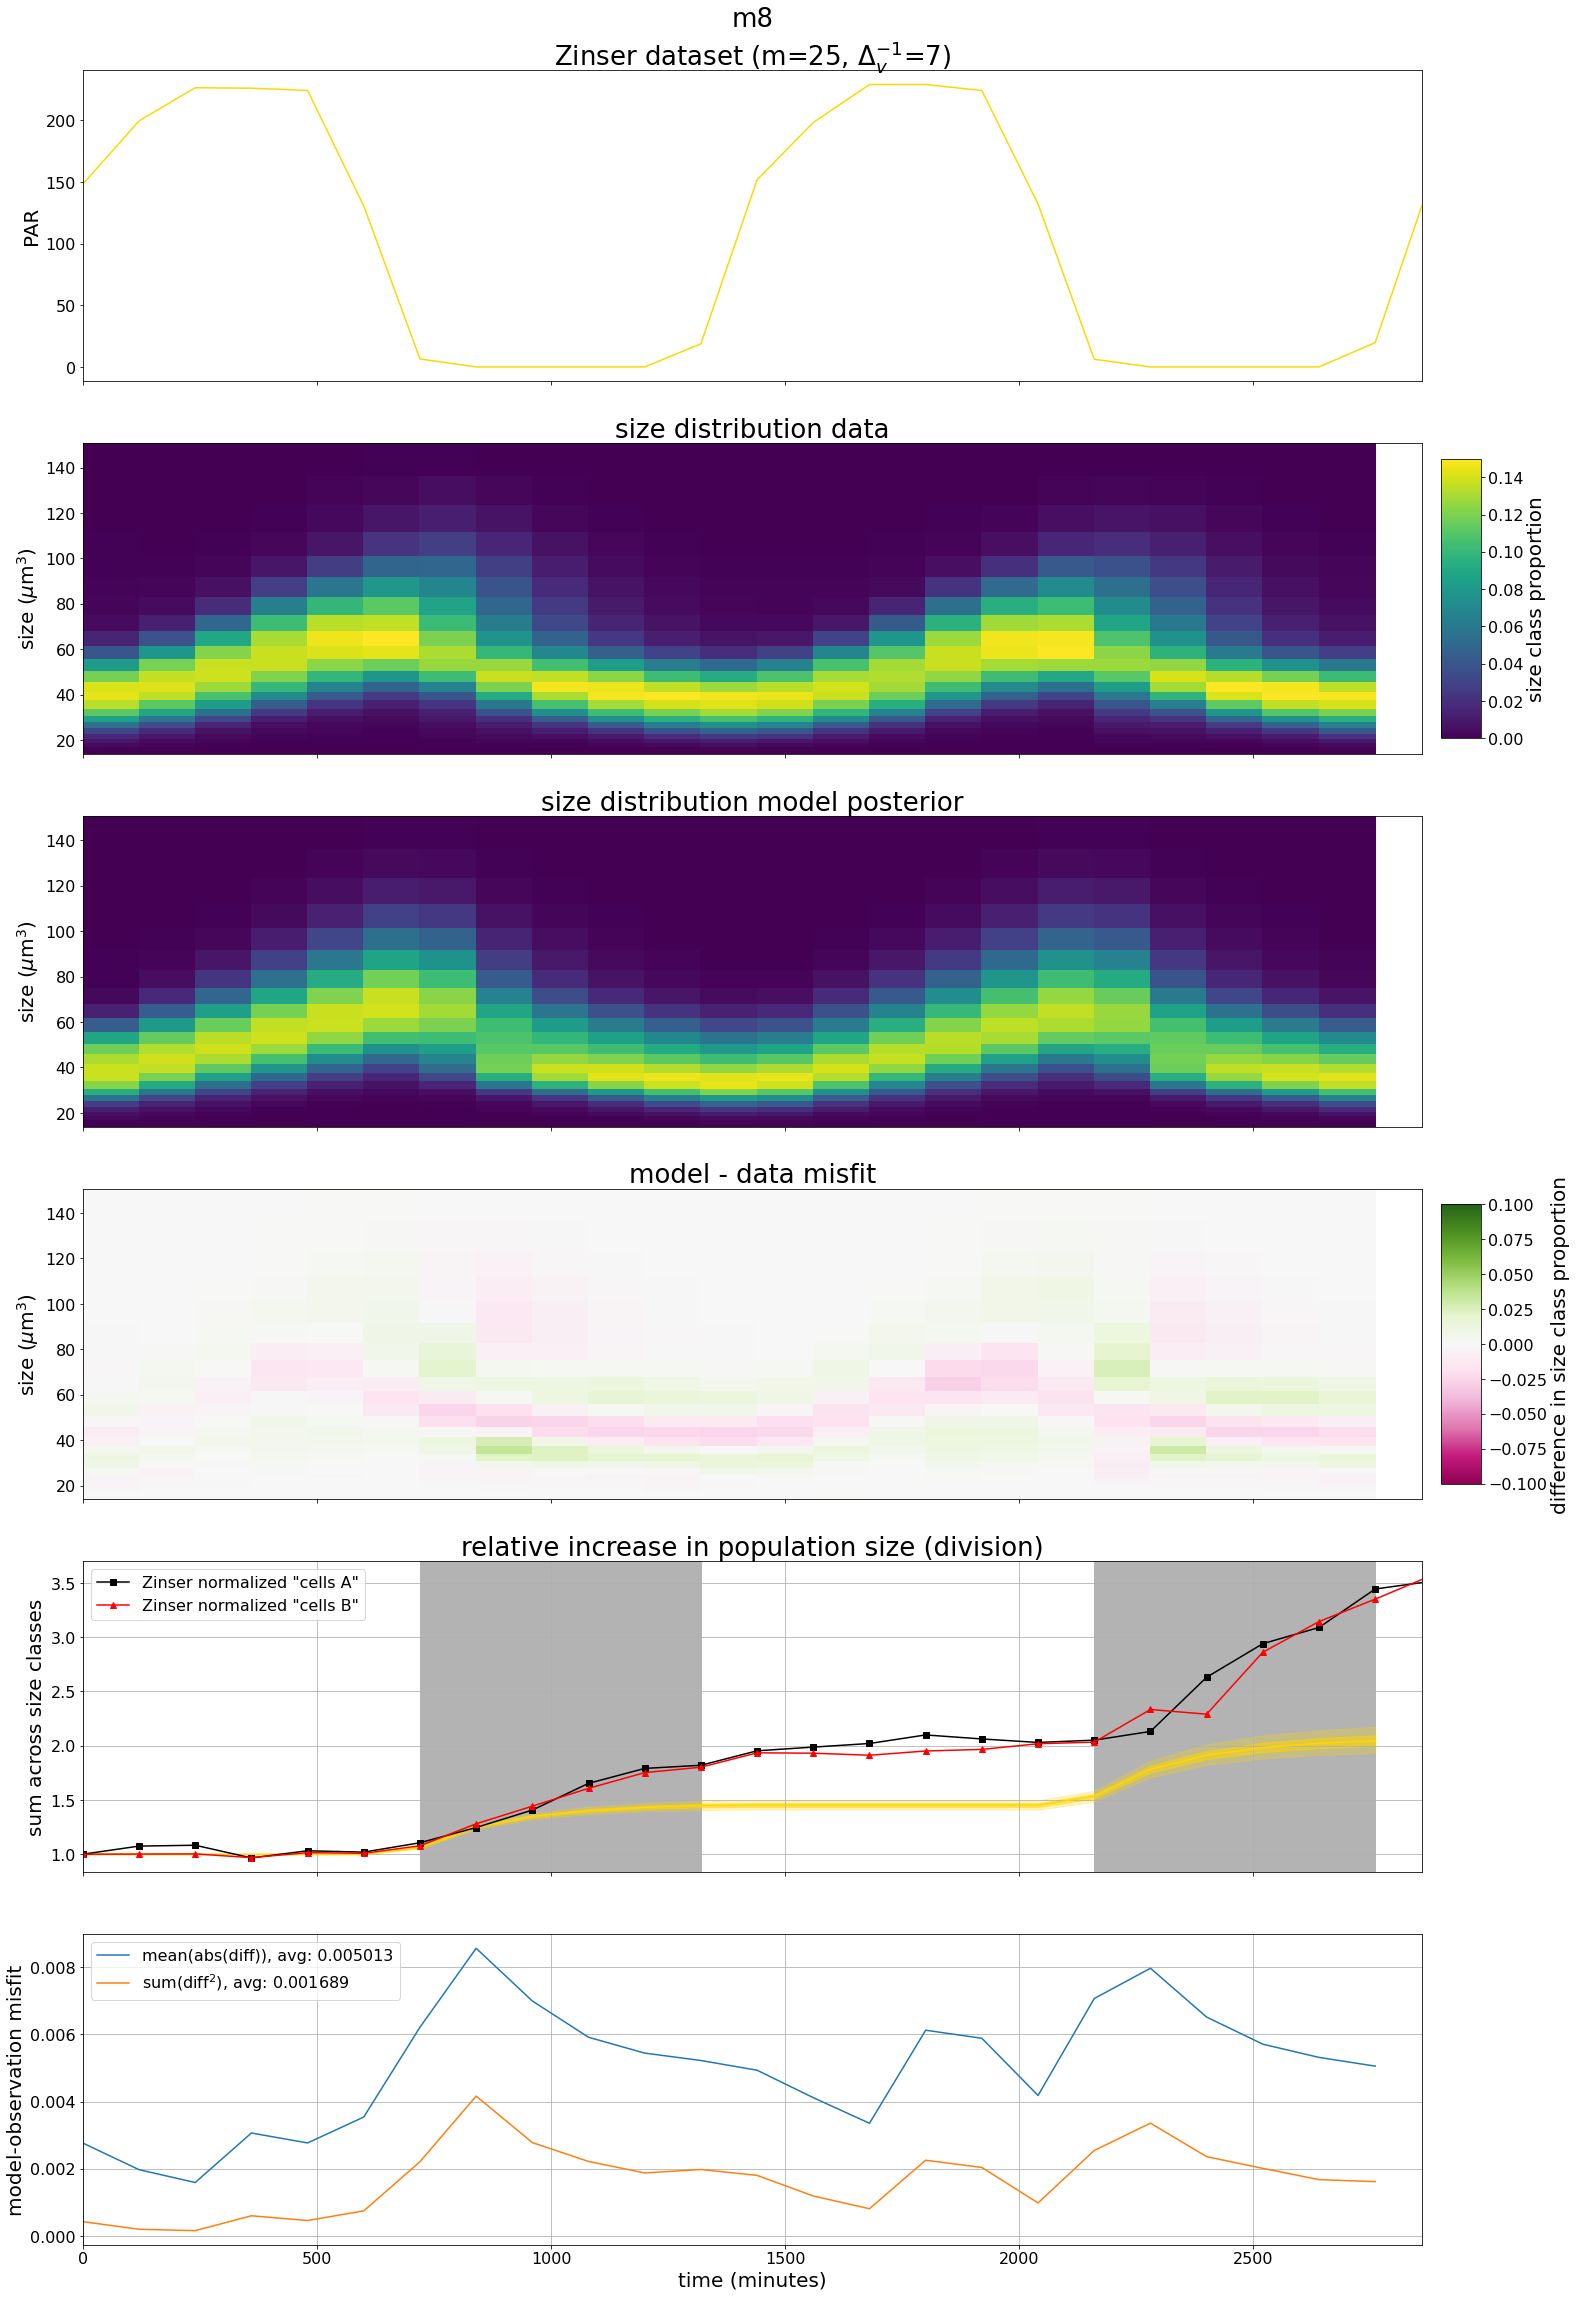

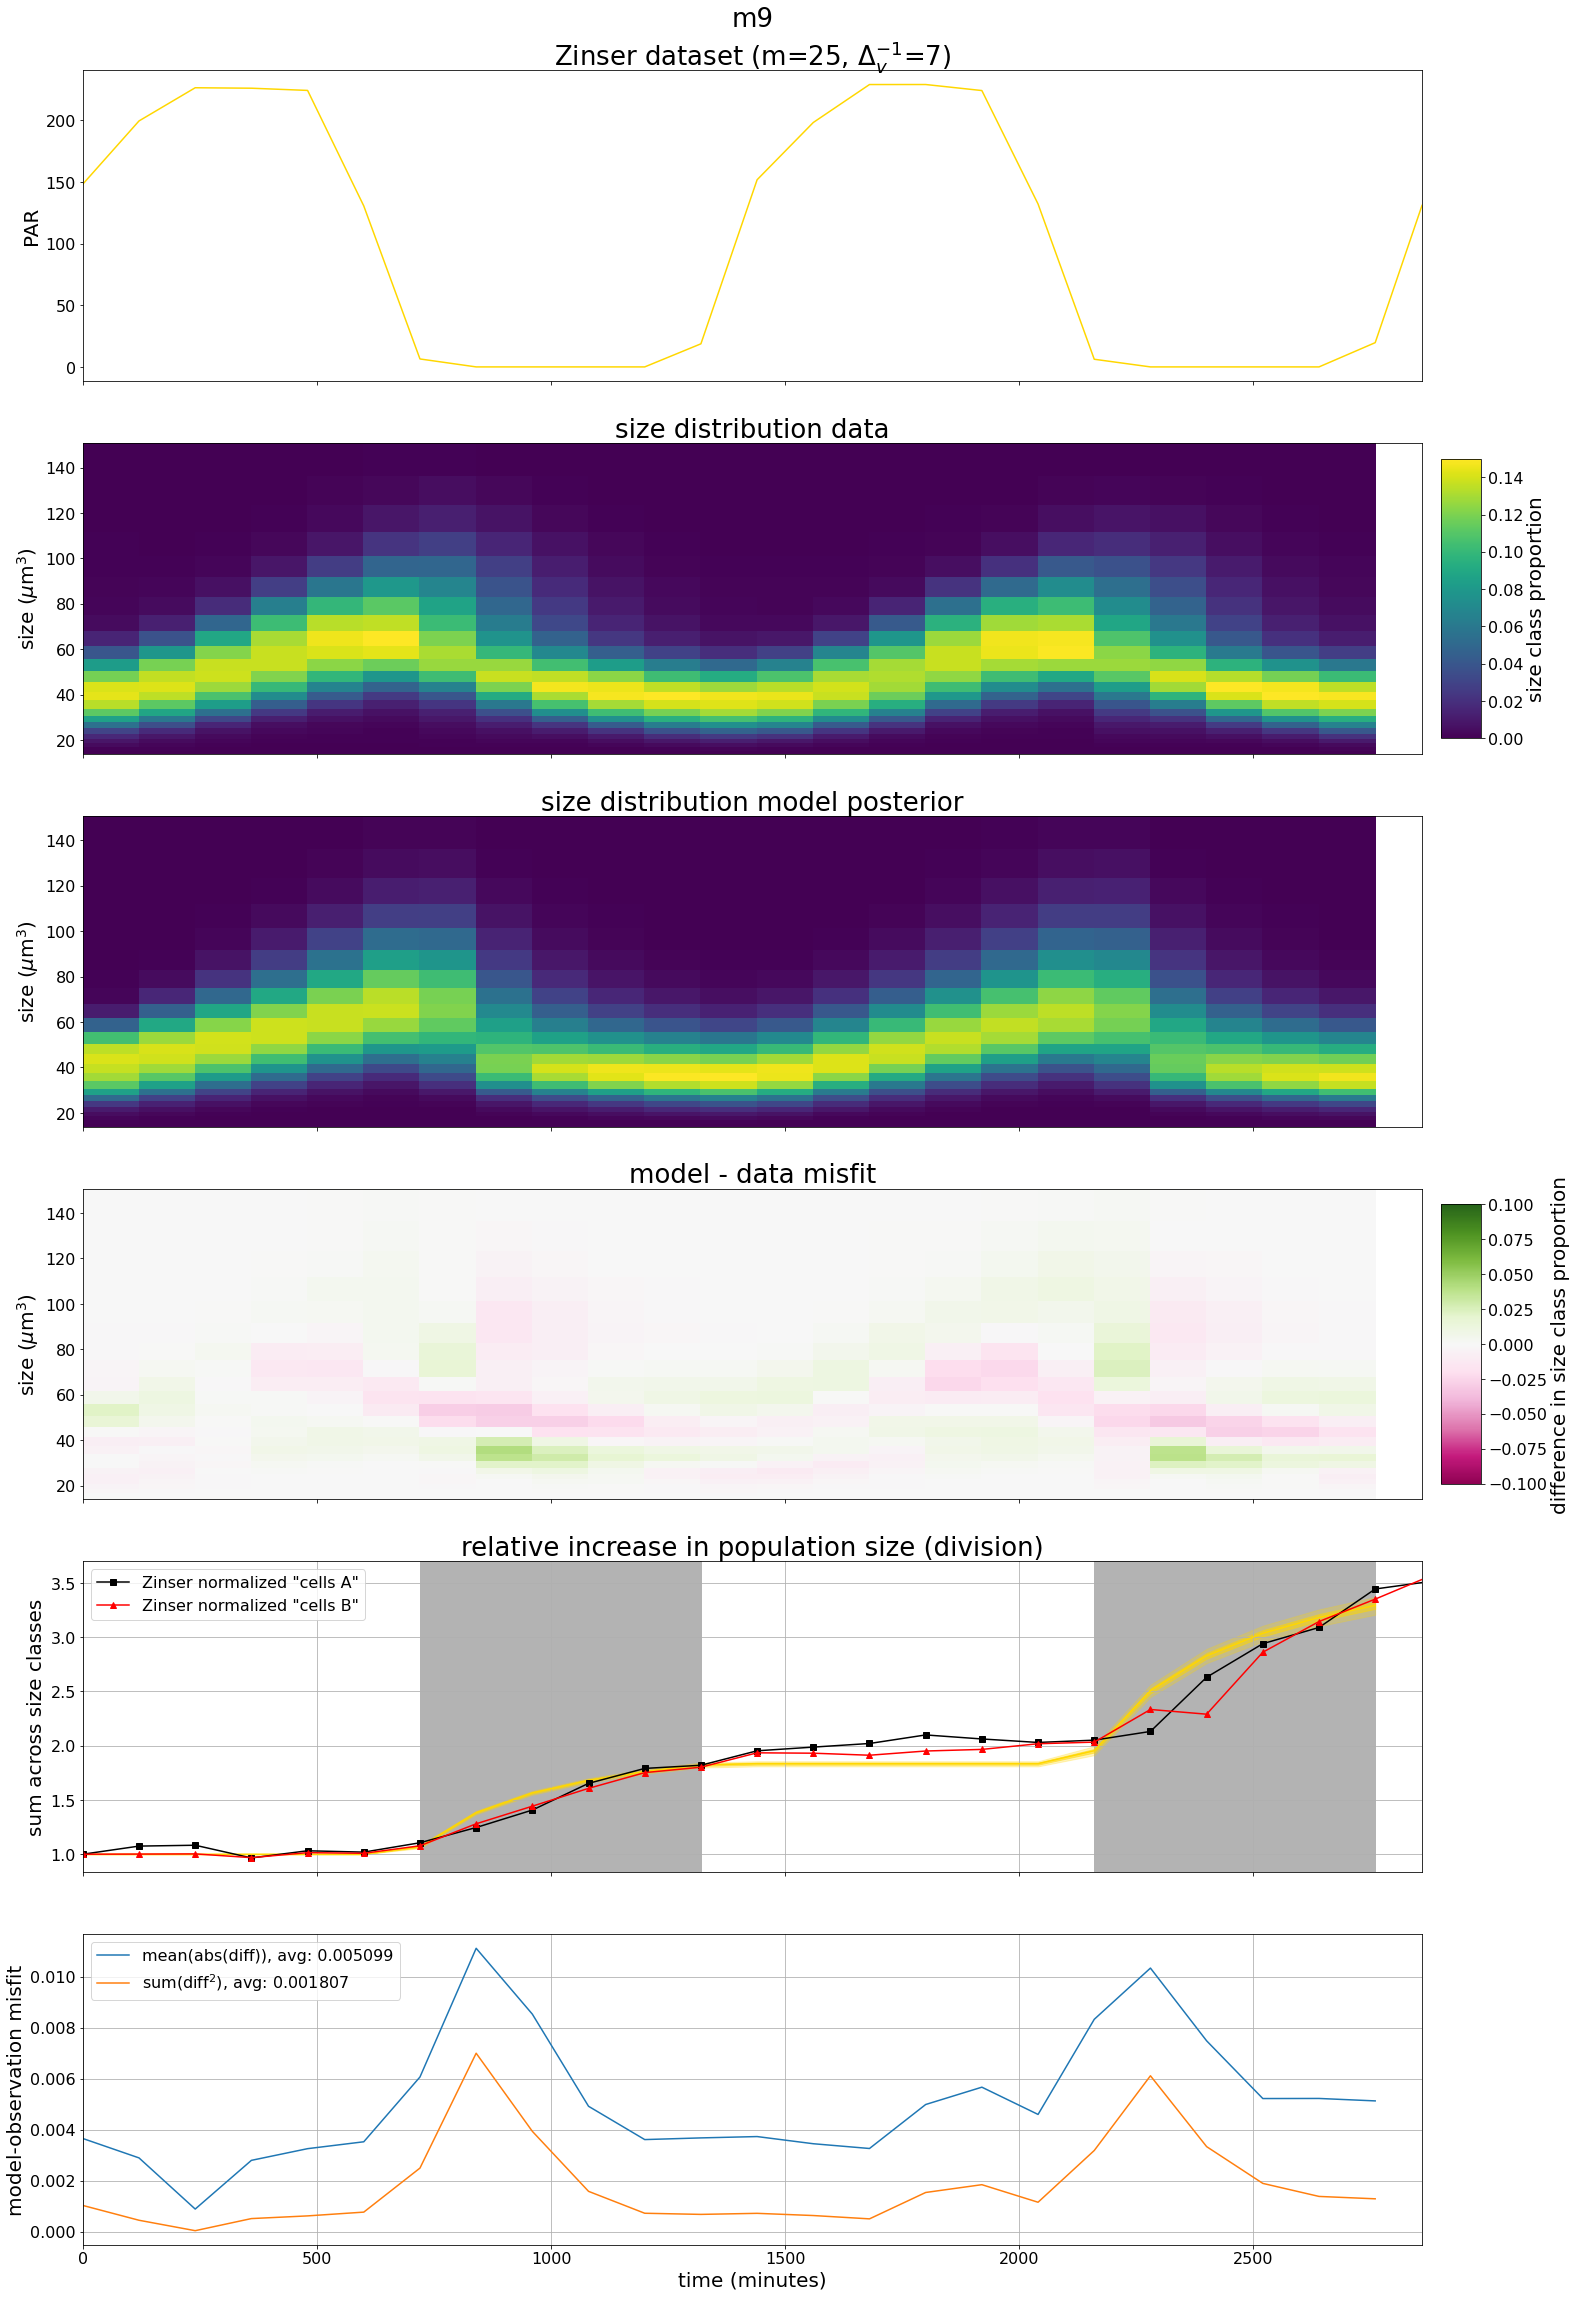

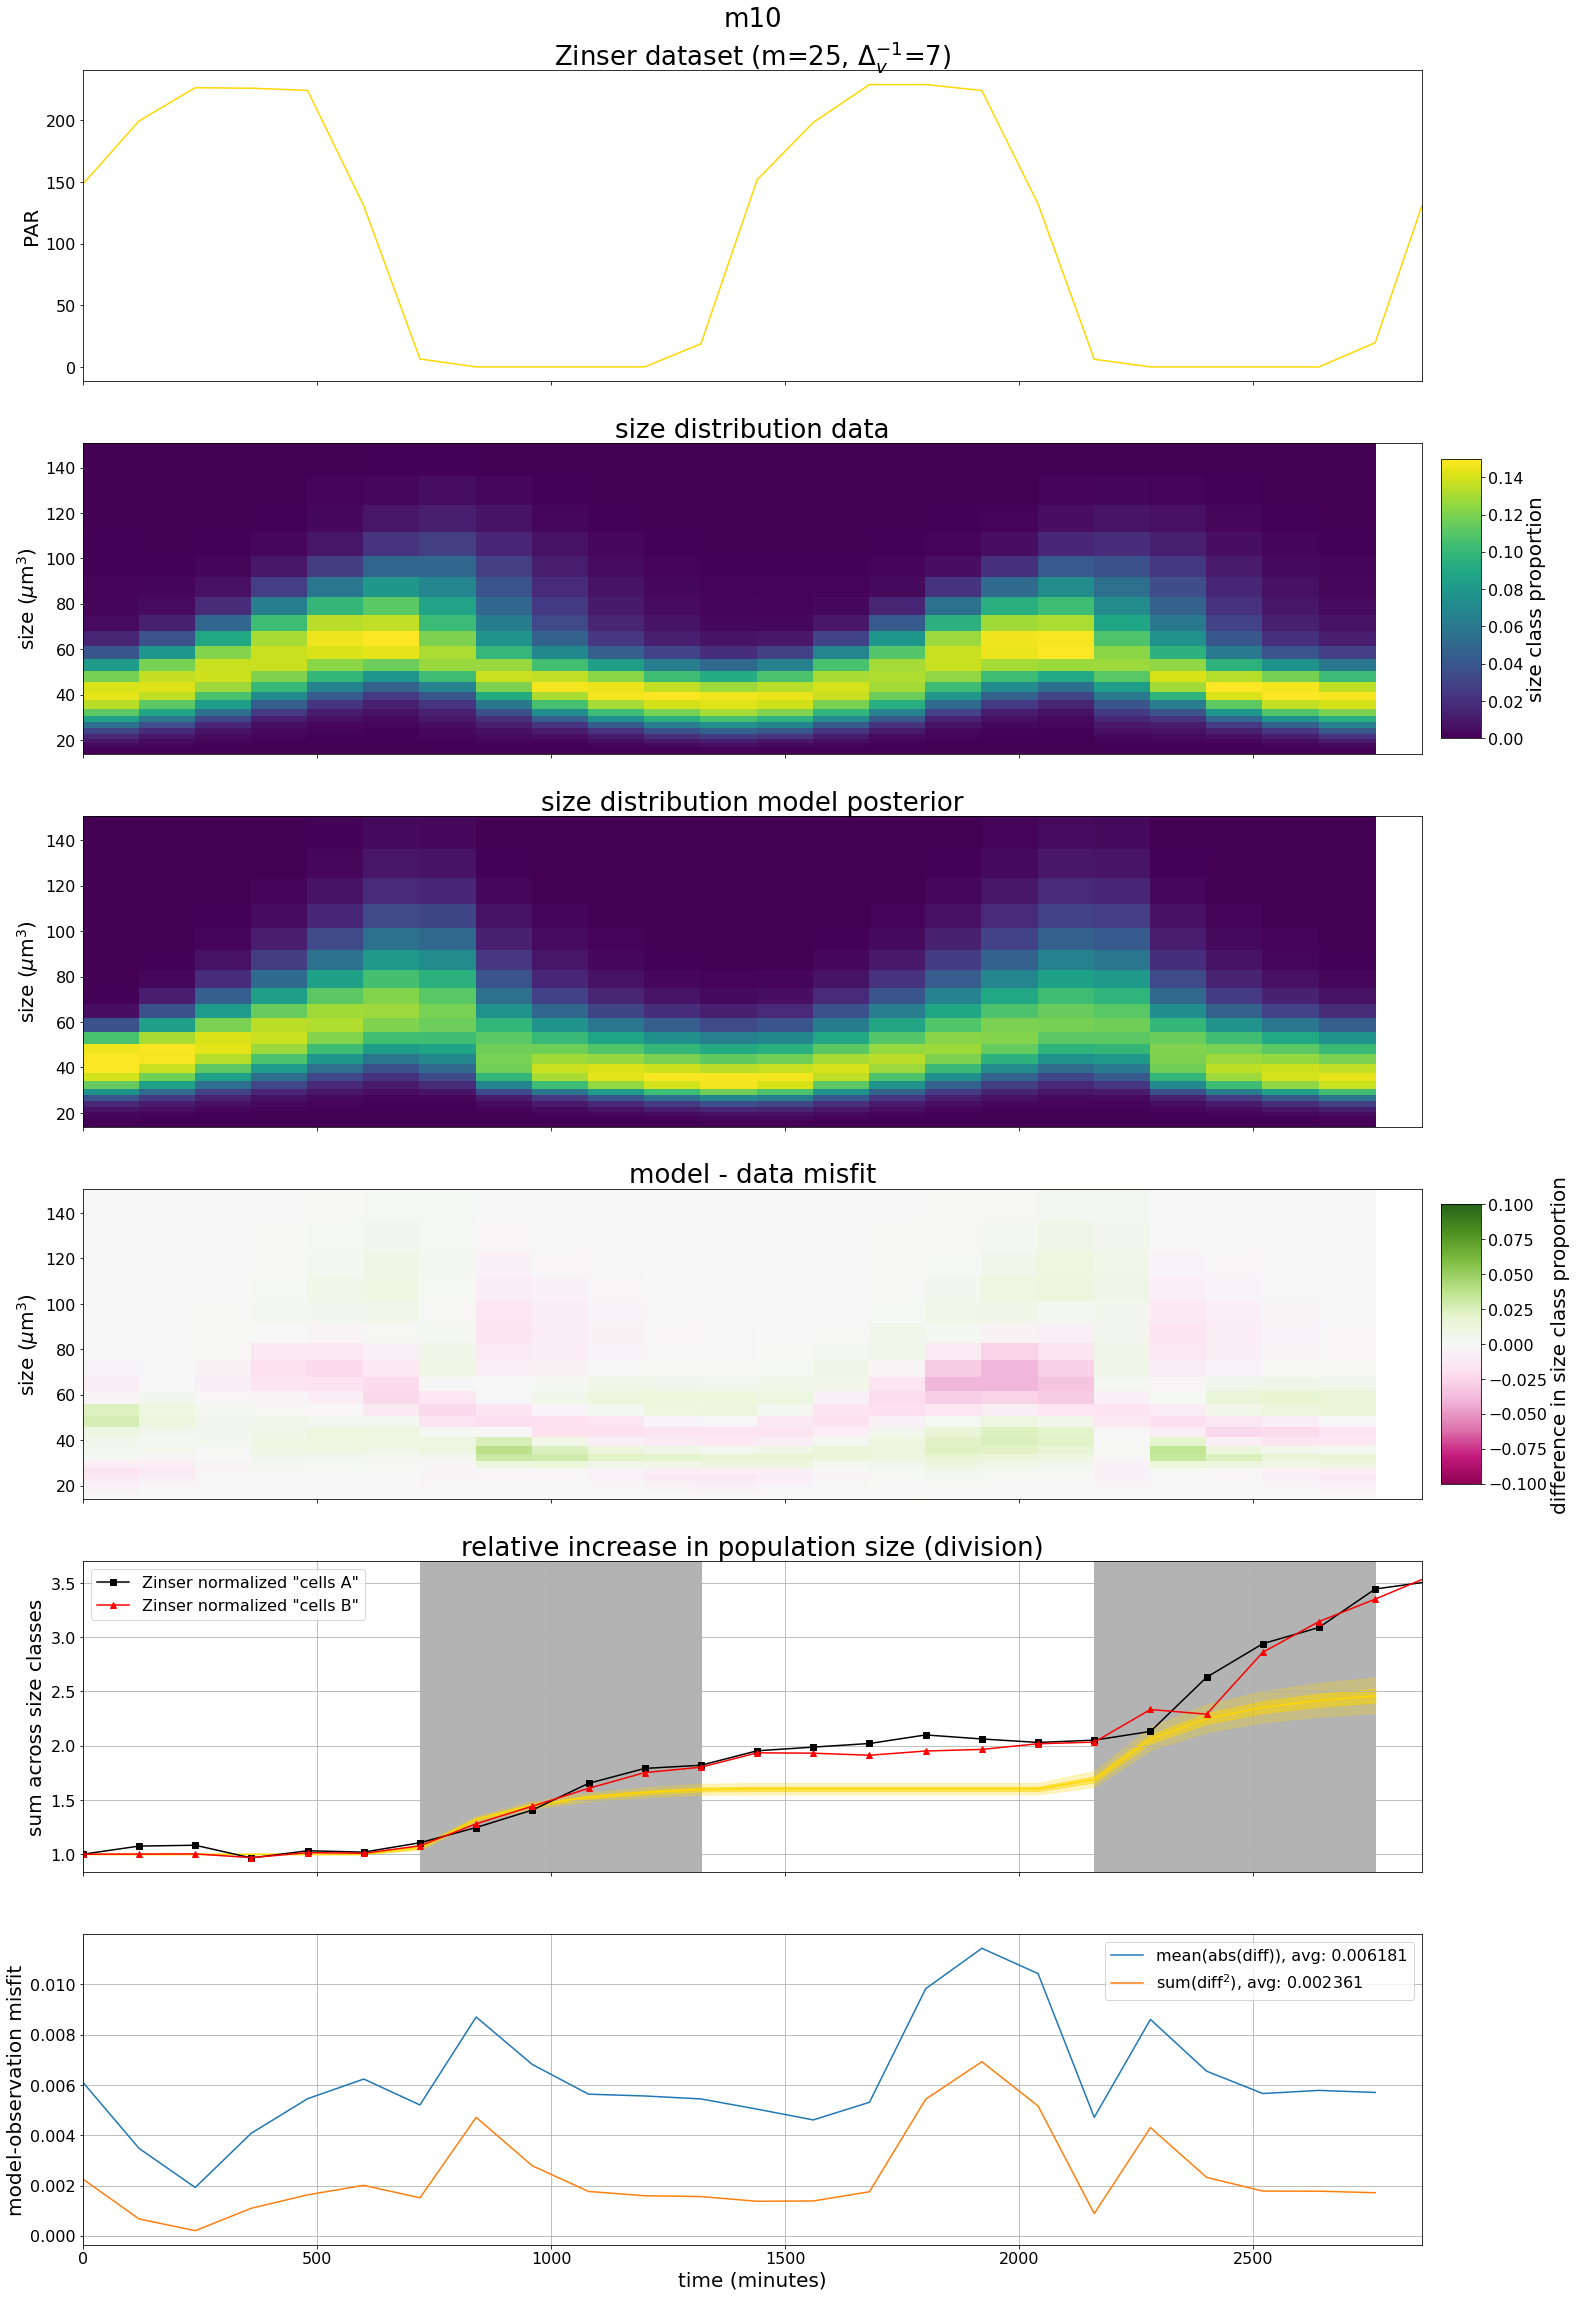

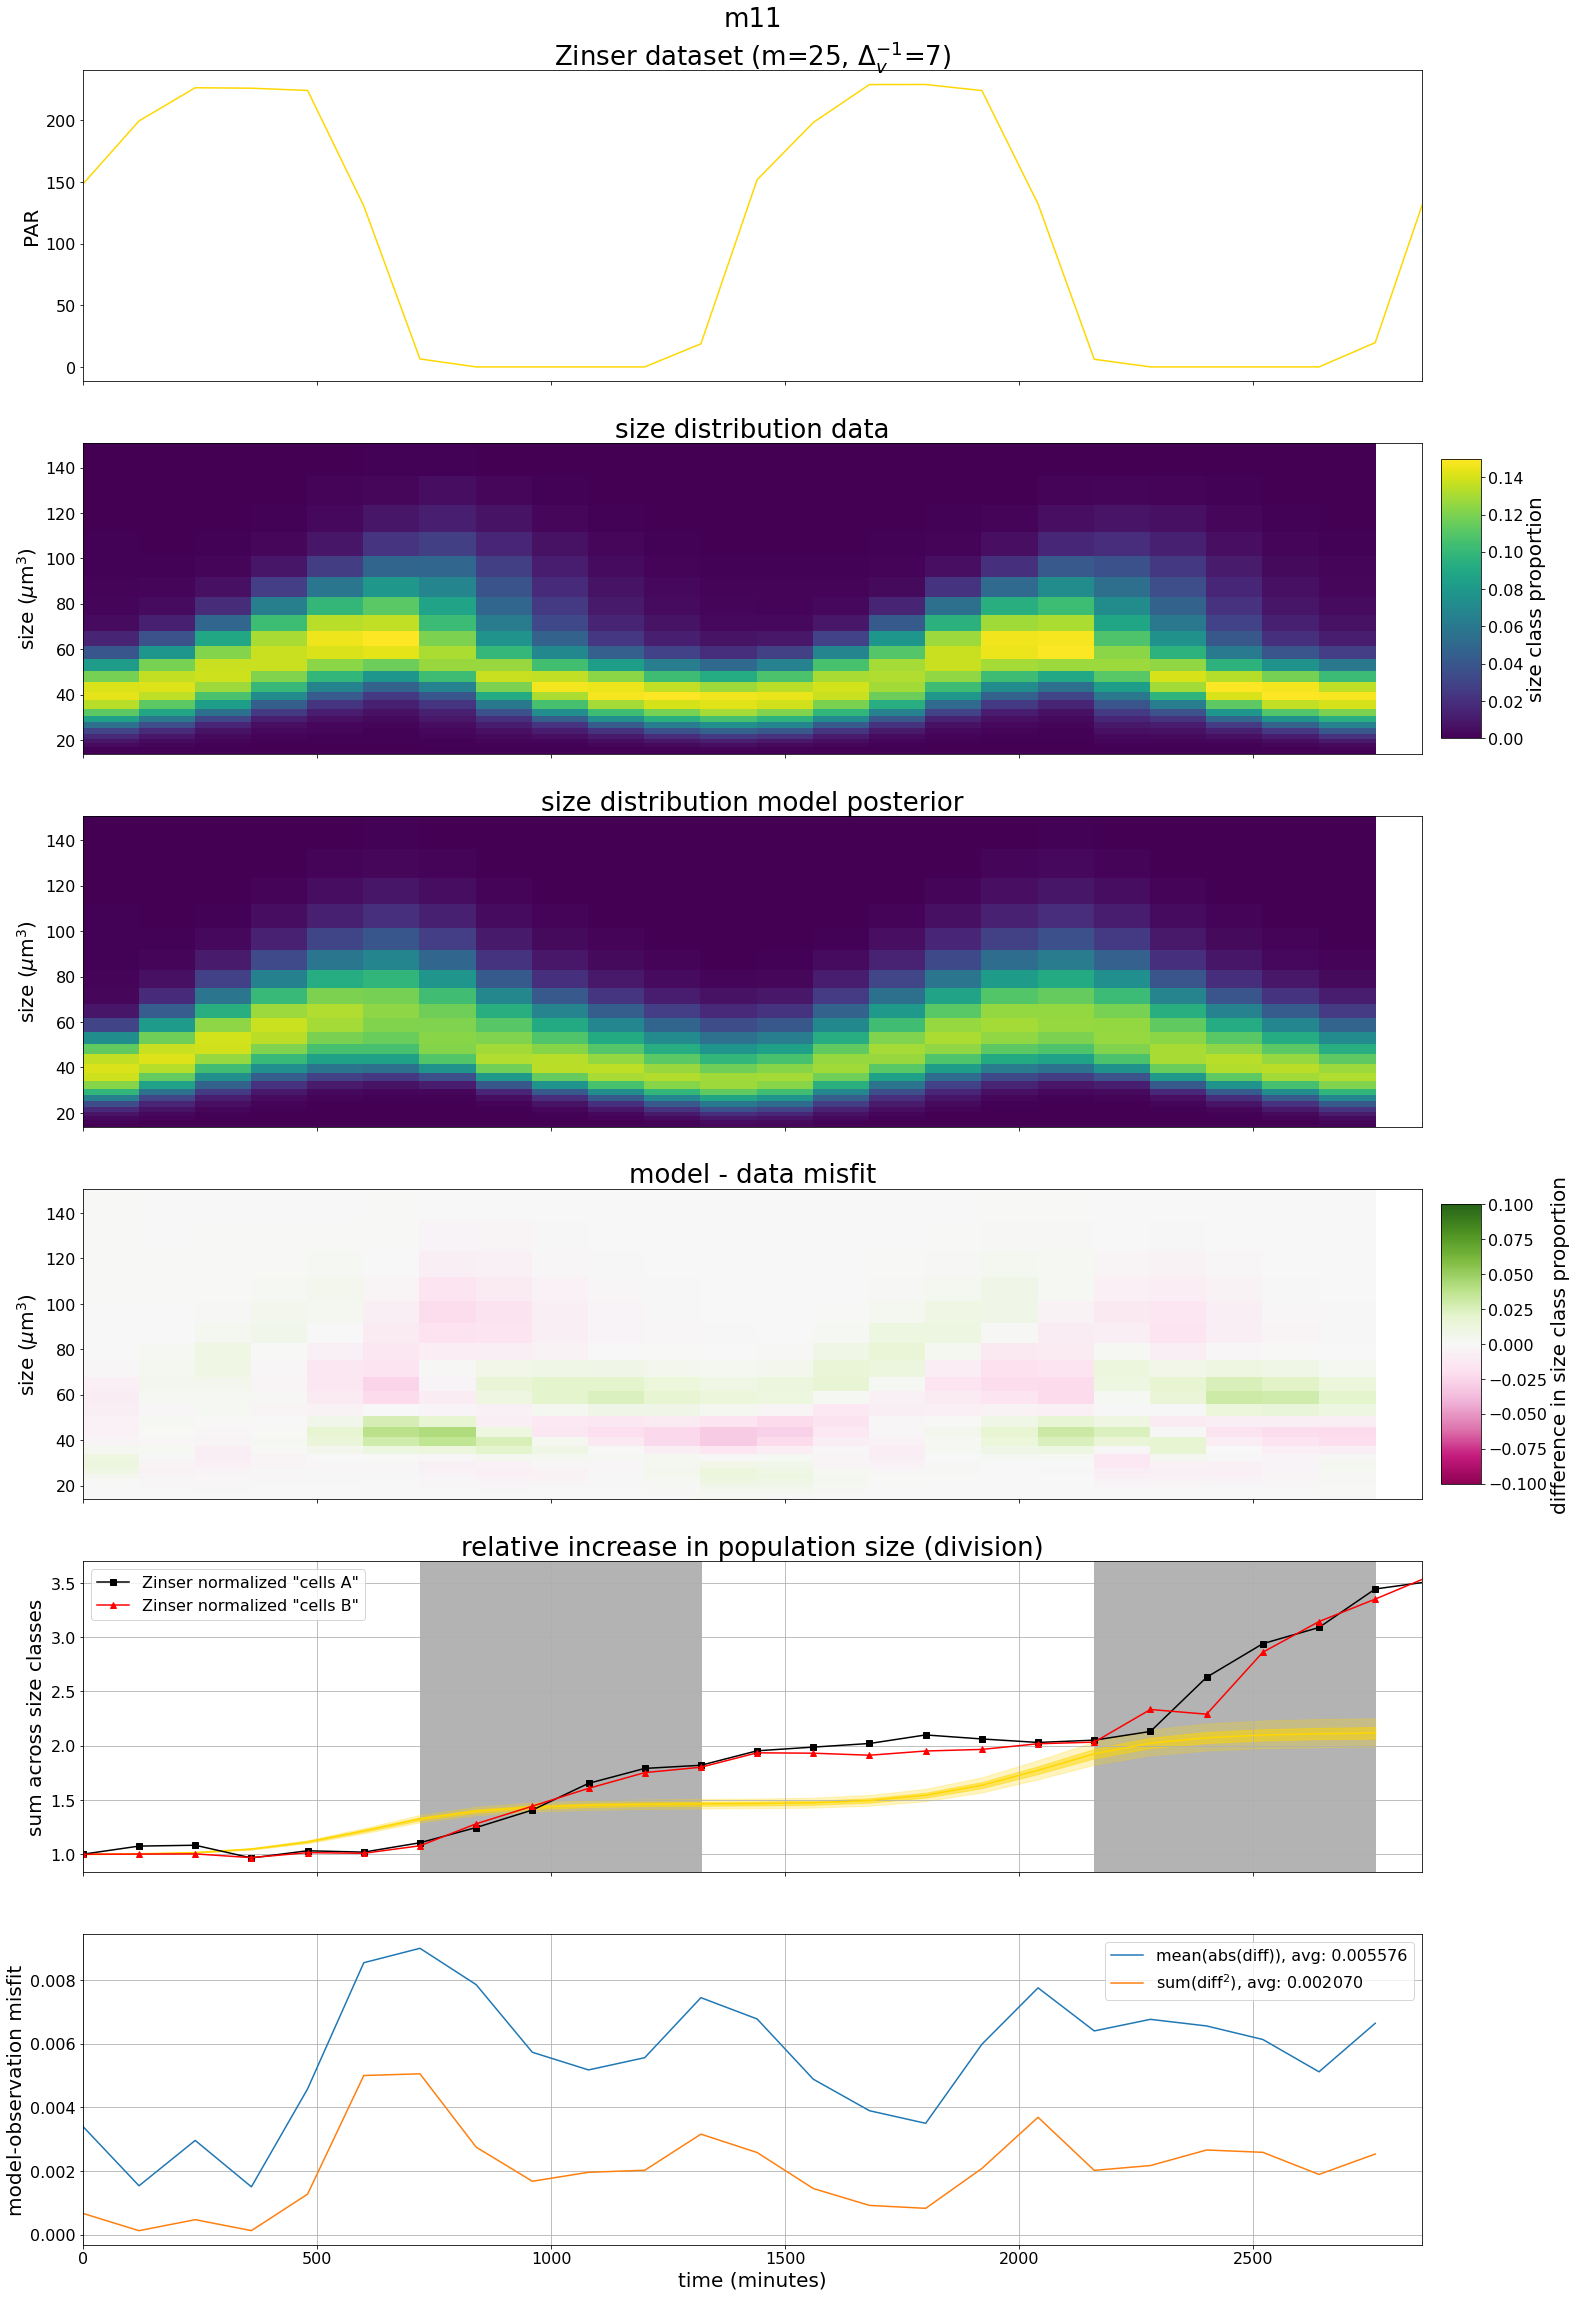

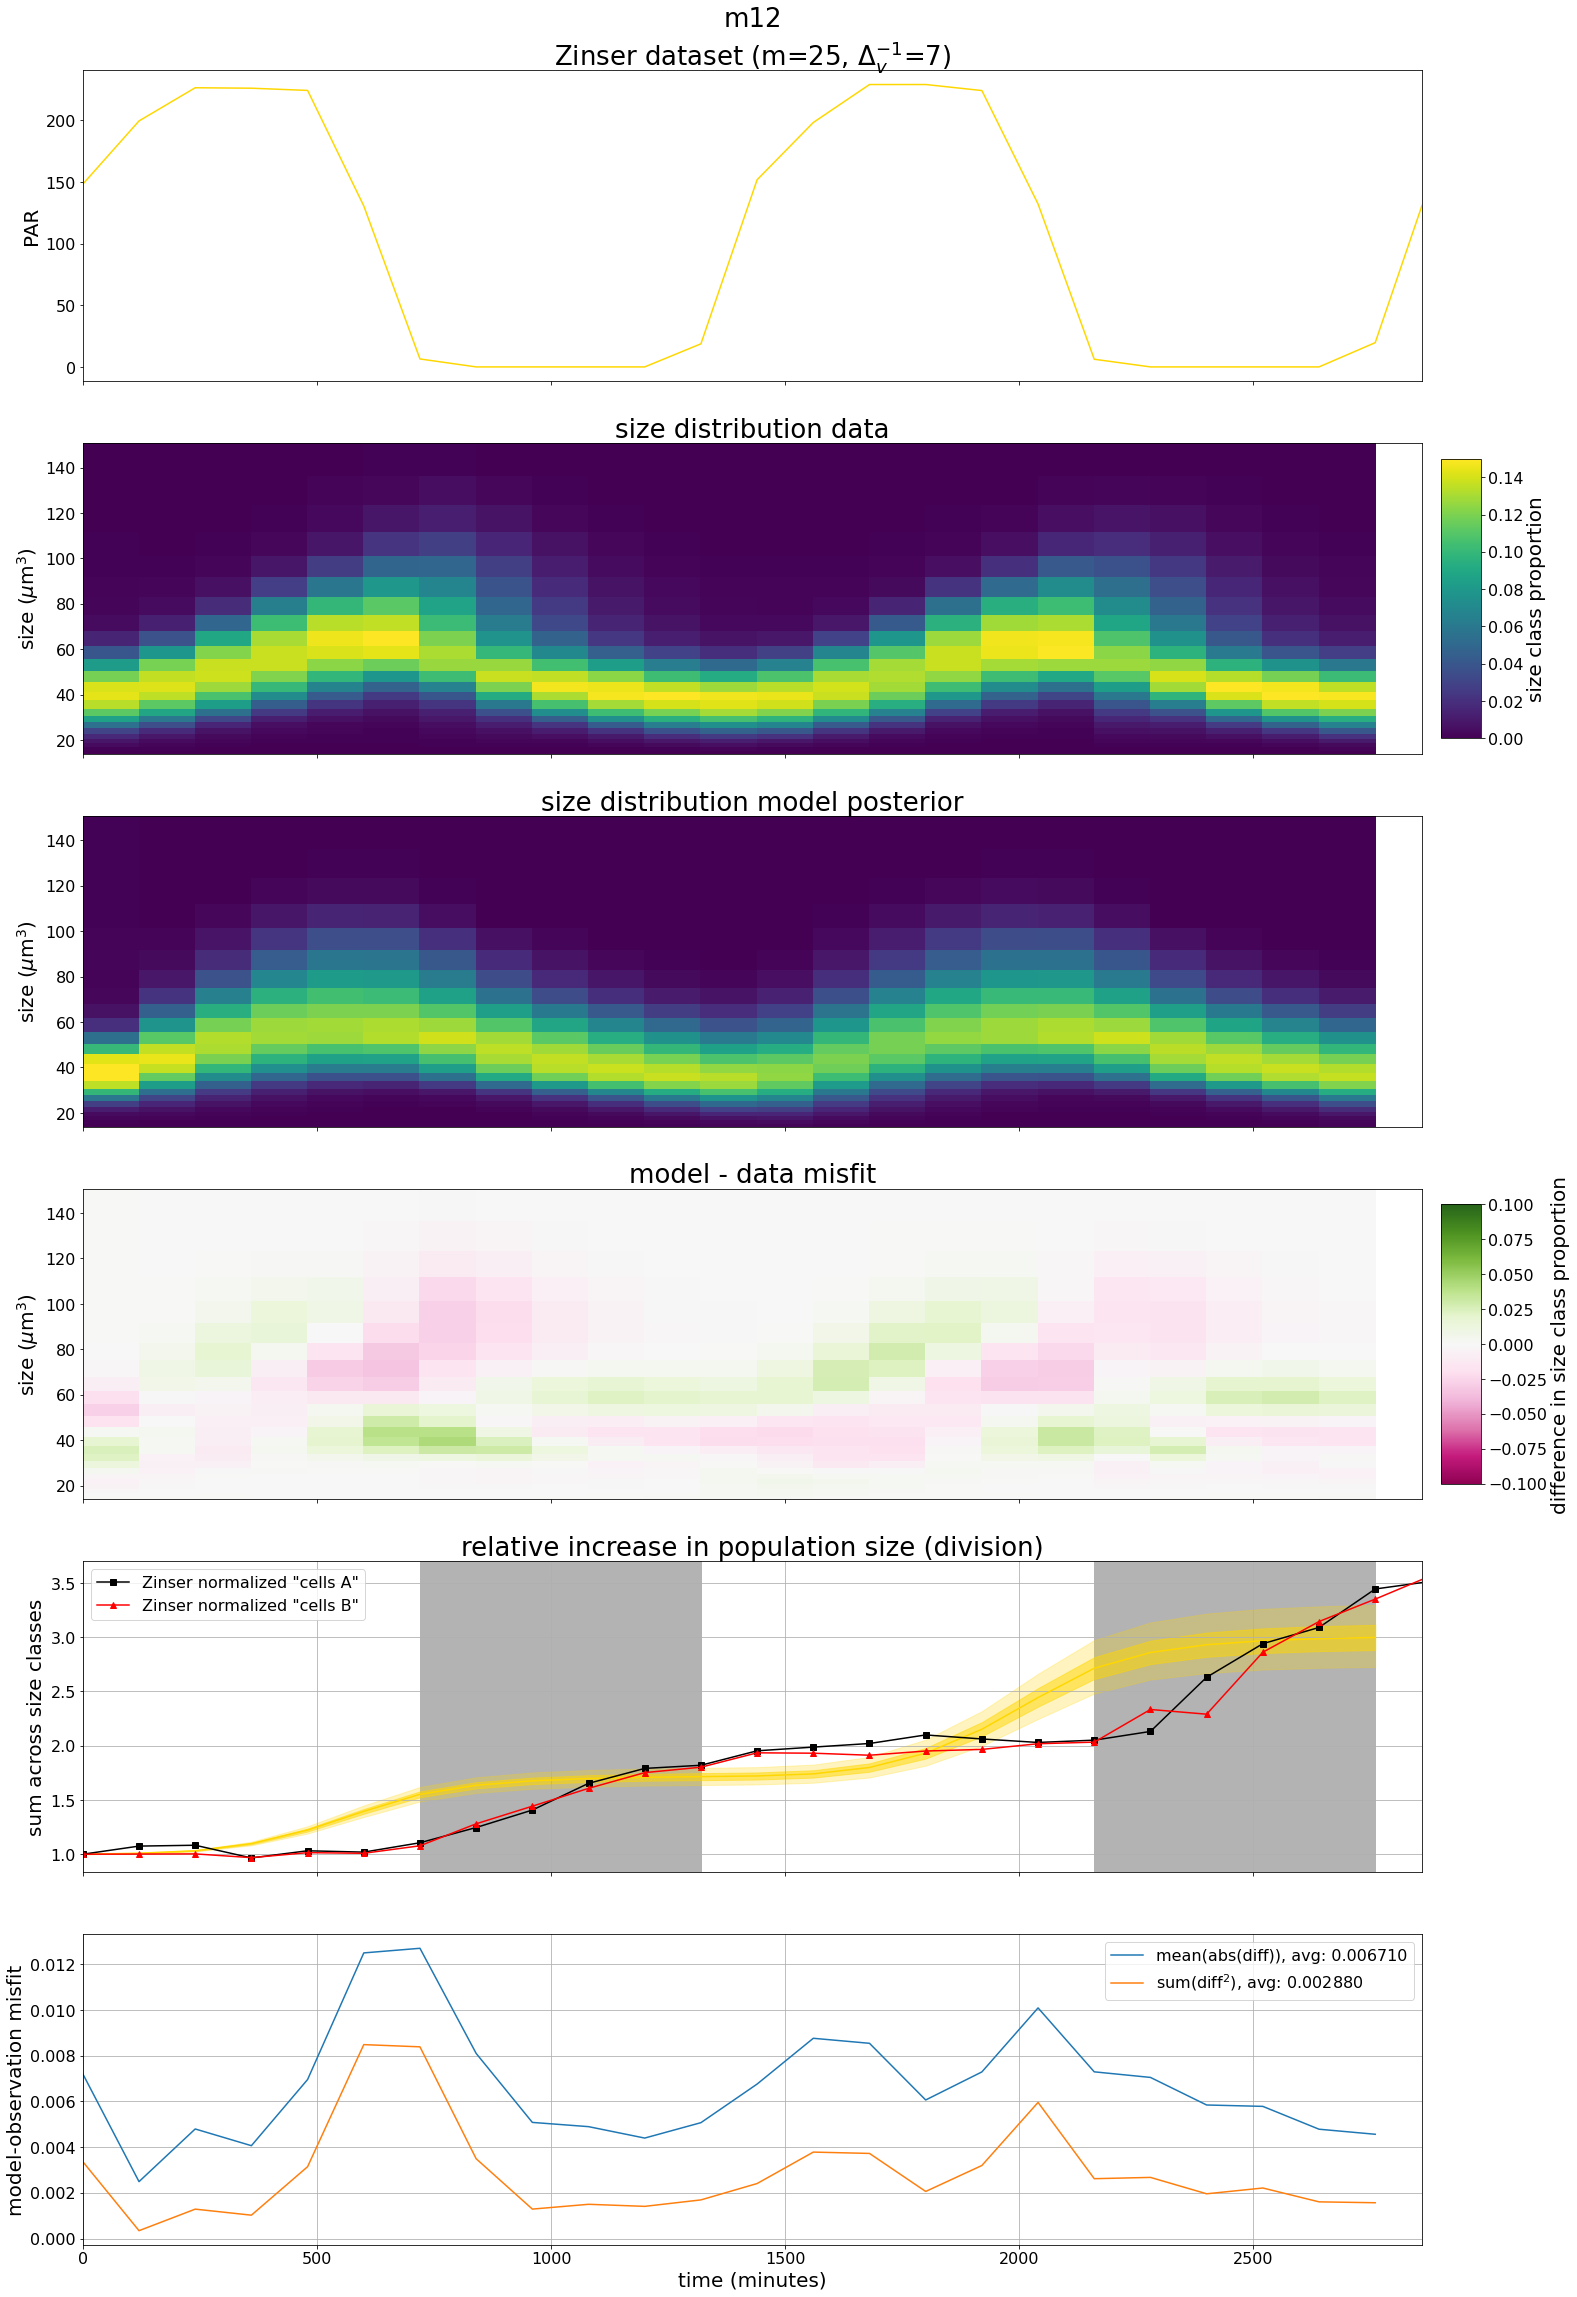

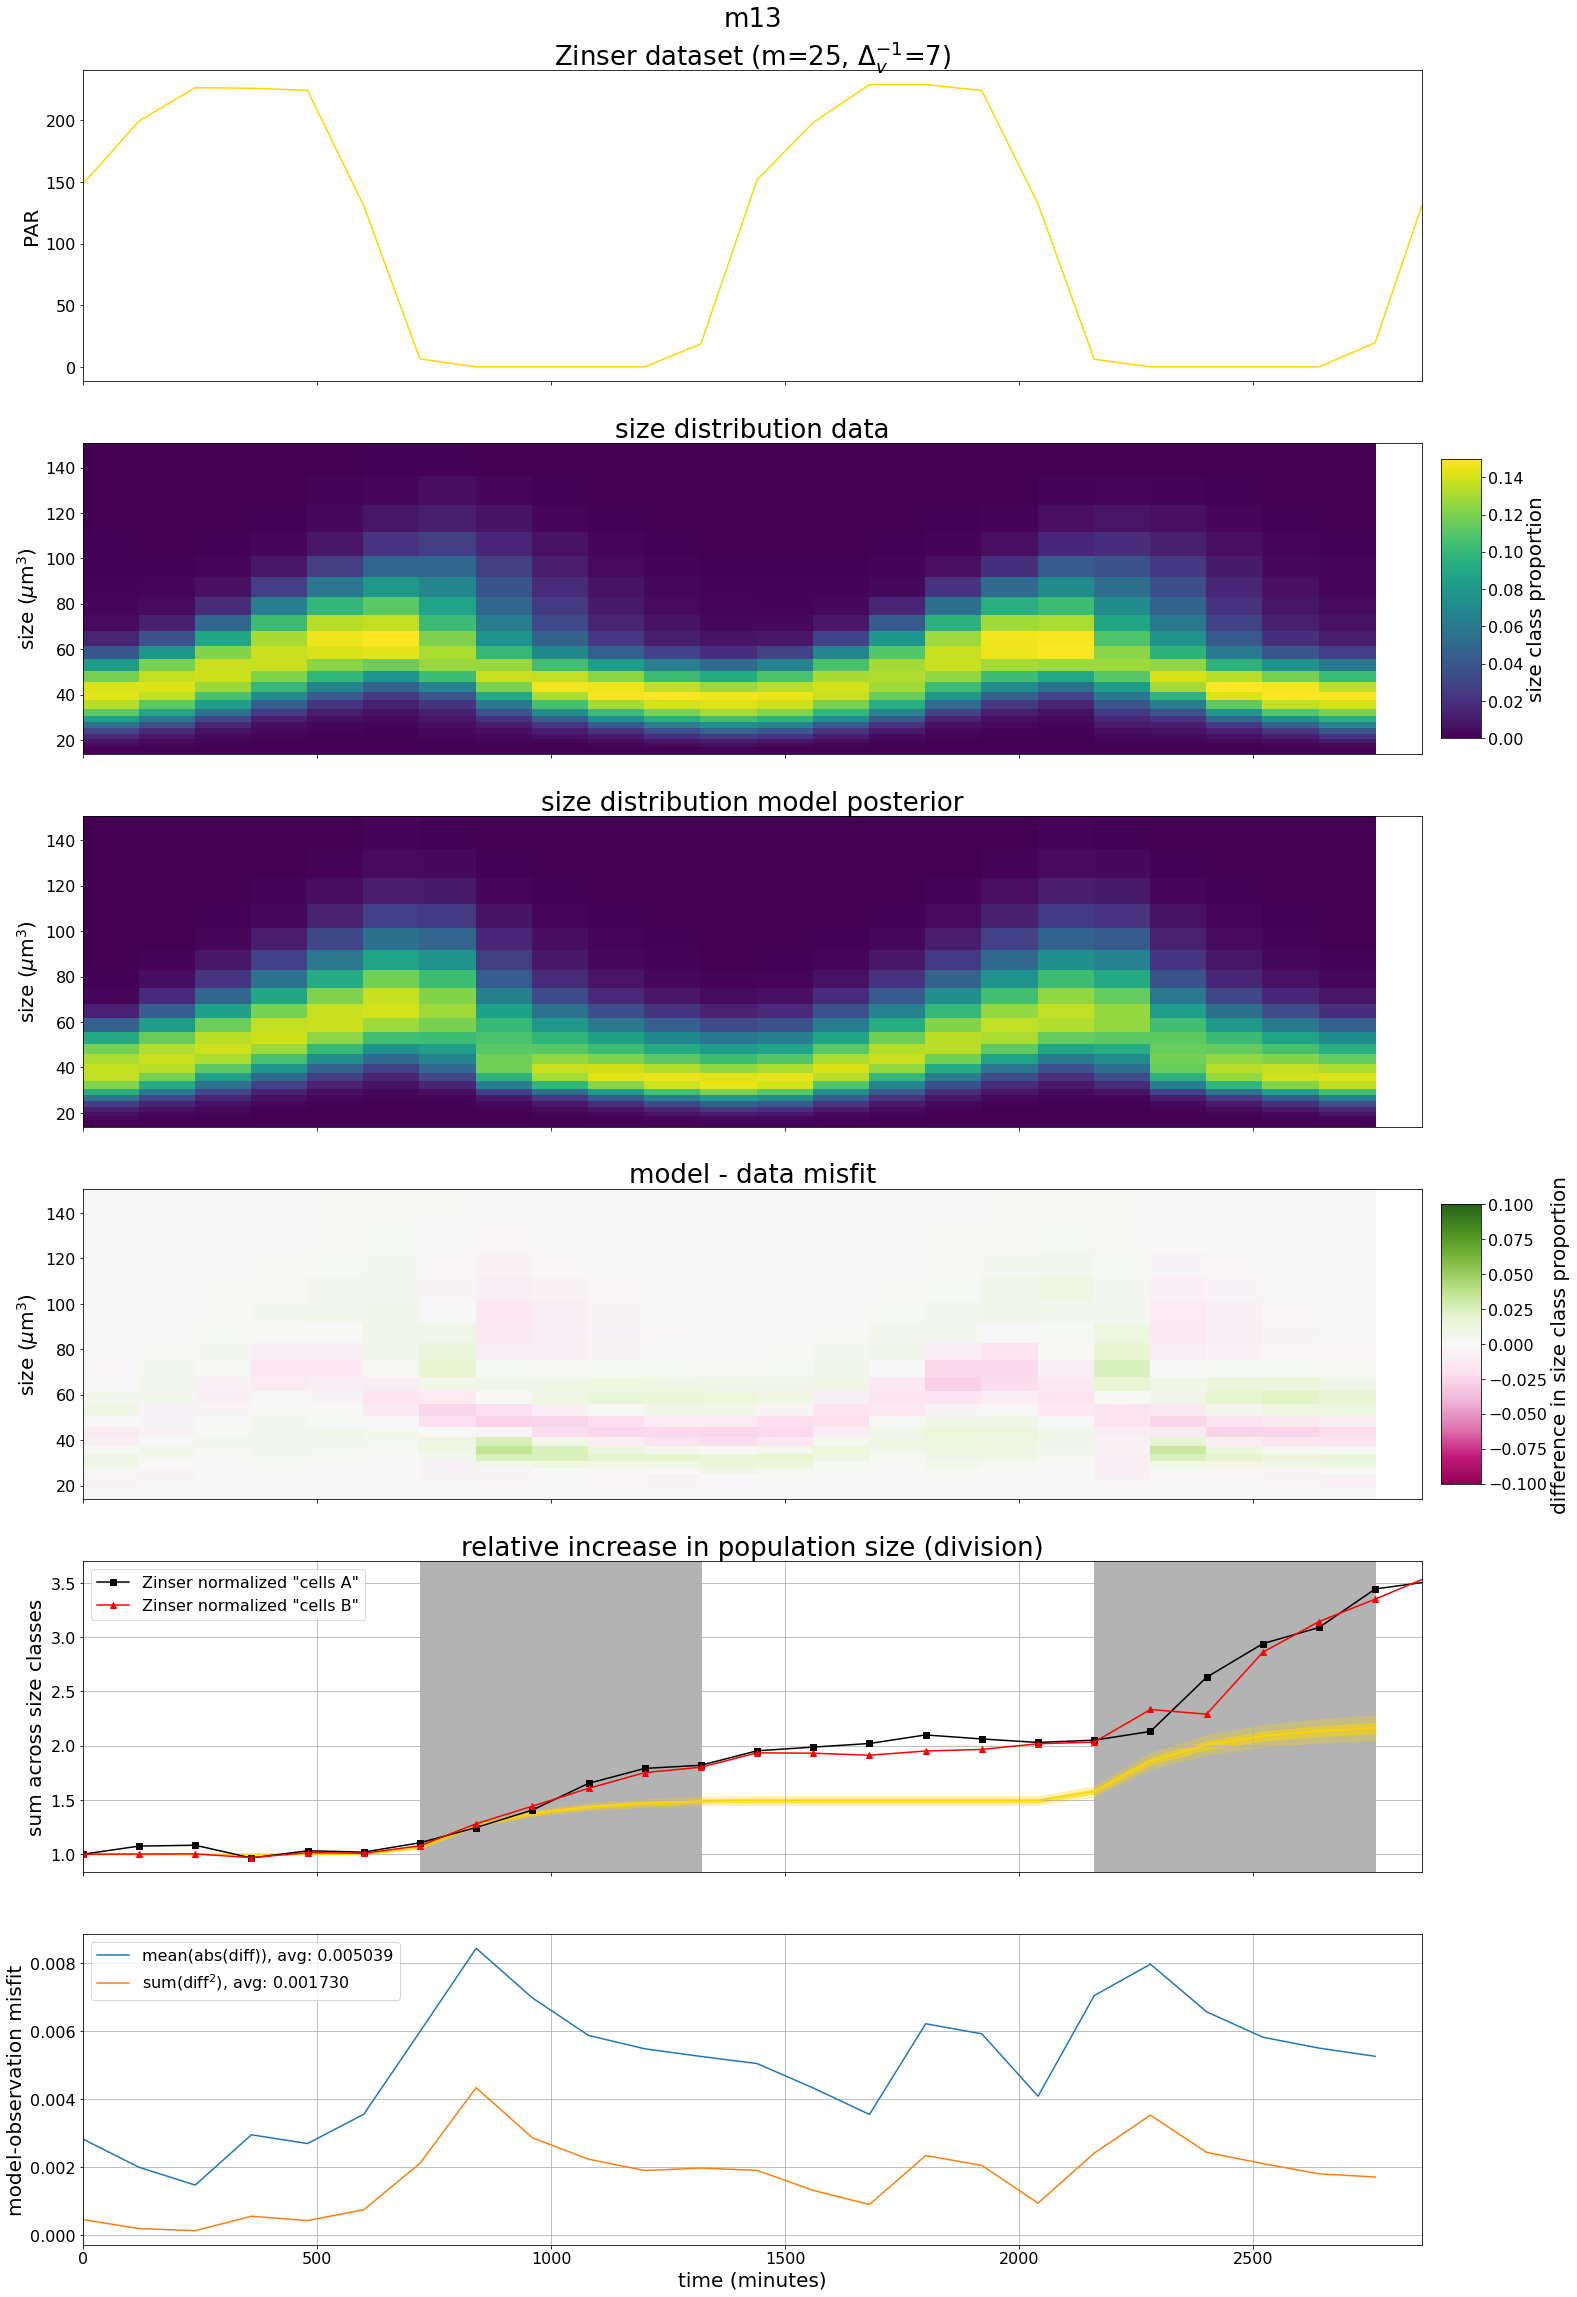

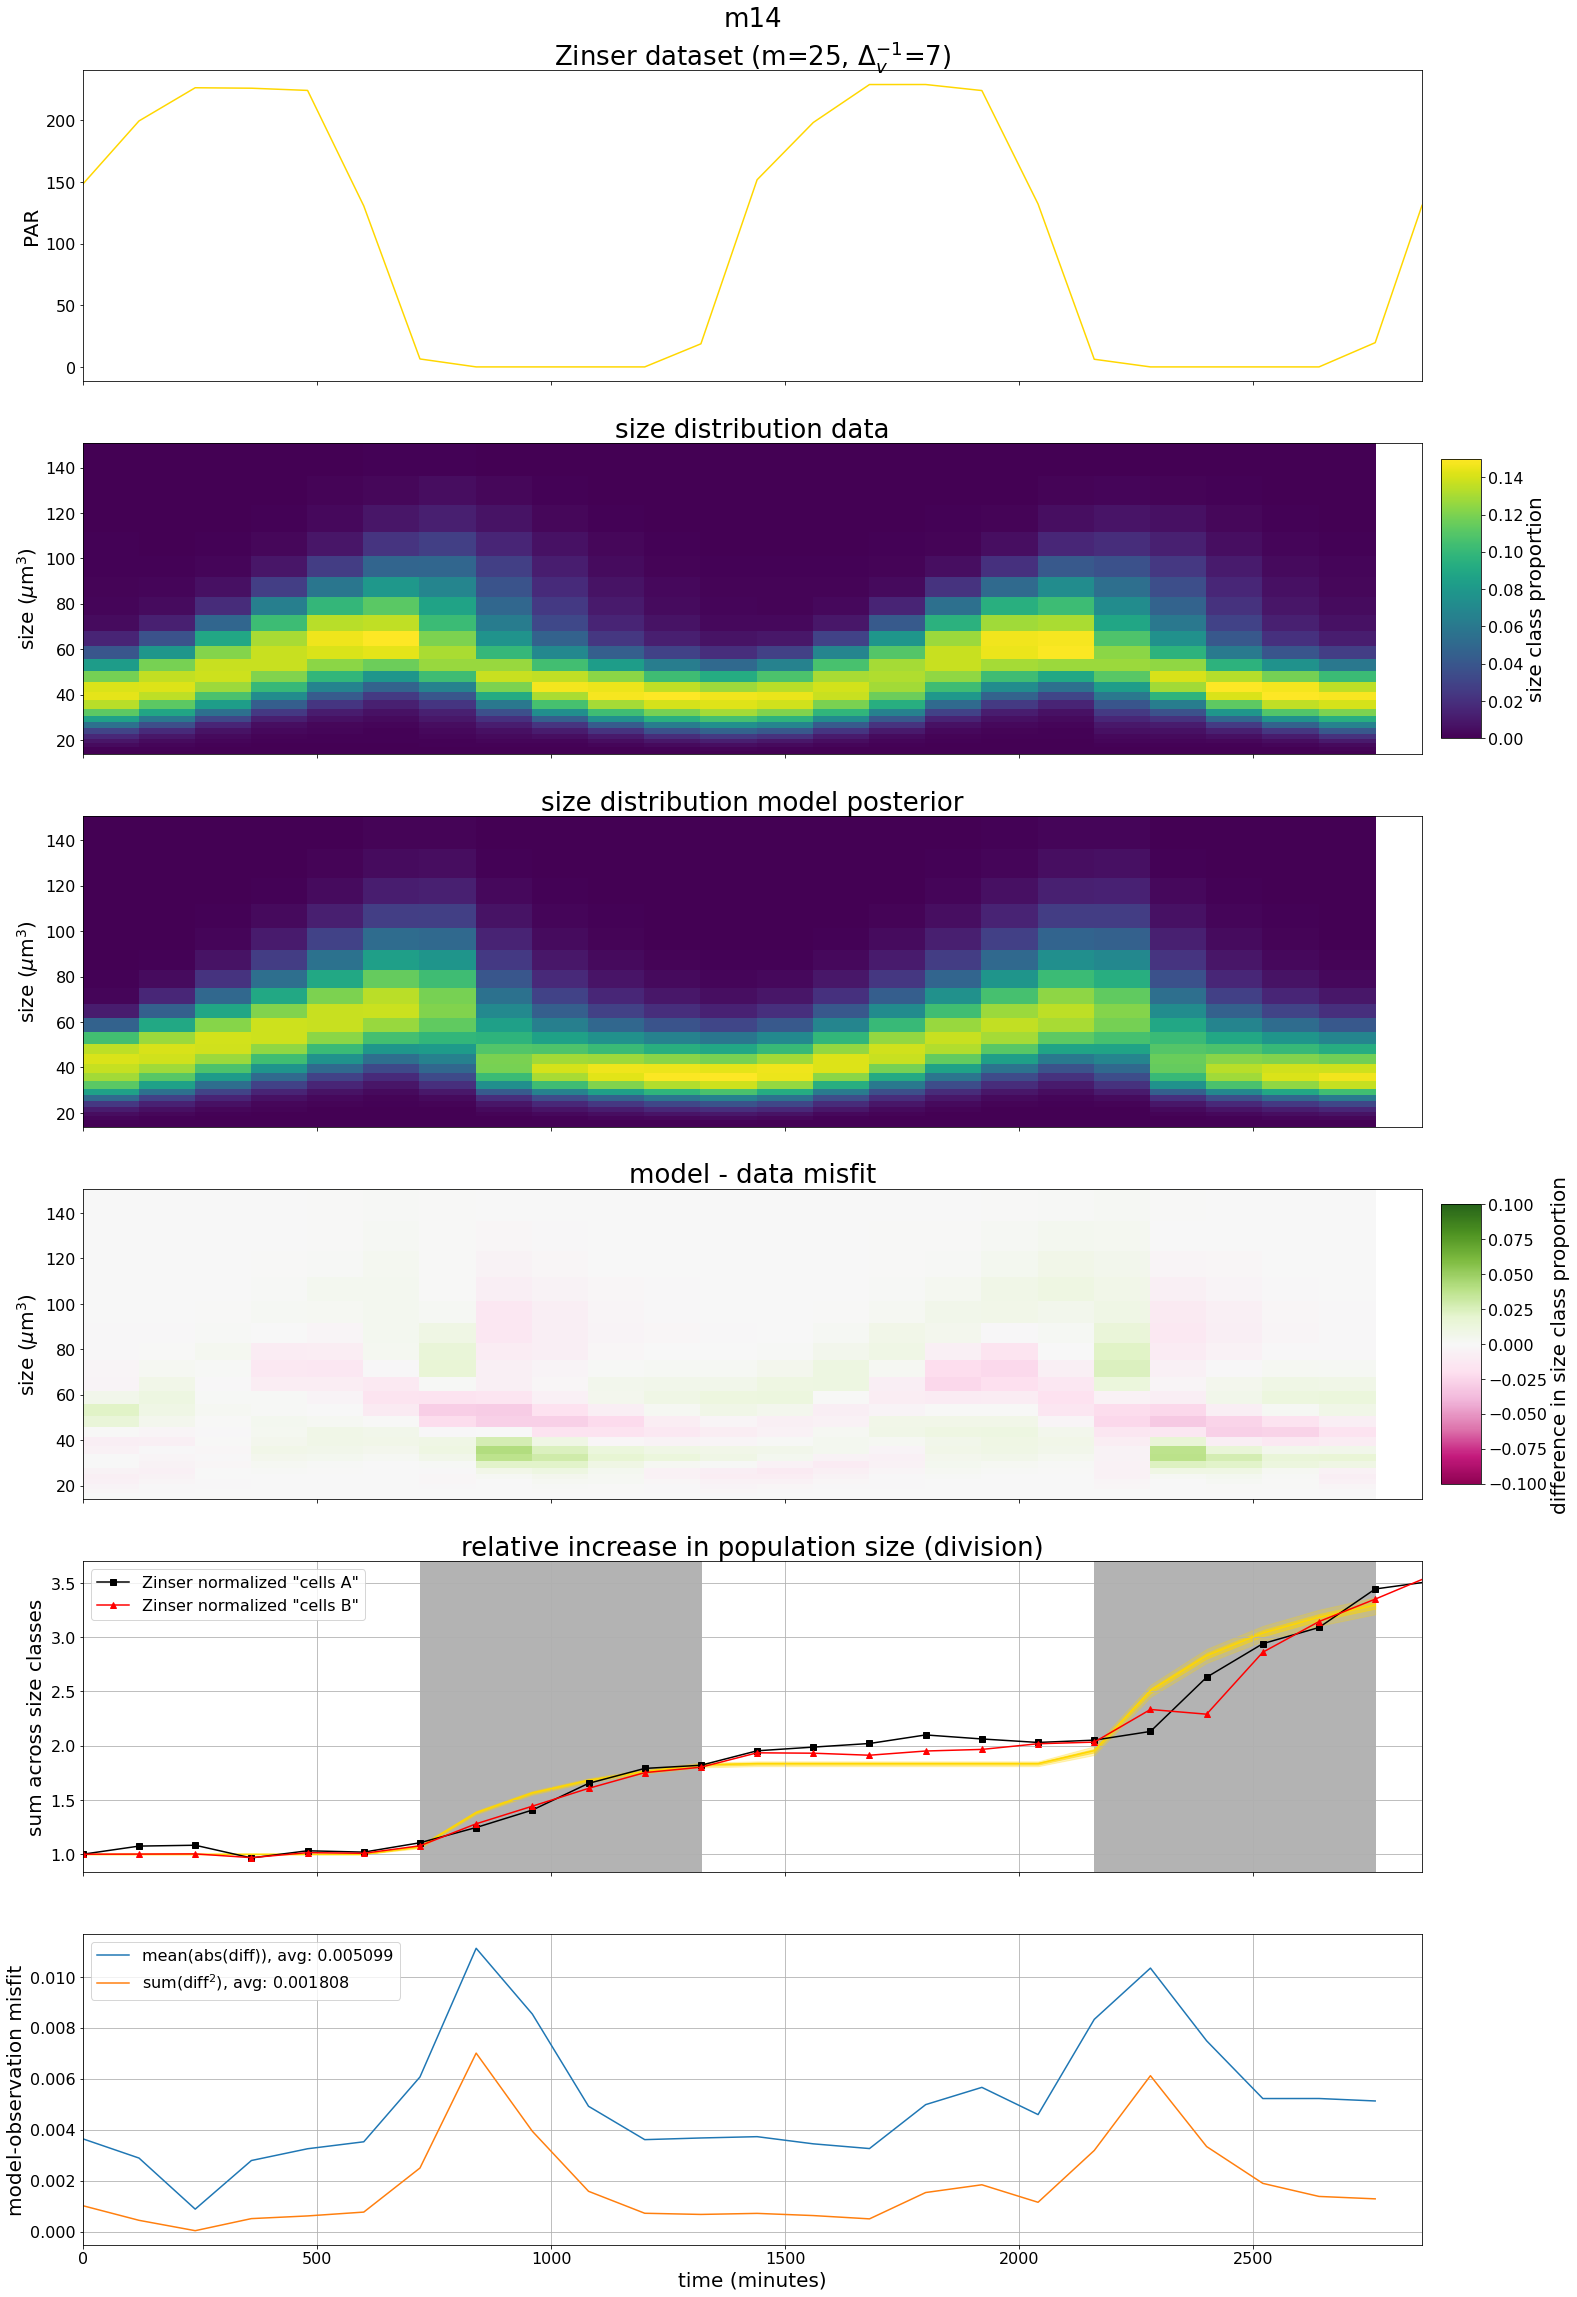

In [17]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for model,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[model][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[model] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, res['obs'],norm=norm, shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, res_sum1,norm=norm, shading='auto')

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, diff,norm=norm_diff, cmap='PiYG', shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [18]:
if 'varnames_save' not in globals():
    varnames_save = None

save_only_converged = True

if savename_output is not None:    
    with nc4.Dataset(savename_output, 'w') as nc:
        for dataname in data:
            ncg = nc.createGroup(dataname)

            if save_stan_output:
                dimensions = {
                    'obstime':int(data[dataname]['nt_obs']),
                    'time':int(data[dataname]['nt']),
                    'sizeclass':int(data[dataname]['m']),
                    'm_minus_j_plus_1':int(data[dataname]['m']-data[dataname]['delta_v_inv']),
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}
                for d in dimensions:
                    ncg.createDimension(d, dimensions[d])
                    
                ncg.createVariable('time', int, ('time',))
                ncg.variables['time'][:] = int(data[dataname]['dt']) * np.arange(data[dataname]['nt'])
                ncg.variables['time'].units = 'minutes since start of experiment'
                
                ncg.createVariable('obstime', int, ('obstime',))
                ncg.variables['obstime'][:] = data[dataname]['t_obs'].astype(int)
                ncg.variables['obstime'].units = 'minutes since start of experiment'
                ncg.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test', 'E', 'obs_count'):
                    if isinstance(data[dataname][v], int):
                        ncg.createVariable(v, int, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    elif isinstance(data[dataname][v], float):
                        ncg.createVariable(v, float, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[dataname][v].shape)
                        ncg.createVariable(v, data[dataname][v].dtype, dims, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                
                for imodel,model in enumerate(mcmcs):
                    if save_only_converged and get_max_rhat(mcmcs[model][dataname]) > 1.1:
                        logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                        continue
                    ncm = ncg.createGroup(model)
                    
                    dimensions['sample'] = mcmcs[model][dataname]['mod_obspos'].shape[0]
                    dimensions_inv[dimensions['sample']] = 'sample'
                    ncm.createDimension('sample', dimensions['sample'])
                    if 'tau[1]' in mcmcs[model][dataname].flatnames:
                        dimensions['tau'] = mcmcs[model][dataname]['tau'].shape[1]
                        dimensions_inv[dimensions['tau']] = 'tau'
                        ncm.createDimension('tau', dimensions['tau'])
                    
                    # write model description
                    ncm.setncattr('description', desc_model[model])
                    ncm.setncattr('code', stan_files[model_stan_key[model]])
                    
                    varnames = set(v.split('[')[0] for v in mcmcs[model][dataname].flatnames)
                    if varnames_save is None:
                        varnames_curr = varnames
                    else:
                        varnames_curr = varnames_save
                        
                    for v in varnames_curr:
                        if v in varnames:
                            dims = tuple(dimensions_inv[d] for d in mcmcs[model][dataname][v].shape)
                            ncm.createVariable(v, float, dims, zlib=True)
                            ncm.variables[v][:] = mcmcs[model][dataname][v]
                        else:
                            logging.warning('Cannot find variable "{}" for model "{}".'.format(v, model))
            else:
                for i,model in enumerate(mcmcs):
                    if i == 0:
                        ncg.createDimension('model', len(mcmcs))
                        ncg.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])

                        ncg.createVariable('divrate', float, ('model','sample'))
                        ncg.createVariable('sumsqdiff', float, ('model','sample'))
                        ncg.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')

                    ncg.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']

                    obs = data[dataname]['obs']

                    tmp = mcmcs[model][dataname]['mod_obspos']
                    tmp/= np.sum(tmp, axis=1)[:,None,:]
                    tmp -= obs[None,:,:]
                    tmp **= 2

                    if np.all(data[dataname]['i_test'] == 0):
                        ncg.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'all data')
                    else:
                        nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                    for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                        if i == 0:
                            ncg.createVariable(v, float, ('model','sample'))
                        if v in mcmcs[model][dataname].flatnames:
                            ncg.variables[v][i,:] = mcmcs[model][dataname][v]